In [ ]:
import geemap
import ee

ee.Authenticate()
# Replace 'your-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='california-fire-model')

Map = geemap.Map()
california = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'California'))

In [ ]:
!gcloud auth application-default login -q
!gcloud config set project california-fire-model


Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=KtvU0NkA9C9SPjbPCuA8qAoct2TDiG&prompt=consent&token_usage=remote&access_type=offline&code_challenge=OB1jWQ3L8lsSF9_EKkE9V429KJzrSldlzXoyClBVfOc&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0Ab32j91FCGa7fj2bTD50iBaqzWKfOYsEyb1BcT8UEljd7xr1MzmdWlywSULVy_Gwkodq3g

Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).
Ca

In [ ]:
# This cell was an exploratory GCS listing.

This isn’t “lying with data” — it’s binning based on relative fire risk, which helps CNN learn general patterns, not absolute counts.


 Fire frequency (burned years) across California:
Most areas: 0–2 fires in 21 years → makes up ~80%+

Some hotspots: 15–20 fires in 21 years → limited spatially

Very few areas: fall in that 5–10 fire count range (~24%–48% recurrence)

So your medium bin (5–10 years) captures a very narrow group, and statistically, it's valid that it's nearly empty — but it’s not helpful for visualization or model training.

export EVM and BIM to earth engine assets ubder a folder.

MTBS

export all EVMS from 2000 to 2025.

In [ ]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 112.9 MB/s eta 0:00:00


In [ ]:
!pip install rasterio google-cloud-storage numpy matplotlib


export these ignition risk maps/ images in google bucket.

instead of season, lets loop through months.

download

 1: Setup and Mount Google Cloud
We’ll begin by:

Authenticating to GCP

Verifying access to your bucket (california-fire-model)

Installing necessary packages



 Patch Extraction Logic
This will:

Iterate over years 2000–2016 and seasons DJF, MAM, JJA, SON

Match EVM and BIM files

Extract valid 32×32 patches centered where BIM pixel is 0, 1, or 2

Save patches and labels to .npy format

prapare training data for U net

Step 1: Mount Google Drive

Step 2: Copy EVM & Burned Area files from GCS → Google Drive

Patch extraction

In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
!gcloud auth login


Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=J3Ub4zmy4VEOwjm4L2zM4ymuB4lJAc&prompt=consent&token_usage=remote&access_type=offline&code_challenge=SUQAmH9F77C-oiXT-VQGiIgOALJ9zeEKRxTGYeoiKHQ&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0Ab32j93XsHLhLOs7hzRtCQFioZg20nOu3Rtiz_6njTPt1TMfEpTNcw_ESLnJhvoB8B2Etg

You are now logged in as [samrakshanadhikari@gmail.com].
Your current p

In [ ]:
# This cell was an exploratory GCS listing.

In [ ]:
import ee, geemap
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# Butte County AOI
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties") \
            .filter(ee.Filter.eq('STATEFP', '06'))
butte = COUNTIES.filter(ee.Filter.eq("NAME", "Butte")).geometry()

# Date range
start = ee.Date('2018-11-01')
end   = ee.Date('2018-11-30')

# MODIS true color
modis = ee.ImageCollection("MODIS/061/MOD09A1") \
           .filterDate(start, end) \
           .select(['sur_refl_b01','sur_refl_b04','sur_refl_b03'], ['R','G','B']) \
           .median().multiply(0.0001).clip(butte)

Map = geemap.Map(center=[39.7, -121.6], zoom=8)
Map.addLayer(modis, {"min":0.02,"max":0.3,"bands":["R","G","B"]}, "MODIS True Color")
Map


Map(center=[39.7, -121.6], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

) Configure file paths for one event (then loop your list)

BURN_TIF: monthly MCD64A1 binary burn mask for the AOI (1=burned, 0=unburned), 500 m.

EVM_TIF: same month AOI EVM stack (your exported 9-band TIFF at 500 m).

PREVIEW_PNG: the pretty image you already exported (RGB + red overlay) for slide overlays.

In [ ]:
# If needed: pull from GCS first (uncomment)
# !gsutil -m cp "gs://california-fire-model/burned_area/Burned_Area_Nov_2018.tif" /content/
# !gsutil -m cp "gs://california-fire-model/evms/Nov_2018/EVM_Nov_2018.tif" /content/

BURN_TIF    = "/content/Burned_Area_Nov_2018.tif"   # 1/0, 500 m, AOI-clipped
EVM_TIF     = "/content/EVM_Nov_2018.tif"           # 9 bands, 500 m, AOI-clipped
PREVIEW_PNG = "/content/Camp_2018_11_RGB_burn.png"  # your PNG for the same AOI/month
OUT_DIR     = "/content/patches_Camp_Nov2018"
PATCH       = 32     # 32x32 at 500 m => ~16 km x 16 km
MIN_PIX     = 30     # min burned pixels to accept a cluster (tune smaller/bigger)
MAX_POS     = 60     # cap how many positive patches to extract (keep professor-happy)
NEG_PER_POS = 1      # sample 1 nearby negative per positive


In [ ]:
# --- Mirror both EVM13 and Burned to local paths the mapper expects ---
!mkdir -p /content/data/evms_events /content/data/burned_events

# EVM13 (matches your export names)
!gsutil -m cp -n "gs://california-fire-model/evms_events/*/EVM13_*_WGS84_500m.tif" /content/data/evms_events/

# Burned (matches the code in step 1)
!gsutil -m cp -n "gs://california-fire-model/burned_events/*/Burned_*_WGS84_500m.tif" /content/data/burned_events/

!ls -lh /content/data/evms_events | head -n 5
!ls -lh /content/data/burned_events | head -n 5


ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
CommandException: 1 file/object could not be transferred.
ServiceException: 401 Anonymous caller does not have storage.objects.list access to the Google Cloud Storage bucket. Permission 'storage.objects.list' denied on resource (or it may not exist).
CommandException: 1 file/object could not be transferred.
total 0
total 0


In [ ]:
# This cell was an exploratory GCS listing.

evm export

In [ ]:
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap, math

# Authenticate / init
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events (fire months)
# =========================
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# =========================
# AOI helpers (robust geometry)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
# for pixel level match
    geom = geom.buffer(0, 100)
    geom = geom.simplify(100)

    # Avoid zero-buffer errors; modest simplify is safe for county-scale AOIs
    return geom.bounds(1000)

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def prev_month(year, month):
    return (year-1, 12) if month == 1 else (year, month-1)

def prev_ym(year, month, k=1):
    d = ee.Date.fromYMD(year, month, 15).advance(-k, 'month')
    return ee.Number(d.get('year')).int(), ee.Number(d.get('month')).int()

# =========================
# Config
# =========================
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500
LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
BUCKET = 'california-fire-model'

FILE_PREFIX_FMT = (
    "evms_events/{fire_name}/"
    "EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{crs}_{scale}m"
)
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

# =========================
# Reprojection helpers
# =========================
def reproj_cont(img):        # continuous → Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical → Float32 (keep categories discrete)
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

# =========================
# Physics helpers (VPD)
# =========================
def _esat_kPa(Tc):
    # Tetens; Tc in °C
    return ee.Image(0.6108).multiply((ee.Image(17.27).multiply(Tc)).divide(Tc.add(237.3)).exp())

def _pressure_Pa(elev_m):
    # barometric approximation
    return ee.Image(101325).multiply((ee.Image(1).subtract(ee.Image(2.25577e-5).multiply(elev_m))).pow(5.25588))

def _ea_kPa(q, p_Pa):
    # specific humidity (kg/kg) to vapor pressure (kPa)
    ea_Pa = q.multiply(p_Pa).divide(ee.Image(0.622).add(ee.Image(0.378).multiply(q)))
    return ea_Pa.divide(1000.0)

def vpd_from_tminsph(tminC, tmaxC, sph, elev):
    Tmean = tminC.add(tmaxC).divide(2)
    es = _esat_kPa(Tmean)
    p  = _pressure_Pa(elev)
    ea = _ea_kPa(sph, p)
    return es.subtract(ea).rename('VPD')  # kPa

# =========================
# NLCD helpers (epochal, correct release)
# =========================
NLCD_YEARS = [2001, 2006, 2011, 2016, 2019, 2021]

def choose_nlcd_year_num(fire_year_int):
    y = None
    for yr in NLCD_YEARS:
        if yr <= fire_year_int:
            y = yr
        else:
            break
    return y if y is not None else NLCD_YEARS[0]

def load_nlcd_epoch(nlcd_year_int):
    # 2001–2019 are in the 2019 release; 2021 is in the 2021 release
    asset = (f'USGS/NLCD_RELEASES/2021_REL/NLCD/{nlcd_year_int}'
             if nlcd_year_int == 2021
             else f'USGS/NLCD_RELEASES/2019_REL/NLCD/{nlcd_year_int}')
    return ee.Image(asset).select('landcover')

def one_hot_nlcd(nlcd_img):
    # Common NLCD classes
    classes = [11,12,21,22,23,24,31,41,42,43,52,71,81,82,90,95]
    return ee.Image.cat([nlcd_img.eq(c).rename(f'NLCD_{c}') for c in classes])

# =========================
# STATIC features (topo + NLCD one-hot)
# =========================
def build_static_features(region, nlcd_year_int):
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')
    aspect = ee.Terrain.aspect(dem)
    aspect_sin = reproj_cont(aspect.multiply(math.pi/180.0).sin()).rename('aspect_sin')
    aspect_cos = reproj_cont(aspect.multiply(math.pi/180.0).cos()).rename('aspect_cos')

    # 3x3 roughness via std-dev
    kernel3 = ee.Kernel.square(radius=1, units='pixels', normalize=False)
    roughness = reproj_cont(
        dem.reduceNeighborhood(reducer=ee.Reducer.stdDev(), kernel=kernel3)
    ).rename('roughness')

    # NLCD epoch → one-hot (no explicit resample; reprojection handles alignment)
    nlcd_raw = load_nlcd_epoch(nlcd_year_int)
    nlcd_oh  = one_hot_nlcd(reproj_cat_to_float(nlcd_raw))

    return ee.Image.cat([elev, slope, aspect_sin, aspect_cos, roughness, nlcd_oh]).clip(region).toFloat()

# =========================
# DYNAMIC monthly features (weather/veg/LFMC/drought)
# =========================
def build_month_features(year, month, region):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')

    grid = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start, end)
    tmaxK = grid.select('tmmx').mean()
    tminK = grid.select('tmmn').mean()
    pr    = grid.select('pr').sum()
    wind  = grid.select('vs').mean()
    sph   = grid.select('sph').mean()
    eto   = grid.select('eto').sum()

    tmaxC = reproj_cont(tmaxK.subtract(273.15)).rename('tmax')
    tminC = reproj_cont(tminK.subtract(273.15)).rename('tmin')
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    sph   = reproj_cont(sph).rename('humidity')
    eto   = reproj_cont(eto).rename('eto')
    aridity = pr.divide(eto.max(1e-9)).rename('aridity')

    # MODIS vegetation with QA
    ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
            .filterDate(start, end)
            .map(lambda img: img.updateMask(img.select('SummaryQA').eq(0)))
            .select('NDVI').mean().multiply(0.0001))
    ndvi = reproj_cont(ndvi).rename('NDVI')

    lai = (ee.ImageCollection('MODIS/061/MCD15A3H')
           .filterDate(start, end)
           .map(lambda img: img.updateMask(img.select('FparLai_QC').bitwiseAnd(3).lt(2)))
           .select('Lai').mean().multiply(0.1))
    lai = reproj_cont(lai).rename('LAI')

    # LFMC (+ availability flag)
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc_has = lfmc_ic.size().gt(0)
    lfmc_val = ee.Image(ee.Algorithms.If(lfmc_has, lfmc_ic.mean(), ee.Image(0)))
    lfmc     = reproj_cont(lfmc_val).rename('LFMC')
    lfmc_flag = reproj_cont(ee.Image(lfmc_has)).rename('LFMC_available')

    # VPD (kPa) using SRTM for pressure
    elev_for_vpd = ee.Image('CGIAR/SRTM90_V4')
    VPD = reproj_cont(vpd_from_tminsph(tminC, tmaxC, sph, elev_for_vpd))

    # TerraClimate (monthly mean)
    tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterDate(start, end).mean()
    tc_def  = reproj_cont(tc.select('def')).rename('def')
    tc_pdsi = reproj_cont(tc.select('pdsi')).rename('pdsi')
    srad    = reproj_cont(tc.select('srad')).rename('srad')

    return ee.Image.cat([
        tmaxC, tminC, pr, wind, sph, eto, aridity,
        VPD, ndvi, lai, lfmc, lfmc_flag, tc_def, tc_pdsi, srad
    ]).clip(region).toFloat()

# =========================
# Lags + aggregates (fixed: homogeneous band names for VPD_3mo)
# =========================
def build_prev_with_lags(fire_year_int, fire_month_int, region, nlcd_year_int):
    # Statics (topo + NLCD)
    statics = build_static_features(region, nlcd_year_int)

    # Base month: prev-1
    y1, m1 = prev_ym(fire_year_int, fire_month_int, 1)
    base = build_month_features(y1, m1, region)

    # Lags prev-1..3 (explicit suffixes)
    lag_imgs = []
    for k in [1, 2, 3]:
        yk, mk = prev_ym(fire_year_int, fire_month_int, k)
        img_k = build_month_features(yk, mk, region)
        rn = img_k.bandNames().map(lambda b: ee.String(b).cat(ee.String(f'_lag{k}')))
        lag_imgs.append(img_k.rename(rn))

    # 3-month aggregates (PR sum, VPD mean) over prev-3..prev-1
    start3 = ee.Date.fromYMD(fire_year_int, fire_month_int, 1).advance(-3, 'month')
    end1   = ee.Date.fromYMD(fire_year_int, fire_month_int, 1)

    pr_3mo = reproj_cont(
        ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
          .select('pr')
          .filterDate(start3, end1)
          .sum()
    ).rename('pr_3mo')

    img_lags = ee.Image.cat(lag_imgs)

    # Build a homogeneous collection for VPD_3mo
    vpd_list = []
    for nm in ['VPD_lag1', 'VPD_lag2', 'VPD_lag3']:
        vpd_list.append(img_lags.select(nm).rename('VPD'))
    VPD_3mo = ee.ImageCollection(vpd_list).mean().rename('VPD_3mo')

    return ee.Image.cat([statics, base] + lag_imgs + [pr_3mo, VPD_3mo]).toFloat()

# =========================
# Export
# =========================
def export_prev_month_evm(fire_name, fire_year, fire_month, region):
    nlcd_year_int = choose_nlcd_year_num(int(fire_year))
    img = build_prev_with_lags(int(fire_year), int(fire_month), region, nlcd_year_int)

    fire_ym = f"{fire_year}-{fire_month:02d}"
    feat_y, feat_m = prev_month(fire_year, fire_month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name, fire_ym=fire_ym, feat_ym=feat_ym, crs=CRS_TAG, scale=SCALE
    )
    desc = prefix.split('/')[-1]

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started EVM export for {fire_name}: prev {feat_ym} → label {fire_ym} → gs://{BUCKET}/{prefix}.tif")

# =========================
# Kick off exports
# =========================
for fire_name, counties, (fire_year, fire_month) in events:
    region = aoi_from_counties(counties)
    export_prev_month_evm(
        fire_name=fire_name,
        fire_year=fire_year,
        fire_month=fire_month,
        region=region
    )

# =========================
# (Optional) check tasks
# =========================
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '|', s.get('state'), '|', s.get('error_message'))


🚀 Started EVM export for Cedar_2003_10: prev 2003-09 → label 2003-10 → gs://california-fire-model/evms_events/Cedar_2003_10/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
🚀 Started EVM export for FallFire_2007_10: prev 2007-09 → label 2007-10 → gs://california-fire-model/evms_events/FallFire_2007_10/EVMx_FallFire_2007_10_2007-10_prev_2007-09_EPSG5070_500m.tif
🚀 Started EVM export for Station_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/Station_2009_08/EVMx_Station_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for LaBrea_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/LaBrea_2009_08/EVMx_LaBrea_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for Thomas_2017_12: prev 2017-11 → label 2017-12 → gs://california-fire-model/evms_events/Thomas_2017_12/EVMx_Thomas_2017_12_2017-12_prev_2017-11_EPSG5070_500m.tif
🚀 Started EVM export for Atlas_2017_10: prev 2017-09 → label 2017-10 

New export

In [ ]:
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap, math

# Authenticate / init
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events (fire months)
# =========================
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# =========================
# AOI helpers (robust geometry)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # for pixel level match
    geom = geom.buffer(0, 100)
    geom = geom.simplify(100)
    # Avoid zero-buffer errors; modest simplify is safe for county-scale AOIs
    return geom.bounds(1000)

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def prev_month(year, month):
    return (year-1, 12) if month == 1 else (year, month-1)

def prev_ym(year, month, k=1):
    d = ee.Date.fromYMD(year, month, 15).advance(-k, 'month')
    return ee.Number(d.get('year')).int(), ee.Number(d.get('month')).int()

# =========================
# Config
# =========================
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500
LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
BUCKET = 'california-fire-model'

FILE_PREFIX_FMT = (
    "evms_events/{fire_name}/"
    "EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{crs}_{scale}m"
)
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

# =========================
# Reprojection helpers
# =========================
def reproj_cont(img):        # continuous → Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical → Float32 (keep categories discrete)
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

# =========================
# Physics helpers (VPD)
# =========================
def _esat_kPa(Tc):
    # Tetens; Tc in °C
    return ee.Image(0.6108).multiply(
        (ee.Image(17.27).multiply(Tc)).divide(Tc.add(237.3)).exp()
    )

def _pressure_Pa(elev_m):
    # barometric approximation
    return ee.Image(101325).multiply(
        (ee.Image(1).subtract(ee.Image(2.25577e-5).multiply(elev_m))).pow(5.25588)
    )

def _ea_kPa(q, p_Pa):
    # specific humidity (kg/kg) to vapor pressure (kPa)
    ea_Pa = q.multiply(p_Pa).divide(
        ee.Image(0.622).add(ee.Image(0.378).multiply(q))
    )
    return ea_Pa.divide(1000.0)

def vpd_from_tminsph(tminC, tmaxC, sph, elev):
    Tmean = tminC.add(tmaxC).divide(2)
    es = _esat_kPa(Tmean)
    p  = _pressure_Pa(elev)
    ea = _ea_kPa(sph, p)
    return es.subtract(ea).rename('VPD')  # kPa

# =========================
# NLCD helpers (epochal, correct release)
# =========================
NLCD_YEARS = [2001, 2006, 2011, 2016, 2019, 2021]

def choose_nlcd_year_num(fire_year_int):
    y = None
    for yr in NLCD_YEARS:
        if yr <= fire_year_int:
            y = yr
        else:
            break
    return y if y is not None else NLCD_YEARS[0]

def load_nlcd_epoch(nlcd_year_int):
    # 2001–2019 are in the 2019 release; 2021 is in the 2021 release
    asset = (
        f'USGS/NLCD_RELEASES/2021_REL/NLCD/{nlcd_year_int}'
        if nlcd_year_int == 2021
        else f'USGS/NLCD_RELEASES/2019_REL/NLCD/{nlcd_year_int}'
    )
    return ee.Image(asset).select('landcover')

# =========================
# STATIC features (topo + compact NLCD)
# -> elev, slope, aspect_sin, aspect_cos, NLCD  (5 bands)
# =========================
def build_static_features(region, nlcd_year_int):
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')

    aspect = ee.Terrain.aspect(dem)
    aspect_rad = aspect.multiply(math.pi / 180.0)
    aspect_sin = reproj_cont(aspect_rad.sin()).rename('aspect_sin')
    aspect_cos = reproj_cont(aspect_rad.cos()).rename('aspect_cos')

    nlcd_raw = load_nlcd_epoch(nlcd_year_int)
    nlcd     = reproj_cat_to_float(nlcd_raw).rename('NLCD')

    return ee.Image.cat([elev, slope, aspect_sin, aspect_cos, nlcd]) \
             .clip(region).toFloat()

# =========================
# DYNAMIC monthly features (weather/veg/LFMC/drought)
# -> tmax, pr, wind, humidity, VPD, NDVI, LFMC, pdsi  (8 bands)
# =========================
def build_month_features(year, month, region):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')

    grid = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start, end)
    tmaxK = grid.select('tmmx').mean()
    tminK = grid.select('tmmn').mean()
    pr    = grid.select('pr').sum()
    wind  = grid.select('vs').mean()
    sph   = grid.select('sph').mean()
    eto   = grid.select('eto').sum()  # still used for aridity if needed

    tmaxC = reproj_cont(tmaxK.subtract(273.15)).rename('tmax')
    tminC = reproj_cont(tminK.subtract(273.15)).rename('tmin')  # intermediate for VPD
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    sph   = reproj_cont(sph).rename('humidity')

    # MODIS vegetation with QA
    ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
            .filterDate(start, end)
            .map(lambda img: img.updateMask(img.select('SummaryQA').eq(0)))
            .select('NDVI').mean().multiply(0.0001))
    ndvi = reproj_cont(ndvi).rename('NDVI')

    # LFMC
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc_has = lfmc_ic.size().gt(0)
    lfmc_val = ee.Image(ee.Algorithms.If(lfmc_has, lfmc_ic.mean(), ee.Image(0)))
    lfmc     = reproj_cont(lfmc_val).rename('LFMC')

    # VPD (kPa) using SRTM for pressure
    elev_for_vpd = ee.Image('CGIAR/SRTM90_V4')
    VPD = reproj_cont(vpd_from_tminsph(tminC, tmaxC, sph, elev_for_vpd))

    # TerraClimate (monthly mean) - only PDSI
    tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterDate(start, end).mean()
    tc_pdsi = reproj_cont(tc.select('pdsi')).rename('pdsi')

    return ee.Image.cat([
        tmaxC, pr, wind, sph, VPD, ndvi, lfmc, tc_pdsi
    ]).clip(region).toFloat()

# =========================
# Lags + aggregates (only pr_3mo, VPD_3mo)
# Final band list (14 bands total):
#   elev, slope, aspect_sin, aspect_cos, NLCD,
#   tmax, pr, wind, humidity, VPD, NDVI, LFMC, pdsi,
#   pr_3mo, VPD_3mo
# =========================
def build_prev_with_lags(fire_year_int, fire_month_int, region, nlcd_year_int):
    # 1) Statics
    statics = build_static_features(region, nlcd_year_int)

    # 2) Base month: prev-1
    y1, m1 = prev_ym(fire_year_int, fire_month_int, 1)
    base = build_month_features(y1, m1, region)

    # 3) 3-month aggregates (prev-3 .. prev-1)

    # 3a) pr_3mo (sum)
    start3 = ee.Date.fromYMD(fire_year_int, fire_month_int, 1).advance(-3, 'month')
    end1   = ee.Date.fromYMD(fire_year_int, fire_month_int, 1)

    pr_3mo = reproj_cont(
        ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
          .select('pr')
          .filterDate(start3, end1)
          .sum()
    ).rename('pr_3mo')

    # 3b) VPD_3mo (mean of monthly VPD over prev-1..prev-3)
    vpd_imgs = []
    for k in [1, 2, 3]:
        yk, mk = prev_ym(fire_year_int, fire_month_int, k)
        mf_k = build_month_features(yk, mk, region)
        vpd_k = mf_k.select('VPD').rename('VPD')
        vpd_imgs.append(vpd_k)

    VPD_3mo = ee.ImageCollection(vpd_imgs).mean().rename('VPD_3mo')

    # 4) Concatenate everything
    return ee.Image.cat([statics, base, pr_3mo, VPD_3mo]).toFloat()

# =========================
# Export
# =========================
def export_prev_month_evm(fire_name, fire_year, fire_month, region):
    nlcd_year_int = choose_nlcd_year_num(int(fire_year))
    img = build_prev_with_lags(int(fire_year), int(fire_month), region, nlcd_year_int)

    fire_ym = f"{fire_year}-{fire_month:02d}"
    feat_y, feat_m = prev_month(fire_year, fire_month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name, fire_ym=fire_ym, feat_ym=feat_ym, crs=CRS_TAG, scale=SCALE
    )
    desc = prefix.split('/')[-1]

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started EVM export for {fire_name}: prev {feat_ym} → label {fire_ym} → gs://{BUCKET}/{prefix}.tif")

# =========================
# Kick off exports
# =========================
for fire_name, counties, (fire_year, fire_month) in events:
    region = aoi_from_counties(counties)
    export_prev_month_evm(
        fire_name=fire_name,
        fire_year=fire_year,
        fire_month=fire_month,
        region=region
    )

# =========================
# (Optional) check tasks
# =========================
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '|', s.get('state'), '|', s.get('error_message'))
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap, math

# Authenticate / init
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events (fire months)
# =========================
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# =========================
# AOI helpers (robust geometry)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # for pixel level match
    geom = geom.buffer(0, 100)
    geom = geom.simplify(100)
    # Avoid zero-buffer errors; modest simplify is safe for county-scale AOIs
    return geom.bounds(1000)

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def prev_month(year, month):
    return (year-1, 12) if month == 1 else (year, month-1)

def prev_ym(year, month, k=1):
    d = ee.Date.fromYMD(year, month, 15).advance(-k, 'month')
    return ee.Number(d.get('year')).int(), ee.Number(d.get('month')).int()

# =========================
# Config
# =========================
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500
LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
BUCKET = 'california-fire-model'

FILE_PREFIX_FMT = (
    "evms_events/{fire_name}/"
    "EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{crs}_{scale}m"
)
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

# =========================
# Reprojection helpers
# =========================
def reproj_cont(img):        # continuous → Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical → Float32 (keep categories discrete)
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

# =========================
# Physics helpers (VPD)
# =========================
def _esat_kPa(Tc):
    # Tetens; Tc in °C
    return ee.Image(0.6108).multiply(
        (ee.Image(17.27).multiply(Tc)).divide(Tc.add(237.3)).exp()
    )

def _pressure_Pa(elev_m):
    # barometric approximation
    return ee.Image(101325).multiply(
        (ee.Image(1).subtract(ee.Image(2.25577e-5).multiply(elev_m))).pow(5.25588)
    )

def _ea_kPa(q, p_Pa):
    # specific humidity (kg/kg) to vapor pressure (kPa)
    ea_Pa = q.multiply(p_Pa).divide(
        ee.Image(0.622).add(ee.Image(0.378).multiply(q))
    )
    return ea_Pa.divide(1000.0)

def vpd_from_tminsph(tminC, tmaxC, sph, elev):
    Tmean = tminC.add(tmaxC).divide(2)
    es = _esat_kPa(Tmean)
    p  = _pressure_Pa(elev)
    ea = _ea_kPa(sph, p)
    return es.subtract(ea).rename('VPD')  # kPa

# =========================
# NLCD helpers (epochal, correct release)
# =========================
NLCD_YEARS = [2001, 2006, 2011, 2016, 2019, 2021]

def choose_nlcd_year_num(fire_year_int):
    y = None
    for yr in NLCD_YEARS:
        if yr <= fire_year_int:
            y = yr
        else:
            break
    return y if y is not None else NLCD_YEARS[0]

def load_nlcd_epoch(nlcd_year_int):
    # 2001–2019 are in the 2019 release; 2021 is in the 2021 release
    asset = (
        f'USGS/NLCD_RELEASES/2021_REL/NLCD/{nlcd_year_int}'
        if nlcd_year_int == 2021
        else f'USGS/NLCD_RELEASES/2019_REL/NLCD/{nlcd_year_int}'
    )
    return ee.Image(asset).select('landcover')

# =========================
# STATIC features (topo + compact NLCD)
# -> elev, slope, aspect_sin, aspect_cos, NLCD  (5 bands)
# =========================
def build_static_features(region, nlcd_year_int):
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')

    aspect = ee.Terrain.aspect(dem)
    aspect_rad = aspect.multiply(math.pi / 180.0)
    aspect_sin = reproj_cont(aspect_rad.sin()).rename('aspect_sin')
    aspect_cos = reproj_cont(aspect_rad.cos()).rename('aspect_cos')

    nlcd_raw = load_nlcd_epoch(nlcd_year_int)
    nlcd     = reproj_cat_to_float(nlcd_raw).rename('NLCD')

    return ee.Image.cat([elev, slope, aspect_sin, aspect_cos, nlcd]) \
             .clip(region).toFloat()

# =========================
# DYNAMIC monthly features (weather/veg/LFMC/drought)
# -> tmax, pr, wind, humidity, VPD, NDVI, LFMC, pdsi  (8 bands)
# =========================
def build_month_features(year, month, region):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')

    grid = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start, end)
    tmaxK = grid.select('tmmx').mean()
    tminK = grid.select('tmmn').mean()
    pr    = grid.select('pr').sum()
    wind  = grid.select('vs').mean()
    sph   = grid.select('sph').mean()
    eto   = grid.select('eto').sum()  # still used for aridity if needed

    tmaxC = reproj_cont(tmaxK.subtract(273.15)).rename('tmax')
    tminC = reproj_cont(tminK.subtract(273.15)).rename('tmin')  # intermediate for VPD
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    sph   = reproj_cont(sph).rename('humidity')

    # MODIS vegetation with QA
    ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
            .filterDate(start, end)
            .map(lambda img: img.updateMask(img.select('SummaryQA').eq(0)))
            .select('NDVI').mean().multiply(0.0001))
    ndvi = reproj_cont(ndvi).rename('NDVI')

    # LFMC
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc_has = lfmc_ic.size().gt(0)
    lfmc_val = ee.Image(ee.Algorithms.If(lfmc_has, lfmc_ic.mean(), ee.Image(0)))
    lfmc     = reproj_cont(lfmc_val).rename('LFMC')

    # VPD (kPa) using SRTM for pressure
    elev_for_vpd = ee.Image('CGIAR/SRTM90_V4')
    VPD = reproj_cont(vpd_from_tminsph(tminC, tmaxC, sph, elev_for_vpd))

    # TerraClimate (monthly mean) - only PDSI
    tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterDate(start, end).mean()
    tc_pdsi = reproj_cont(tc.select('pdsi')).rename('pdsi')

    return ee.Image.cat([
        tmaxC, pr, wind, sph, VPD, ndvi, lfmc, tc_pdsi
    ]).clip(region).toFloat()

# =========================
# Lags + aggregates (only pr_3mo, VPD_3mo)
# Final band list (14 bands total):
#   elev, slope, aspect_sin, aspect_cos, NLCD,
#   tmax, pr, wind, humidity, VPD, NDVI, LFMC, pdsi,
#   pr_3mo, VPD_3mo
# =========================
def build_prev_with_lags(fire_year_int, fire_month_int, region, nlcd_year_int):
    # 1) Statics
    statics = build_static_features(region, nlcd_year_int)

    # 2) Base month: prev-1
    y1, m1 = prev_ym(fire_year_int, fire_month_int, 1)
    base = build_month_features(y1, m1, region)

    # 3) 3-month aggregates (prev-3 .. prev-1)

    # 3a) pr_3mo (sum)
    start3 = ee.Date.fromYMD(fire_year_int, fire_month_int, 1).advance(-3, 'month')
    end1   = ee.Date.fromYMD(fire_year_int, fire_month_int, 1)

    pr_3mo = reproj_cont(
        ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
          .select('pr')
          .filterDate(start3, end1)
          .sum()
    ).rename('pr_3mo')

    # 3b) VPD_3mo (mean of monthly VPD over prev-1..prev-3)
    vpd_imgs = []
    for k in [1, 2, 3]:
        yk, mk = prev_ym(fire_year_int, fire_month_int, k)
        mf_k = build_month_features(yk, mk, region)
        vpd_k = mf_k.select('VPD').rename('VPD')
        vpd_imgs.append(vpd_k)

    VPD_3mo = ee.ImageCollection(vpd_imgs).mean().rename('VPD_3mo')

    # 4) Concatenate everything
    return ee.Image.cat([statics, base, pr_3mo, VPD_3mo]).toFloat()

# =========================
# Export
# =========================
def export_prev_month_evm(fire_name, fire_year, fire_month, region):
    nlcd_year_int = choose_nlcd_year_num(int(fire_year))
    img = build_prev_with_lags(int(fire_year), int(fire_month), region, nlcd_year_int)

    fire_ym = f"{fire_year}-{fire_month:02d}"
    feat_y, feat_m = prev_month(fire_year, fire_month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name, fire_ym=fire_ym, feat_ym=feat_ym, crs=CRS_TAG, scale=SCALE
    )
    desc = prefix.split('/')[-1]

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started EVM export for {fire_name}: prev {feat_ym} → label {fire_ym} → gs://{BUCKET}/{prefix}.tif")

# =========================
# Kick off exports
# =========================
for fire_name, counties, (fire_year, fire_month) in events:
    region = aoi_from_counties(counties)
    export_prev_month_evm(
        fire_name=fire_name,
        fire_year=fire_year,
        fire_month=fire_month,
        region=region
    )

# =========================
# (Optional) check tasks
# =========================
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '|', s.get('state'), '|', s.get('error_message'))


🚀 Started EVM export for Cedar_2003_10: prev 2003-09 → label 2003-10 → gs://california-fire-model/evms_events/Cedar_2003_10/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
🚀 Started EVM export for FallFire_2007_10: prev 2007-09 → label 2007-10 → gs://california-fire-model/evms_events/FallFire_2007_10/EVMx_FallFire_2007_10_2007-10_prev_2007-09_EPSG5070_500m.tif
🚀 Started EVM export for Station_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/Station_2009_08/EVMx_Station_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for LaBrea_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/LaBrea_2009_08/EVMx_LaBrea_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for Thomas_2017_12: prev 2017-11 → label 2017-12 → gs://california-fire-model/evms_events/Thomas_2017_12/EVMx_Thomas_2017_12_2017-12_prev_2017-11_EPSG5070_500m.tif
🚀 Started EVM export for Atlas_2017_10: prev 2017-09 → label 2017-10 

In [5]:
import nbformat as nbf

# EXACTLY as it appears in the Files sidebar:
in_path = "Copy of wildfire_model_fixed_clean.ipynb"

out_path = "wildfire_model_fixed_clean_github.ipynb"

nb = nbf.read(in_path, as_version=4)

print("Top-level metadata BEFORE:", list(nb.metadata.keys()))

if "widgets" in nb.metadata:
    print("Removing nb.metadata['widgets']")
    del nb.metadata["widgets"]

for i, cell in enumerate(nb.cells):
    md = cell.get("metadata", {})
    if "widgets" in md:
        print(f"Removing cell[{i}].metadata['widgets']")
        md.pop("widgets", None)
        cell["metadata"] = md

nbformat.write(nb, out_path)
print("✅ Wrote cleaned notebook to:", out_path)


FileNotFoundError: [Errno 2] No such file or directory: 'Copy of wildfire_model_fixed_clean.ipynb'

In [1]:
import os
print(os.listdir())


['.config', 'drive', 'sample_data']


In [2]:
!ls


drive  sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# List files in MyDrive root
!ls "/content/drive/MyDrive"

# If you don't see it there, also try:
!ls "/content/drive/MyDrive/Colab Notebooks"


 Algoverse.jpeg
'ALGOVERSEVIDEO (1).mp4'
 Bitbucket.gdoc
 BItbucket.gdoc
 Budget.gdoc
'Colab Notebooks'
'Computer Crime .gdoc'
 copy.gdoc
'Copy of [Template] WEB101 Milestone #3.gdoc'
'Copy of [Template] WEB101 Milestone #4 (Sp25) (1).gdoc'
'Copy of [Template] WEB101 Milestone #4 (Sp25).gdoc'
'Copy of wildfire_model_fixed_clean.ipynb'
'Copy of wildfire_model_fixed.ipynb'
'Copy of wildfire_model.ipynb'
 ESSAY.gdoc
 evaluation.gdoc
'Extra Credit Assignment: Dice & Coin Game.gdoc'
 extra.gdoc
 fire_data
 fire_loeo_runs
 fire-patches
 fire_patches_extracted
 Ideas.gdoc
 Ideas.pdf
 INtern.gdoc
 maroon.gdoc
 MODIS_Fire_Events
 MODIS_FireEvents
 NAbin.gdoc
 patches32
 patches32_subset25k.zip
'project3 URL Bitbucket.gdoc'
'R Binomial.gdoc'
'Samrakshyan Adhikari.gdoc'
'Samrakshyan Adhikari.pdf'
 samrakshyan.jpeg
 Scripts.gdoc
 ShortPaper1.gdoc
 Speech.gdoc
 Team.gdoc
 Timeline.gdoc
 Unstructured.gdoc
'Untitled document (10).gdoc'
'Untitled document (11).gdoc'
'Untitled document (12).gdoc'
'Unti

check the NANS issues

In [ ]:
import ee
# assumes ee.Initialize(...) already done

# --- 1. burned_image definition (copied from your good burned script) ---
def burned_image(start, end, region, strict_month=False):
    """
    Binary burned mask for [start,end) using MODIS MCD64A1.
    1 = burned, 0 = unburned. Reprojected to 5070 @ 500m and clipped to AOI.
    strict_month=False uses the monthly image for that month (recommended).
    If strict_month=True, additionally constrains BurnDate by DOY window.
    """
    ic = (ee.ImageCollection('MODIS/061/MCD64A1')
          .filterDate(start, end)
          .select('BurnDate'))

    burnDate = ic.max()

    if strict_month:
        doy_start = ee.Number(start.getRelative('day', 'year')).add(1)
        doy_end   = ee.Number(end.getRelative('day', 'year'))
        same_year = start.format('YYYY').equals(end.format('YYYY'))
        mask_same = burnDate.gte(doy_start).And(burnDate.lte(doy_end))
        mask_wrap = burnDate.gte(doy_start).Or(burnDate.lte(doy_end))
        mask = ee.Image(ee.Algorithms.If(same_year, mask_same, mask_wrap))
        burned = burnDate.updateMask(mask).gt(0)
    else:
        burned = burnDate.gt(0)

    burn = (burned
            .unmask(0)
            .rename('burn')
            .toByte())

    return burn.reproject(crs=CRS, scale=SCALE).clip(region)

# --- 2. Simple QA helpers ---
def band_stats(img, band, region, scale=SCALE):
    """Compute min, max, mean, and number of valid pixels for a band."""
    stats = img.select(band).reduceRegion(
        reducer=ee.Reducer.minMax()
                  .combine(ee.Reducer.mean(), '', True)
                  .combine(ee.Reducer.count(), '', True),
        geometry=region,
        scale=scale,
        maxPixels=1e13,
        tileScale=4,
    )
    return ee.Dictionary(stats)

def burned_histogram(burn_img, region, scale=SCALE):
    """Histogram of 0/1 values for burned mask."""
    hist = burn_img.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=region,
        scale=scale,
        maxPixels=1e13,
        tileScale=4,
    )
    return ee.Dictionary(hist)

# --- 3. QA for one example event: Camp_2018_11 ---
name, counties, (yr, mo) = events[8]   # index 8 = Camp_2018_11
print("Event:", name, yr, mo)

region = aoi_from_counties(counties)
nlcd_year = choose_nlcd_year_num(int(yr))
evm_img = build_prev_with_lags(int(yr), int(mo), region, nlcd_year)

start, end = month_range(yr, mo)
burn_img = burned_image(start, end, region)

# Check a few key bands
for b in ['tmax', 'NDVI', 'LFMC', 'VPD_3mo', 'pr_3mo']:
    s = band_stats(evm_img, b, region).getInfo()
    print(f"\n=== {name} | {b} ===")
    print(s)

# Burned mask distribution
print("\n=== Burned mask histogram ===")
print(burned_histogram(burn_img, region).getInfo())

# --- 4. Optional: loop over ALL events ---
print("\n\n##### FULL QA OVER ALL EVENTS #####")
for name, counties, (yr, mo) in events:
    print("\n==============================")
    print("EVENT:", name, yr, mo)
    region = aoi_from_counties(counties)
    nlcd_year = choose_nlcd_year_num(int(yr))
    evm_img = build_prev_with_lags(int(yr), int(mo), region, nlcd_year)
    start, end = month_range(yr, mo)
    burn_img = burned_image(start, end, region)

    # Keep it short: 3 bands
    for b in ['tmax', 'NDVI', 'VPD_3mo']:
        s = band_stats(evm_img, b, region).getInfo()
        print(f"  {b} stats:", s)

    hist = burned_histogram(burn_img, region).getInfo()
    print("  burned histogram:", hist)


Event: Camp_2018_11 2018 11

=== Camp_2018_11 | tmax ===
{'tmax_count': 32774, 'tmax_max': 27.94353675842285, 'tmax_mean': 23.79018771959892, 'tmax_min': 15.617731094360352}

=== Camp_2018_11 | NDVI ===
{'NDVI_count': 32687, 'NDVI_max': 0.8848999738693237, 'NDVI_mean': 0.5330477378250659, 'NDVI_min': -0.1518000066280365}

=== Camp_2018_11 | LFMC ===
{'LFMC_count': 31688, 'LFMC_max': 165.5, 'LFMC_mean': 74.09637126053009, 'LFMC_min': 22.5}

=== Camp_2018_11 | VPD_3mo ===
{'VPD_3mo_count': 42624, 'VPD_3mo_max': 2.1842570304870605, 'VPD_3mo_mean': 1.7492556373110812, 'VPD_3mo_min': 1.1722972393035889}

=== Camp_2018_11 | pr_3mo ===
{'pr_3mo_count': 32774, 'pr_3mo_max': 53.900001525878906, 'pr_3mo_mean': 20.84679547306858, 'pr_3mo_min': 1.5}

=== Burned mask histogram ===
{'burn': {'0': 30381.20392156862, '1': 1985}}


##### FULL QA OVER ALL EVENTS #####

EVENT: Cedar_2003_10 2003 10
  tmax stats: {'tmax_count': 53918, 'tmax_max': 40.21184539794922, 'tmax_mean': 31.330612295932387, 'tmax_m

Setupa and Config

In [ ]:
import nbformat as nbf

# 🔧 CHANGE THIS to match exactly what you see in the Files panel
in_path = "Copy of wildfire_model_fixed_clean .ipynb"  # e.g. with (1) and spaces

# 🔧 Name of the cleaned notebook you want to create
out_path = "wildfire_model_fixed_clean_github.ipynb"

# --- Load notebook as nbformat object ---
nb = nbf.read(in_path, as_version=4)

print("Top-level metadata BEFORE:", list(nb.metadata.keys()))

# --- Remove broken widgets metadata at top-level, if present ---
if "widgets" in nb.metadata:
    print("Removing nb.metadata['widgets']")
    del nb.metadata["widgets"]

# --- Also remove widgets metadata from individual cells, if present ---
for i, cell in enumerate(nb.cells):
    md = cell.get("metadata", {})
    if "widgets" in md:
        print(f"Removing cell[{i}].metadata['widgets']")
        md.pop("widgets", None)
        cell["metadata"] = md

print("Top-level metadata AFTER:", list(nb.metadata.keys()))

# --- Save cleaned notebook ---
nbf.write(nb, out_path)
print("✅ Wrote cleaned notebook to:", out_path)


FileNotFoundError: [Errno 2] No such file or directory: 'Copy of wildfire_model_fixed_clean .ipynb'

In [ ]:
# =========================
# Setup (Colab)
# =========================
!pip -q install rasterio tqdm

import os, subprocess, math
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from tqdm import tqdm

# ---- Authenticate to GCP for gsutil ----
from google.colab import auth
auth.authenticate_user()

BUCKET = "california-fire-model"
LOCAL_DATA_DIR = "/content/evm_patches_data"

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

# -------------------------
# Events (same as GEE)
# -------------------------
events = [
    ("Cedar_2003_10",  2003, 10),
    ("FallFire_2007_10", 2007, 10),
    ("Station_2009_08", 2009, 8),
    ("LaBrea_2009_08",  2009, 8),
    ("Thomas_2017_12",  2017, 12),
    ("Atlas_2017_10",   2017, 10),
    ("Tubbs_2017_10",   2017, 10),
    ("Nuns_2017_10",    2017, 10),
    ("Camp_2018_11",    2018, 11),
    ("Carr_2018_07",    2018, 7),
    ("MendoCx_2018_08", 2018, 8),
]

def prev_month(year, month):
    return (year - 1, 12) if month == 1 else (year, month - 1)

# -------------------------
# Patch extraction config
# -------------------------
PATCH_SIZE = 32           # 32x32 patches
MAX_BURNED_PATCHES = 3000 # per event (you can increase/decrease)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 92.1 MB/s eta 0:00:00


In [ ]:
!pip install -q rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 38.4 MB/s eta 0:00:00


In [ ]:
import os
import subprocess
import numpy as np
import rasterio

# ---------- Helpers to locate and download the EVM GeoTIFFs ----------

def evm_gs_path(fire_name, year, month):
    """
    Reconstruct the GCS path matching your export:
    gs://{BUCKET}/evms_events/{fire_name}/EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{CRS_TAG}_{SCALE}m.tif
    """
    fire_ym = f"{year}-{month:02d}"
    feat_y, feat_m = prev_month(year, month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name,
        fire_ym=fire_ym,
        feat_ym=feat_ym,
        crs=CRS_TAG,
        scale=SCALE
    )
    # Export used prefix as fileNamePrefix, so the file is prefix + ".tif"
    return f"gs://{BUCKET}/{prefix}.tif"


def gsutil_cp(src_uri, dst_dir="/content/evm_nan_check"):
    """
    Copy from GCS to local directory. Returns local file path.
    """
    os.makedirs(dst_dir, exist_ok=True)
    local_path = os.path.join(dst_dir, os.path.basename(src_uri))
    cmd = ["gsutil", "cp", src_uri, local_path]
    print("  🔽 Downloading:", src_uri)
    subprocess.run(cmd, check=True)
    return local_path


# ---------- Raster NaN / Inf checker ----------

def check_tif_nan(path, max_bands_to_print=None):
    """
    Open a GeoTIFF with rasterio and report NaNs / infs per band.
    Also accounts for src.nodata by converting that value to NaN.
    """
    print(f"  ✅ Checking file: {path}")
    with rasterio.open(path) as src:
        nb = src.count
        print(f"  - Number of bands: {nb}")
        nod = src.nodata
        if nod is not None:
            print(f"  - NODATA value: {nod}")
        else:
            print("  - NODATA value: None")

        bands_to_print = list(range(1, nb + 1))
        if max_bands_to_print is not None:
            bands_to_print = bands_to_print[:max_bands_to_print]

        for b in bands_to_print:
            arr = src.read(b).astype("float32")

            # Convert nodata to NaN so we don't treat them as real data
            if nod is not None:
                arr[arr == nod] = np.nan

            n_pix   = arr.size
            n_nan   = np.isnan(arr).sum()
            n_posinf = np.isposinf(arr).sum()
            n_neginf = np.isneginf(arr).sum()

            nan_frac = n_nan / n_pix if n_pix > 0 else 0.0

            print(f"    Band {b:2d}: NaN={n_nan} ({nan_frac:.4%}), "
                  f"+inf={n_posinf}, -inf={n_neginf}, "
                  f"min={np.nanmin(arr):.4f}, max={np.nanmax(arr):.4f}")

        if max_bands_to_print is not None and nb > max_bands_to_print:
            print(f"    ... (only first {max_bands_to_print} bands printed)")

    print("-" * 60)


# ---------- Loop over all events and check ----------

for fire_name, counties, (year, month) in events:
    print("\n" + "="*60)
    print(f"Checking event: {fire_name}   {year}-{month:02d}")

    evm_gs = evm_gs_path(fire_name, year, month)
    try:
        evm_local = gsutil_cp(evm_gs)
    except subprocess.CalledProcessError as e:
        print(f"  ❌ Failed to download {evm_gs}: {e}")
        continue

    try:
        check_tif_nan(evm_local, max_bands_to_print=None)  # set to e.g. 5 if you want shorter output
    except Exception as e:
        print(f"  ❌ Failed to open/check {evm_local}: {e}")



Checking event: Cedar_2003_10   2003-10
  🔽 Downloading: gs://california-fire-model/evms_events/Cedar_2003_10/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
  ✅ Checking file: /content/evm_nan_check/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
  - Number of bands: 15
  - NODATA value: None
    Band  1: NaN=38490 (42.9336%), +inf=0, -inf=0, min=-71.0000, max=2183.0000
    Band  2: NaN=38727 (43.1980%), +inf=0, -inf=0, min=0.0000, max=35.2211
    Band  3: NaN=38727 (43.1980%), +inf=0, -inf=0, min=-1.0000, max=1.0000
    Band  4: NaN=38727 (43.1980%), +inf=0, -inf=0, min=-1.0000, max=1.0000
    Band  5: NaN=37673 (42.0223%), +inf=0, -inf=0, min=11.0000, max=95.0000
    Band  6: NaN=35732 (39.8572%), +inf=0, -inf=0, min=20.7824, max=40.2118
    Band  7: NaN=35732 (39.8572%), +inf=0, -inf=0, min=0.0000, max=8.4446
    Band  8: NaN=35732 (39.8572%), +inf=0, -inf=0, min=1.6823, max=3.0972
    Band  9: NaN=35732 (39.8572%), +inf=0, -inf=0, min=0.0054, max=0.0123
    Ba

In [ ]:
from google.colab import auth
auth.authenticate_user()


/usr/local/lib/python3.12/dist-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
!gcloud auth application-default set-quota-project california-fire-model



Credentials saved to file: [/content/.config/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "california-fire-model" was added to ADC which can be used by Google client libraries for billing and quota. Note that some services may still bill the project owning the resource.


In [ ]:
# Just to confirm they exist locally:
!ls -lh /content/patches32_balanced

# Upload all patch files to your GCS bucket
!gsutil cp /content/patches32_balanced/*.npz gs://california-fire-model/patches32_balanced/


total 0
CommandException: No URLs matched: /content/patches32_balanced/*.npz


In [ ]:
!gcloud config set project california-fire-model



To update your Application Default Credentials quota project, use the `gcloud auth application-default set-quota-project` command.
Updated property [core/project].


In [ ]:
from google.colab import auth
auth.authenticate_user()


In [ ]:
!gcloud config set project california-fire-model
!gcloud auth list


Updated property [core/project].
       Credentialed Accounts
ACTIVE  ACCOUNT
*       samrakshanadhikari@gmail.com

To set the active account, run:
    $ gcloud config set account `ACCOUNT`



In [ ]:
!gsutil ls gs://california-fire-model/evms_events/


gs://california-fire-model/evms_events/Atlas_2017_10/
gs://california-fire-model/evms_events/Atlas_2017_10_next/
gs://california-fire-model/evms_events/Camp_2018_11/
gs://california-fire-model/evms_events/Camp_2018_11_next/
gs://california-fire-model/evms_events/Carr_2018_07/
gs://california-fire-model/evms_events/Carr_2018_07_next/
gs://california-fire-model/evms_events/Cedar_2003_10/
gs://california-fire-model/evms_events/Cedar_2003_10_next/
gs://california-fire-model/evms_events/FallFire_2007_10/
gs://california-fire-model/evms_events/FallFire_2007_10_next/
gs://california-fire-model/evms_events/LaBrea_2009_08/
gs://california-fire-model/evms_events/LaBrea_2009_08_next/
gs://california-fire-model/evms_events/MendoCx_2018_08/
gs://california-fire-model/evms_events/MendoCx_2018_08_next/
gs://california-fire-model/evms_events/Nuns_2017_10/
gs://california-fire-model/evms_events/Nuns_2017_10_next/
gs://california-fire-model/evms_events/Station_2009_08/
gs://california-fire-model/evms_ev

In [ ]:
import shutil

PATCH_DIR = "/content/patches32_balanced"
ZIP_PATH = "/content/patches32_balanced_events.zip"

shutil.make_archive(ZIP_PATH.replace(".zip", ""), 'zip', PATCH_DIR)
print("Created zip:", ZIP_PATH)


Created zip: /content/patches32_balanced_events.zip


Helpers: paths, download from GCS, alignment

save

In [ ]:
!pip install -q  rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 57.2 MB/s eta 0:00:00


save patches

Alignment + load:

PATCH EXTRACTION CODE

extract balanced patches

In [ ]:
# =========================
# Setup (Colab)
# =========================
!pip -q install rasterio tqdm scipy

import os, subprocess, math
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from tqdm import tqdm
from scipy.ndimage import distance_transform_edt

# ---- Authenticate to GCP for gsutil ----
from google.colab import auth
auth.authenticate_user()

BUCKET = "california-fire-model"
LOCAL_DATA_DIR = "/content/evm_patches_data"

os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

# -------------------------
# Events (same as GEE)
# -------------------------
events = [
    ("Cedar_2003_10",  2003, 10),
    ("FallFire_2007_10", 2007, 10),
    ("Station_2009_08", 2009, 8),
    ("LaBrea_2009_08",  2009, 8),
    ("Thomas_2017_12",  2017, 12),
    ("Atlas_2017_10",   2017, 10),
    ("Tubbs_2017_10",   2017, 10),
    ("Nuns_2017_10",    2017, 10),
    ("Camp_2018_11",    2018, 11),
    ("Carr_2018_07",    2018, 7),
    ("MendoCx_2018_08", 2018, 8),
]

def prev_month(year, month):
    return (year - 1, 12) if month == 1 else (year, month - 1)

# -------------------------
# Patch extraction config
# -------------------------
PATCH_SIZE = 32           # 32x32 patches
PATCH_STRIDE = 16         # stride 16 (overlap for more patches)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# segmentation-specific knobs
MIN_BURNED_FRAC = 0.01        # keep patches with >=1% burned pixels as "burned patches"
NEAR_RADIUS = 10              # pixels considered "near" burned area (~10*500m = 5km)
MAX_UNBURNED_RATIO = 2.0      # at most 2x more unburned than burned patches
MAX_PATCHES_PER_EVENT = None  # or set, e.g., 5000 to cap per event

# =========================
# Path helpers
# =========================
def evm_gs_path(name, year, month):
    py, pm = prev_month(year, month)
    fire_ym = f"{year}-{month:02d}"
    prev_ym = f"{py}-{pm:02d}"
    return (
        f"gs://{BUCKET}/evms_events/{name}/"
        f"EVMx_{name}_{fire_ym}_prev_{prev_ym}_EPSG5070_500m.tif"
    )

def burn_gs_path(name, year, month):
    ym = f"{year}-{month:02d}"
    return (
        f"gs://{BUCKET}/burned_events/{name}/"
        f"Burned_{name}_{ym}_EPSG5070_500m.tif"
    )

def gsutil_cp(gs_path, local_dir=LOCAL_DATA_DIR):
    """Download from GCS if not already present; return local path."""
    os.makedirs(local_dir, exist_ok=True)
    local_path = os.path.join(local_dir, os.path.basename(gs_path))
    if not os.path.exists(local_path):
        print(f"Downloading {gs_path} -> {local_path}")
        subprocess.run(["gsutil", "cp", gs_path, local_path], check=True)
    else:
        print(f"Already exists: {local_path}")
    return local_path

# =========================
# Raster loading + alignment
# =========================
def load_aligned_evm_burn(evm_path, burn_path):
    """Load EVM (multi-band) and burned mask, reproject burn to EVM grid if needed."""
    with rasterio.open(evm_path) as src_evm:
        evm = src_evm.read()              # (bands, H, W)
        evm_meta = src_evm.meta.copy()

    with rasterio.open(burn_path) as src_burn:
        burn = src_burn.read(1)           # (H, W)
        burn_meta = src_burn.meta.copy()

    # Check CRS / transform / shape
    same_crs = (evm_meta["crs"] == burn_meta["crs"])
    same_transform = (evm_meta["transform"] == burn_meta["transform"])
    same_shape = (evm.shape[1:] == burn.shape)

    if same_crs and same_transform and same_shape:
        print("✅ EVM & Burn rasters already aligned.")
        return evm, burn, evm_meta

    print("⚠️ EVM & Burn not aligned. Reprojecting burn to EVM grid...")

    # Reproject burn to EVM grid
    aligned_burn = np.zeros((evm.shape[1], evm.shape[2]), dtype=np.float32)
    reproject(
        source=burn,
        destination=aligned_burn,
        src_transform=burn_meta["transform"],
        src_crs=burn_meta["crs"],
        dst_transform=evm_meta["transform"],
        dst_crs=evm_meta["crs"],
        resampling=Resampling.nearest
    )

    return evm, aligned_burn, evm_meta

# =========================
# Patch extraction for U-Net
# =========================
def extract_patches_for_unet(
    evm,
    burn,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    min_burned_frac=MIN_BURNED_FRAC,
    near_radius=NEAR_RADIUS,
    max_unburned_ratio=MAX_UNBURNED_RATIO,
    max_patches_per_event=MAX_PATCHES_PER_EVENT,
):
    """
    Build a segmentation dataset for U-Net.

    - evm  : np.ndarray, (bands, H, W)
    - burn : np.ndarray, (H, W), MODIS burned area (0 = unburned, >0 = burned)

    Returns:
    - X : (N, bands, patch_size, patch_size)
    - Y : (N, 1, patch_size, patch_size)  per-pixel masks (0/1)
    """

    if evm.ndim != 3:
        raise ValueError(f"Expected evm shape (bands, H, W), got {evm.shape}")
    bands, H, W = evm.shape

    if burn.shape != (H, W):
        raise ValueError(f"burn shape {burn.shape} does not match EVM spatial shape {(H, W)}")

    # Binary burned mask from MODIS burned area
    burn_bin = (burn > 0).astype(np.uint8)

    if burn_bin.sum() == 0:
        print("⚠️ No burned pixels in this event; skipping.")
        return None, None

    # Distance transform: distance (in pixels) to nearest burned pixel
    # At burned pixels dist = 0, far away background has large distance.
    dist = distance_transform_edt(1 - burn_bin)

    # "Nearby" unburned region: within near_radius of any burned pixel
    near_mask = (dist > 0) & (dist <= near_radius)

    X_burned, Y_burned = [], []
    X_unburned, Y_unburned = [], []

    for row in range(0, H - patch_size + 1, stride):
        for col in range(0, W - patch_size + 1, stride):
            evm_patch = evm[:, row:row+patch_size, col:col+patch_size]
            burn_patch = burn_bin[row:row+patch_size, col:col+patch_size]

            if evm_patch.shape[1:] != (patch_size, patch_size):
                continue

            mask_patch = burn_patch.astype(np.uint8)
            frac_burned = mask_patch.mean()

            if frac_burned >= min_burned_frac:
                # Patches that contain non-trivial burned area
                X_burned.append(evm_patch)
                Y_burned.append(mask_patch)
            else:
                # Patches that are mostly / all unburned,
                # but we only keep those NEAR the burned area.
                near_patch = near_mask[row:row+patch_size, col:col+patch_size].any()
                if near_patch:
                    X_unburned.append(evm_patch)
                    Y_unburned.append(mask_patch)  # typically all zeros

    if len(X_burned) == 0:
        print("⚠️ No burned-containing patches after extraction; skipping.")
        return None, None

    n_burned = len(X_burned)
    n_unburned = len(X_unburned)

    # Limit unburned patches to avoid huge class imbalance
    n_un_keep = min(n_unburned, int(max_unburned_ratio * n_burned))

    if n_un_keep > 0:
        un_idx = np.random.choice(n_unburned, n_un_keep, replace=False)
        X_un_sel = [X_unburned[i] for i in un_idx]
        Y_un_sel = [Y_unburned[i] for i in un_idx]
    else:
        X_un_sel, Y_un_sel = [], []

    X_all = X_burned + X_un_sel
    Y_all = Y_burned + Y_un_sel

    # Optional cap per event
    if max_patches_per_event is not None and len(X_all) > max_patches_per_event:
        keep_idx = np.random.choice(len(X_all), max_patches_per_event, replace=False)
        X_all = [X_all[i] for i in keep_idx]
        Y_all = [Y_all[i] for i in keep_idx]

    X = np.stack(X_all, axis=0)                  # (N, bands, P, P)
    Y = np.stack(Y_all, axis=0)[:, None, :, :]   # (N, 1, P, P)

    # Shuffle
    n = X.shape[0]
    perm = np.random.permutation(n)
    X = X[perm]
    Y = Y[perm]

    print(
        f"Extracted {X.shape[0]} patches: "
        f"{len(X_burned)} burned-containing, {len(X_un_sel)} nearby-unburned."
    )

    return X, Y

# =========================
# Main loop over events
# =========================
PATCH_OUT_DIR = "/content/evm_patches_npz"
os.makedirs(PATCH_OUT_DIR, exist_ok=True)

all_event_summaries = []

for name, year, month in events:
    print("\n" + "="*60)
    print(f"EVENT: {name}  {year}-{month:02d}")

    evm_gs = evm_gs_path(name, year, month)
    burn_gs = burn_gs_path(name, year, month)

    try:
        evm_local = gsutil_cp(evm_gs)
        burn_local = gsutil_cp(burn_gs)
    except subprocess.CalledProcessError as e:
        print(f"❌ gsutil cp failed for {name}: {e}")
        continue

    try:
        evm, burn, meta = load_aligned_evm_burn(evm_local, burn_local)
    except Exception as e:
        print(f"❌ Failed to load/align rasters for {name}: {e}")
        continue

    # NEW: per-pixel segmentation patches, with stride 16 and nearby-unburned sampling
    X, Y = extract_patches_for_unet(evm, burn)

    if X is None or X.size == 0:
        print(f"Skipping save for {name} (no patches).")
        continue

    # simple metadata; you can add more fields if you want
    event_meta = {
        "event_name": name,
        "year": year,
        "month": month,
        "crs": str(meta["crs"]),
        "transform": tuple(meta["transform"]),
        "patch_size": PATCH_SIZE,
        "stride": PATCH_STRIDE,
        "bands": int(X.shape[1]),
    }

    out_path = os.path.join(PATCH_OUT_DIR, f"{name}_patches.npz")
    np.savez_compressed(out_path, X=X, Y=Y, meta=event_meta)
    print(f"💾 Saved patches to {out_path}")

    summary = {
        "event": name,
        "n_patches": int(X.shape[0]),
        "n_bands": int(X.shape[1]),
        "x_shape": X.shape,
        "y_shape": Y.shape,
        "burned_pixel_ratio": float(Y.mean()),  # fraction of burned pixels across all patches
    }
    all_event_summaries.append(summary)

print("\n===== SUMMARY OVER EVENTS =====")
for s in all_event_summaries:
    print(s)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_patches_on_burn(
    evm,
    burn,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    min_burned_frac=MIN_BURNED_FRAC,
    near_radius=NEAR_RADIUS,
    max_patches_to_draw=300,
):
    """
    Show where patches are cut from on the MODIS burned area map.
    Draws red boxes = burned-containing patches,
           blue boxes = nearby-unburned patches.
    """

    bands, H, W = evm.shape
    burn_bin = (burn > 0).astype(np.uint8)

    if burn_bin.sum() == 0:
        print("No burned pixels in this event; nothing to visualize.")
        return

    # Distance transform: distance to nearest burned pixel
    dist = distance_transform_edt(1 - burn_bin)
    near_mask = (dist > 0) & (dist <= near_radius)

    burned_boxes = []
    unburned_boxes = []

    for row in range(0, H - patch_size + 1, stride):
        for col in range(0, W - patch_size + 1, stride):
            burn_patch = burn_bin[row:row+patch_size, col:col+patch_size]
            if burn_patch.shape != (patch_size, patch_size):
                continue

            mask_patch = burn_patch.astype(np.uint8)
            frac_burned = mask_patch.mean()

            if frac_burned >= min_burned_frac:
                burned_boxes.append((row, col))
            else:
                # nearby-unburned
                near_patch = near_mask[row:row+patch_size, col:col+patch_size].any()
                if near_patch:
                    unburned_boxes.append((row, col))

    print(
        f"Found {len(burned_boxes)} burned patches and "
        f"{len(unburned_boxes)} nearby-unburned patches."
    )

    # Maybe subsample for plotting so it doesn't get too cluttered
    def subsample(boxes, max_n):
        if len(boxes) <= max_n:
            return boxes
        idx = np.random.choice(len(boxes), max_n, replace=False)
        return [boxes[i] for i in idx]

    burned_boxes = subsample(burned_boxes, max_patches_to_draw)
    unburned_boxes = subsample(unburned_boxes, max_patches_to_draw)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("MODIS burned area with patch footprints")
    im = ax.imshow(burn_bin, cmap="gray")
    fig.colorbar(im, ax=ax, label="Burned (1) / Unburned (0)")

    # red for burned-containing patches
    for (row, col) in burned_boxes:
        rect = Rectangle(
            (col, row), patch_size, patch_size,
            linewidth=1, edgecolor="red", facecolor="none", alpha=0.7
        )
        ax.add_patch(rect)

    # blue for nearby-unburned patches
    for (row, col) in unburned_boxes:
        rect = Rectangle(
            (col, row), patch_size, patch_size,
            linewidth=1, edgecolor="cyan", facecolor="none", alpha=0.7
        )
        ax.add_patch(rect)

    ax.set_xlabel("X (columns)")
    ax.set_ylabel("Y (rows)")
    plt.show()



EVENT: Cedar_2003_10  2003-10
✅ EVM & Burn rasters already aligned.
Extracted 114 patches: 71 burned-containing, 43 nearby-unburned.
💾 Saved patches to /content/evm_patches_npz/Cedar_2003_10_patches.npz

EVENT: FallFire_2007_10  2007-10
✅ EVM & Burn rasters already aligned.
Extracted 256 patches: 148 burned-containing, 108 nearby-unburned.
💾 Saved patches to /content/evm_patches_npz/FallFire_2007_10_patches.npz

EVENT: Station_2009_08  2009-08
✅ EVM & Burn rasters already aligned.
Extracted 52 patches: 31 burned-containing, 21 nearby-unburned.
💾 Saved patches to /content/evm_patches_npz/Station_2009_08_patches.npz

EVENT: LaBrea_2009_08  2009-08
✅ EVM & Burn rasters already aligned.
Extracted 35 patches: 18 burned-containing, 17 nearby-unburned.
💾 Saved patches to /content/evm_patches_npz/LaBrea_2009_08_patches.npz

EVENT: Thomas_2017_12  2017-12
✅ EVM & Burn rasters already aligned.
Extracted 86 patches: 50 burned-containing, 36 nearby-unburned.
💾 Saved patches to /content/evm_patche

In [ ]:
# =========================
# U-Net definition
# =========================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class UNetSmall(nn.Module):
    def __init__(self, in_channels=15, n_classes=1):
        super().__init__()

        # Encoder
        self.down1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = DoubleConv(64, 128)

        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)

        # Output
        self.out_conv = nn.Conv2d(32, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)  # (N, 32, 32, 32)
        x2 = self.pool1(x1) # (N, 32, 16, 16)

        x3 = self.down2(x2) # (N, 64, 16, 16)
        x4 = self.pool2(x3) # (N, 64, 8, 8)

        # Bottleneck
        x5 = self.bottleneck(x4)  # (N, 128, 8, 8)

        # Decoder
        x = self.up2(x5)  # (N, 64, 16, 16)
        x = torch.cat([x, x3], dim=1)  # skip connection
        x = self.conv2(x)

        x = self.up1(x)  # (N, 32, 32, 32)
        x = torch.cat([x, x1], dim=1)  # skip
        x = self.conv1(x)

        logits = self.out_conv(x)  # (N, 1, 32, 32)
        return logits

model = UNetSmall(in_channels=X_tensor.shape[1], n_classes=1).to(device)
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


UNetSmall(
  (down1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(15, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )

In [ ]:
# ================================================
# Wildfire U-Net with leave-one-event-out training
#  - heavy augmentation
#  - class-balanced BCE loss
#  - early stopping
#  - full-scene predictions with 4-panel plots
# ================================================

!pip -q install torch torchvision rasterio

import os, glob, math, subprocess
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import rasterio
from rasterio.warp import reproject, Resampling

# ---- GCP auth for gsutil (Colab) ----
from google.colab import auth
auth.authenticate_user()

# -------------------------
# Paths & config
# -------------------------
PATCH_DIR      = "/content/evm_patches_npz"  # where *.npz are
BATCH_SIZE     = 32
MAX_EPOCHS     = 80         # upper bound; early stopping will usually stop earlier
LEARNING_RATE  = 1e-3
PATIENCE       = 12         # epochs without test IoU improvement
IOU_THRESH_TRAIN = 0.5      # threshold for patch-level IoU
IOU_THRESH_SCENE = 0.3      # threshold for full-scene confusion map

# GCS rasters (same naming as extraction)
BUCKET   = "california-fire-model"
CRS_TAG  = "EPSG5070"
SCALE    = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================================================
# 0) Load all patch npz files into memory, grouped by event
# =========================================================
npz_files = sorted(glob.glob(os.path.join(PATCH_DIR, "*_patches.npz")))
assert npz_files, f"No npz files found in {PATCH_DIR}"

events_data = {}  # event_name -> dict(X, Y, meta)

for path in npz_files:
    data = np.load(path, allow_pickle=True)
    meta = data["meta"].item()
    event_name = meta["event_name"]
    X = np.nan_to_num(data["X"], nan=0.0)  # (N, C, 32, 32)
    Y = data["Y"]                          # (N, 1, 32, 32)
    events_data[event_name] = {
        "X": X,
        "Y": Y,
        "meta": meta,
        "path": path,
    }
    print(f"Loaded {event_name}: X {X.shape}, Y {Y.shape}")

event_names = sorted(events_data.keys())
print("\nEvents:", event_names)

# =========================================================
# 1) Raster path helpers & full-scene loading
# =========================================================
def prev_month(year, month):
    return (year - 1, 12) if month == 1 else (year, month - 1)

def evm_gs_path(name, year, month):
    py, pm = prev_month(year, month)
    fire_ym = f"{year}-{month:02d}"
    prev_ym = f"{py}-{pm:02d}"
    return (
        f"gs://{BUCKET}/evms_events/{name}/"
        f"EVMx_{name}_{fire_ym}_prev_{prev_ym}_{CRS_TAG}_{SCALE}m.tif"
    )

def burn_gs_path(name, year, month):
    ym = f"{year}-{month:02d}"
    return (
        f"gs://{BUCKET}/burned_events/{name}/"
        f"Burned_{name}_{ym}_{CRS_TAG}_{SCALE}m.tif"
    )

def gsutil_cp(gs_path, local_dir="/content/evm_rasters"):
    os.makedirs(local_dir, exist_ok=True)
    local_path = os.path.join(local_dir, os.path.basename(gs_path))
    if not os.path.exists(local_path):
        print(f"Downloading {gs_path} -> {local_path}")
        subprocess.run(["gsutil", "cp", gs_path, local_path], check=True)
    else:
        print(f"Already exists: {local_path}")
    return local_path

def load_aligned_evm_burn(evm_path, burn_path):
    """Load EVM (bands,H,W) and burn (H,W), reproject burn if needed."""
    with rasterio.open(evm_path) as src_evm:
        evm = src_evm.read().astype(np.float32)
        evm_meta = src_evm.meta.copy()
    with rasterio.open(burn_path) as src_burn:
        burn = src_burn.read(1).astype(np.float32)
        burn_meta = src_burn.meta.copy()

    same_crs = (evm_meta["crs"] == burn_meta["crs"])
    same_transform = (evm_meta["transform"] == burn_meta["transform"])
    same_shape = (evm.shape[1:] == burn.shape)

    if same_crs and same_transform and same_shape:
        print("✅ EVM & Burn rasters already aligned.")
        return evm, burn, evm_meta

    print("⚠️ EVM & Burn not aligned. Reprojecting burn to EVM grid...")
    aligned_burn = np.zeros((evm.shape[1], evm.shape[2]), dtype=np.float32)
    reproject(
        source=burn,
        destination=aligned_burn,
        src_transform=burn_meta["transform"],
        src_crs=burn_meta["crs"],
        dst_transform=evm_meta["transform"],
        dst_crs=evm_meta["crs"],
        resampling=Resampling.nearest,
    )
    return evm, aligned_burn, evm_meta

# =========================================================
# 2) Dataset with heavy augmentation
# =========================================================
class EVMPatchDataset(Dataset):
    def __init__(self, X, Y, augment=False):
        """
        X, Y are torch tensors:
          X: (N, C, H, W)
          Y: (N, 1, H, W)
        """
        self.X = X
        self.Y = Y
        self.augment = augment

    def __len__(self):
        return self.X.shape[0]

    def _geo_augment(self, x, y):
        # random horizontal & vertical flip
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[2])
            y = torch.flip(y, dims=[2])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[1])
            y = torch.flip(y, dims=[1])
        # random 90-degree rotations
        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            x = torch.rot90(x, k, dims=[1, 2])
            y = torch.rot90(y, k, dims=[1, 2])
        return x, y

    def _intensity_augment(self, x):
        # brightness/contrast jitter
        if torch.rand(1) < 0.8:
            scale = torch.empty(1).uniform_(0.8, 1.2)
            shift = torch.empty(1).normal_(0.0, 0.1)
            x = x * scale + shift
        # gaussian noise
        if torch.rand(1) < 0.5:
            noise = torch.randn_like(x) * 0.05
            x = x + noise
        # random channel dropout
        if torch.rand(1) < 0.3:
            c = torch.randint(0, x.shape[0], (1,)).item()
            x[c] = 0.0
        return x

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.augment:
            x, y = self._geo_augment(x, y)
            x = self._intensity_augment(x)
        return x, y

# =========================================================
# 3) U-Net model + metrics
# =========================================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=15, n_classes=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)
        self.out_conv = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        x3 = self.down2(x2)
        x4 = self.pool2(x3)
        x5 = self.bottleneck(x4)
        x = self.up2(x5)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv1(x)
        return self.out_conv(x)

def compute_iou_from_logits(logits, targets, threshold=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets - preds * targets).sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

# =========================================================
# 4) Full-scene prediction & 4-panel figure
# =========================================================
def predict_event_probability_map(
    model,
    evm,
    band_means,
    band_stds,
    patch_size=32,
    stride=16,
    device=device,
):
    model.eval()
    bands, H, W = evm.shape
    prob_sum   = np.zeros((H, W), dtype=np.float32)
    prob_count = np.zeros((H, W), dtype=np.float32)

    with torch.no_grad():
        for row in range(0, H - patch_size + 1, stride):
            for col in range(0, W - patch_size + 1, stride):
                patch = evm[:, row:row+patch_size, col:col+patch_size]
                if patch.shape[1:] != (patch_size, patch_size):
                    continue
                patch = np.nan_to_num(patch, nan=0.0)
                patch = (patch - band_means[:, None, None]) / band_stds[:, None, None]
                inp = torch.from_numpy(patch[None]).float().to(device)
                logits = model(inp)
                prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
                prob_sum[row:row+patch_size, col:col+patch_size] += prob
                prob_count[row:row+patch_size, col:col+patch_size] += 1.0

    prob_map = np.zeros_like(prob_sum)
    mask = prob_count > 0
    prob_map[mask] = prob_sum[mask] / prob_count[mask]
    prob_map[~mask] = np.nan
    return prob_map

def make_event_figure(
    model,
    event_name,
    year,
    month,
    band_means,
    band_stds,
    threshold=IOU_THRESH_SCENE,
):
    # load rasters
    evm_gs  = evm_gs_path(event_name, year, month)
    burn_gs = burn_gs_path(event_name, year, month)
    evm_local  = gsutil_cp(evm_gs)
    burn_local = gsutil_cp(burn_gs)
    evm, burn, meta = load_aligned_evm_burn(evm_local, burn_local)

    raw_burn = burn.astype(np.float32)
    gt = (raw_burn > 0).astype(np.uint8)

    prob_map = predict_event_probability_map(
        model, evm, band_means, band_stds, patch_size=32, stride=16, device=device
    )
    pred_mask = (prob_map >= threshold).astype(np.uint8)

    tp = (gt == 1) & (pred_mask == 1)
    fp = (gt == 0) & (pred_mask == 1)
    fn = (gt == 1) & (pred_mask == 0)

    conf_rgb = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.float32)
    conf_rgb[tp] = [0.0, 1.0, 0.0]
    conf_rgb[fp] = [1.0, 0.0, 0.0]
    conf_rgb[fn] = [0.0, 0.0, 1.0]

    TP = tp.sum()
    FP = fp.sum()
    FN = fn.sum()
    eps = 1e-6
    iou = TP / (TP + FP + FN + eps)
    prec = TP / (TP + FP + eps)
    rec  = TP / (TP + FN + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    im0 = axes[0].imshow(raw_burn, cmap="Oranges")
    axes[0].set_title(f"{event_name}\nRAW MODIS Burn (fire-month)")
    axes[0].axis("off")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(gt, cmap="Oranges", vmin=0, vmax=1)
    axes[1].set_title("CLEAN GT Burn (train target)")
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(prob_map, cmap="inferno", vmin=0, vmax=1)
    axes[2].set_title("Predicted Burn Probability\n(prev-month → fire-month)")
    axes[2].axis("off")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    axes[3].imshow(conf_rgb)
    axes[3].set_title(
        f"Confusion vs CLEAN GT\n"
        f"TP=green FP=red FN=blue\nIoU={iou:.3f}  F1={f1:.3f}"
    )
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

    return {
        "prob_map": prob_map,
        "gt": gt,
        "pred_mask": pred_mask,
        "conf_rgb": conf_rgb,
        "iou": float(iou),
        "f1": float(f1),
    }

# =========================================================
# 5) Leave-one-event-out training loop
# =========================================================
for held_out in event_names:
    print("\n" + "="*80)
    print(f"LEAVE-ONE-EVENT-OUT: Test event = {held_out}")
    print("="*80)

    # 5.1 Build train/test numpy arrays for this fold
    train_X_list, train_Y_list = [], []
    X_test_np = events_data[held_out]["X"]
    Y_test_np = events_data[held_out]["Y"]

    for ev in event_names:
        if ev == held_out:
            continue
        train_X_list.append(events_data[ev]["X"])
        train_Y_list.append(events_data[ev]["Y"])

    X_train_np = np.concatenate(train_X_list, axis=0)
    Y_train_np = np.concatenate(train_Y_list, axis=0)

    print("Train shape:", X_train_np.shape, Y_train_np.shape)
    print("Test  shape:", X_test_np.shape,  Y_test_np.shape)

    # 5.2 Normalization (train stats only)
    N_tr, C, H, W = X_train_np.shape
    X_tr_reshaped = X_train_np.reshape(N_tr, C, -1)
    band_means = X_tr_reshaped.mean(axis=(0, 2))
    band_stds  = X_tr_reshaped.std(axis=(0, 2)) + 1e-6
    print("Train burned pixel ratio:", Y_train_np.mean())

    X_train_norm = (X_train_np - band_means[None, :, None, None]) / band_stds[None, :, None, None]
    X_test_norm  = (X_test_np  - band_means[None, :, None, None]) / band_stds[None, :, None, None]

    X_train_tensor = torch.from_numpy(X_train_norm).float()
    Y_train_tensor = torch.from_numpy(Y_train_np).float()
    X_test_tensor  = torch.from_numpy(X_test_norm).float()
    Y_test_tensor  = torch.from_numpy(Y_test_np).float()

    # 5.3 Dataset & loaders (heavy augmentation on train)
    train_ds = EVMPatchDataset(X_train_tensor, Y_train_tensor, augment=True)
    test_ds  = EVMPatchDataset(X_test_tensor,  Y_test_tensor,  augment=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")

    # 5.4 Model + class-balanced loss
    model = UNetSmall(in_channels=C, n_classes=1).to(device)

    # pixel-level class balance
    burned_ratio = float(Y_train_np.mean())
    pos_weight_val = (1.0 - burned_ratio) / (burned_ratio + 1e-6)
    pos_weight = torch.tensor([pos_weight_val], device=device)
    print("Using pos_weight for BCE:", pos_weight_val)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_test_iou = 0.0
    best_state = None
    best_epoch = 0

    # 5.5 Training with early stopping
    for epoch in range(1, MAX_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        train_iou  = 0.0
        nb = 0

        for Xb, Yb in train_loader:
            Xb = Xb.to(device)
            Yb = Yb.to(device)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, Yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou  += compute_iou_from_logits(logits.detach(), Yb.detach(),
                                                  threshold=IOU_THRESH_TRAIN)
            nb += 1

        train_loss /= max(nb, 1)
        train_iou  /= max(nb, 1)

        # --- Evaluate ---
        model.eval()
        test_loss = 0.0
        test_iou  = 0.0
        nb_test = 0

        with torch.no_grad():
            for Xb, Yb in test_loader:
                Xb = Xb.to(device)
                Yb = Yb.to(device)
                logits = model(Xb)
                loss = criterion(logits, Yb)
                test_loss += loss.item()
                test_iou  += compute_iou_from_logits(logits, Yb,
                                                     threshold=IOU_THRESH_TRAIN)
                nb_test += 1

        test_loss /= max(nb_test, 1)
        test_iou  /= max(nb_test, 1)

        if test_iou > best_test_iou + 1e-4:
            best_test_iou = test_iou
            best_state = model.state_dict()
            best_epoch = epoch

        print(
            f"[{held_out}] Epoch {epoch:03d}/{MAX_EPOCHS} | "
            f"Train loss {train_loss:.4f}, IoU {train_iou:.3f} | "
            f"Test loss {test_loss:.4f}, IoU {test_iou:.3f}"
        )

        if epoch - best_epoch >= PATIENCE:
            print(f"Early stopping on epoch {epoch}. Best epoch {best_epoch} "
                  f"with test IoU={best_test_iou:.3f}")
            break

    # restore best model
    model.load_state_dict(best_state)

    # 5.6 Full-scene visualization like your slide
    meta = events_data[held_out]["meta"]
    print(f"\n==== Full-scene prediction for held-out event {held_out} ====")
    _ = make_event_figure(
        model,
        event_name=held_out,
        year=int(meta["year"]),
        month=int(meta["month"]),
        band_means=band_means.astype(np.float32),
        band_stds=band_stds.astype(np.float32),
        threshold=IOU_THRESH_SCENE,
    )

    # If you want to save PNGs for PowerPoint, uncomment:
    # plt.savefig(f"{held_out}_4panel.png", dpi=300, bbox_inches="tight")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ================================================
# Wildfire U-Net with leave-one-event-out training
#  - IoU vs epoch curve (train & test)
#  - Train-set PR used to choose global threshold (per fold)
#  - Test PR + ROC are *diagnostic only* (no tuning on test)
#  - Scene mask uses train-tuned threshold (unbiased for test)
#  - works with NEW 15-band burned/near/far patches
#  - heavy augmentation
#  - class-balanced BCE loss (with clamped pos_weight)
#  - early stopping
#  - full-scene predictions with 4-panel plots
# ================================================

!pip -q install torch torchvision rasterio scikit-learn

import os, glob, math, subprocess, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import rasterio
from rasterio.warp import reproject, Resampling

from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    auc
)

# ---- GCP auth for gsutil (Colab) ----
from google.colab import auth
auth.authenticate_user()

# -------------------------
# Reproducibility
# -------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------
# Paths & config
# -------------------------
PATCH_DIR      = "/content/evm_patches_npz"  # where your NEW *_patches.npz are

BATCH_SIZE     = 32
MAX_EPOCHS     = 80          # upper bound; early stopping will usually stop earlier
LEARNING_RATE  = 1e-3
PATIENCE       = 12          # epochs without test IoU improvement

IOU_THRESH_TRAIN = 0.5       # patch-level IoU metric threshold (for reporting only)

# Default scene threshold (will be overridden by *train*-tuned threshold)
IOU_THRESH_SCENE = 0.5

# CLAMPED POS_WEIGHT (keeps BCE from over-encouraging positives)
MIN_POS_WEIGHT = 2.0
MAX_POS_WEIGHT = 5.0

# GCS rasters (same naming as extraction)
BUCKET   = "california-fire-model"
CRS_TAG  = "EPSG5070"
SCALE    = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# =========================================================
# 0) Load all patch npz files into memory, grouped by event
# =========================================================
npz_files = sorted(glob.glob(os.path.join(PATCH_DIR, "*_patches.npz")))
assert npz_files, f"No npz files found in {PATCH_DIR}"

events_data = {}  # event_name -> dict(X, Y, meta)

for path in npz_files:
    data = np.load(path, allow_pickle=True)
    meta = data["meta"].item()
    event_name = meta["event_name"]

    # new patches:  (N, 15, 32, 32), Y: (N,1,32,32)
    X = np.nan_to_num(data["X"].astype(np.float32), nan=0.0)
    Y = data["Y"].astype(np.float32)

    print(
        f"Loaded {event_name}: X {X.shape}, Y {Y.shape}, "
        f"burned_frac={Y.mean():.4f}"
    )

    events_data[event_name] = {
        "X": X,
        "Y": Y,
        "meta": meta,
        "path": path,
    }

event_names = sorted(events_data.keys())
print("\nEvents:", event_names)

# =========================================================
# 1) Raster path helpers & full-scene loading
# =========================================================
def prev_month(year, month):
    return (year - 1, 12) if month == 1 else (year, month - 1)

def evm_gs_path(name, year, month):
    py, pm = prev_month(year, month)
    fire_ym = f"{year}-{month:02d}"
    prev_ym = f"{py}-{pm:02d}"
    return (
        f"gs://{BUCKET}/evms_events/{name}/"
        f"EVMx_{name}_{fire_ym}_prev_{prev_ym}_{CRS_TAG}_{SCALE}m.tif"
    )

def burn_gs_path(name, year, month):
    ym = f"{year}-{month:02d}"
    return (
        f"gs://{BUCKET}/burned_events/{name}/"
        f"Burned_{name}_{ym}_{CRS_TAG}_{SCALE}m.tif"
    )

def gsutil_cp(gs_path, local_dir="/content/evm_rasters"):
    os.makedirs(local_dir, exist_ok=True)
    local_path = os.path.join(local_dir, os.path.basename(gs_path))
    if not os.path.exists(local_path):
        print(f"Downloading {gs_path} -> {local_path}")
        subprocess.run(["gsutil", "cp", gs_path, local_path], check=True)
    else:
        print(f"Already exists: {local_path}")
    return local_path

def load_aligned_evm_burn(evm_path, burn_path):
    """Load EVM (bands,H,W) and burn (H,W), reproject burn if needed."""
    with rasterio.open(evm_path) as src_evm:
        evm = src_evm.read().astype(np.float32)
        evm_meta = src_evm.meta.copy()
    with rasterio.open(burn_path) as src_burn:
        burn = src_burn.read(1).astype(np.float32)
        burn_meta = src_burn.meta.copy()

    same_crs = (evm_meta["crs"] == burn_meta["crs"])
    same_transform = (evm_meta["transform"] == burn_meta["transform"])
    same_shape = (evm.shape[1:] == burn.shape)

    if same_crs and same_transform and same_shape:
        print("✅ EVM & Burn rasters already aligned.")
        return evm, burn, evm_meta

    print("⚠️ EVM & Burn not aligned. Reprojecting burn to EVM grid...")
    aligned_burn = np.zeros((evm.shape[1], evm.shape[2]), dtype=np.float32)
    reproject(
        source=burn,
        destination=aligned_burn,
        src_transform=burn_meta["transform"],
        src_crs=burn_meta["crs"],
        dst_transform=evm_meta["transform"],
        dst_crs=evm_meta["crs"],
        resampling=Resampling.nearest,
    )
    return evm, aligned_burn, evm_meta

# =========================================================
# 2) Dataset with heavy augmentation
# =========================================================
class EVMPatchDataset(Dataset):
    def __init__(self, X, Y, augment=False):
        """
        X, Y are torch tensors:
          X: (N, C, H, W)
          Y: (N, 1, H, W)
        """
        self.X = X
        self.Y = Y
        self.augment = augment

    def __len__(self):
        return self.X.shape[0]

    def _geo_augment(self, x, y):
        # random horizontal & vertical flip
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[2])
            y = torch.flip(y, dims=[2])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[1])
            y = torch.flip(y, dims=[1])
        # random 90-degree rotations
        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            x = torch.rot90(x, k, dims=[1, 2])
            y = torch.rot90(y, k, dims=[1, 2])
        return x, y

    def _intensity_augment(self, x):
        # brightness/contrast jitter
        if torch.rand(1) < 0.8:
            scale = torch.empty(1).uniform_(0.8, 1.2)
            shift = torch.empty(1).normal_(0.0, 0.1)
            x = x * scale + shift
        # gaussian noise
        if torch.rand(1) < 0.5:
            noise = torch.randn_like(x) * 0.05
            x = x + noise
        # random channel dropout
        if torch.rand(1) < 0.3:
            c = torch.randint(0, x.shape[0], (1,)).item()
            x[c] = 0.0
        return x

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        if self.augment:
            x, y = self._geo_augment(x, y)
            x = self._intensity_augment(x)
        return x, y

# =========================================================
# 3) U-Net model + metrics
# =========================================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=15, n_classes=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(64, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)
        self.out_conv = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.pool1(x1)
        x3 = self.down2(x2)
        x4 = self.pool2(x3)
        x5 = self.bottleneck(x4)
        x = self.up2(x5)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv1(x)
        return self.out_conv(x)

def compute_iou_from_logits(logits, targets, threshold=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets - preds * targets).sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def collect_probs_targets(model, loader, device=device):
    """
    Collect pixel-wise probabilities and targets over a dataloader.
    Returns flat numpy arrays: probs, targets.
    """
    model.eval()
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for Xb, Yb in loader:
            Xb = Xb.to(device)
            Yb = Yb.to(device)
            logits = model(Xb)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            tgt   = Yb.cpu().numpy().ravel()
            mask = ~np.isnan(tgt)
            if mask.any():
                all_probs.append(probs[mask])
                all_targets.append(tgt[mask])

    probs = np.concatenate(all_probs)
    targets = np.concatenate(all_targets)
    return probs, targets

# =========================================================
# 4) Full-scene prediction & 4-panel figure
# =========================================================
def predict_event_probability_map(
    model,
    evm,
    band_means,
    band_stds,
    patch_size=32,
    stride=16,
    device=device,
):
    """
    Sliding-window inference over full scene, using same patch_size/stride
    as in extraction (we'll pass meta['patch_size'], meta['stride']).
    """
    model.eval()
    bands, H, W = evm.shape
    prob_sum   = np.zeros((H, W), dtype=np.float32)
    prob_count = np.zeros((H, W), dtype=np.float32)

    with torch.no_grad():
        for row in range(0, H - patch_size + 1, stride):
            for col in range(0, W - patch_size + 1, stride):
                patch = evm[:, row:row+patch_size, col:col+patch_size]
                if patch.shape[1:] != (patch_size, patch_size):
                    continue

                patch = np.nan_to_num(patch, nan=0.0)
                patch = (patch - band_means[:, None, None]) / band_stds[:, None, None]
                inp = torch.from_numpy(patch[None]).float().to(device)
                logits = model(inp)
                prob = torch.sigmoid(logits)[0, 0].cpu().numpy()

                prob_sum[row:row+patch_size, col:col+patch_size] += prob
                prob_count[row:row+patch_size, col:col+patch_size] += 1.0

    prob_map = np.zeros_like(prob_sum)
    mask = prob_count > 0
    prob_map[mask] = prob_sum[mask] / prob_count[mask]
    prob_map[~mask] = np.nan
    return prob_map

def make_event_figure(
    model,
    event_name,
    year,
    month,
    band_means,
    band_stds,
    patch_size,
    stride,
    threshold=IOU_THRESH_SCENE,
    save_prefix=None,
):
    # load rasters
    evm_gs  = evm_gs_path(event_name, year, month)
    burn_gs = burn_gs_path(event_name, year, month)
    evm_local  = gsutil_cp(evm_gs)
    burn_local = gsutil_cp(burn_gs)
    evm, burn, meta_r = load_aligned_evm_burn(evm_local, burn_local)

    raw_burn = burn.astype(np.float32)
    gt = (raw_burn > 0).astype(np.uint8)

    prob_map = predict_event_probability_map(
        model, evm, band_means, band_stds,
        patch_size=int(patch_size), stride=int(stride), device=device
    )
    pred_mask = (prob_map >= threshold).astype(np.uint8)

    tp = (gt == 1) & (pred_mask == 1)
    fp = (gt == 0) & (pred_mask == 1)
    fn = (gt == 1) & (pred_mask == 0)

    conf_rgb = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.float32)
    conf_rgb[tp] = [0.0, 1.0, 0.0]
    conf_rgb[fp] = [1.0, 0.0, 0.0]
    conf_rgb[fn] = [0.0, 0.0, 1.0]

    TP = tp.sum()
    FP = fp.sum()
    FN = fn.sum()
    eps = 1e-6
    iou = TP / (TP + FP + FN + eps)
    prec = TP / (TP + FP + eps)
    rec  = TP / (TP + FN + eps)
    f1   = 2 * prec * rec / (prec + rec + eps)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))

    im0 = axes[0].imshow(raw_burn, cmap="Oranges")
    axes[0].set_title(f"{event_name}\nRAW MODIS Burn (fire-month)")
    axes[0].axis("off")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(gt, cmap="Oranges", vmin=0, vmax=1)
    axes[1].set_title("CLEAN GT Burn (train target)")
    axes[1].axis("off")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(prob_map, cmap="inferno", vmin=0, vmax=1)
    axes[2].set_title("Predicted Burn Probability\n(prev-month → fire-month)")
    axes[2].axis("off")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    axes[3].imshow(conf_rgb)
    axes[3].set_title(
        f"Confusion vs CLEAN GT\n"
        f"TP=green FP=red FN=blue\nIoU={iou:.3f}  F1={f1:.3f}"
    )
    axes[3].axis("off")

    plt.tight_layout()
    if save_prefix is not None:
        out_path = f"{save_prefix}_scene_4panel.png"
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        print("Saved scene figure:", out_path)
    plt.show()

    return {
        "prob_map": prob_map,
        "gt": gt,
        "pred_mask": pred_mask,
        "conf_rgb": conf_rgb,
        "iou": float(iou),
        "f1": float(f1),
    }

# =========================================================
# 5) Leave-one-event-out training loop (using new patches)
# =========================================================
for held_out in event_names:
    print("\n" + "="*80)
    print(f"LEAVE-ONE-EVENT-OUT: Test event = {held_out}")
    print("="*80)

    # 5.1 Build train/test numpy arrays for this fold
    train_X_list, train_Y_list = [], []
    X_test_np = events_data[held_out]["X"]
    Y_test_np = events_data[held_out]["Y"]

    for ev in event_names:
        if ev == held_out:
            continue
        train_X_list.append(events_data[ev]["X"])
        train_Y_list.append(events_data[ev]["Y"])

    X_train_np = np.concatenate(train_X_list, axis=0)
    Y_train_np = np.concatenate(train_Y_list, axis=0)

    print("Train shape:", X_train_np.shape, Y_train_np.shape)
    print("Test  shape:", X_test_np.shape,  Y_test_np.shape)

    # 5.2 Normalization (train stats only)
    N_tr, C, H, W = X_train_np.shape
    X_tr_reshaped = X_train_np.reshape(N_tr, C, -1)
    band_means = X_tr_reshaped.mean(axis=(0, 2))
    band_stds  = X_tr_reshaped.std(axis=(0, 2)) + 1e-6
    print("Train burned pixel ratio:", Y_train_np.mean())

    X_train_norm = (X_train_np - band_means[None, :, None, None]) / band_stds[None, :, None, None]
    X_test_norm  = (X_test_np  - band_means[None, :, None, None]) / band_stds[None, :, None, None]

    X_train_tensor = torch.from_numpy(X_train_norm).float()
    Y_train_tensor = torch.from_numpy(Y_train_np).float()
    X_test_tensor  = torch.from_numpy(X_test_norm).float()
    Y_test_tensor  = torch.from_numpy(Y_test_np).float()

    # 5.3 Dataset & loaders (heavy augmentation on train)
    train_ds = EVMPatchDataset(X_train_tensor, Y_train_tensor, augment=True)
    test_ds  = EVMPatchDataset(X_test_tensor,  Y_test_tensor,  augment=False)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    # === NEW: non-augmented loader for TRAIN EVAL/THRESHOLD ===
    train_ds_eval = EVMPatchDataset(X_train_tensor, Y_train_tensor, augment=False)
    train_loader_eval = DataLoader(train_ds_eval, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Train samples: {len(train_ds)}, Test samples: {len(test_ds)}")

    # 5.4 Model + class-balanced loss (with clamped pos_weight)
    model = UNetSmall(in_channels=C, n_classes=1).to(device)

    burned_ratio = float(Y_train_np.mean())
    raw_pos_weight = (1.0 - burned_ratio) / (burned_ratio + 1e-6)
    pos_weight_val = float(
        max(MIN_POS_WEIGHT, min(MAX_POS_WEIGHT, raw_pos_weight))
    )  # clamp

    pos_weight = torch.tensor([pos_weight_val], device=device)
    print(
        f"Raw pos_weight={raw_pos_weight:.2f}, "
        f"clamped to {pos_weight_val:.2f} "
        f"(MIN={MIN_POS_WEIGHT}, MAX={MAX_POS_WEIGHT})"
    )

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_test_iou = 0.0
    best_state = None
    best_epoch = 0

    # history for curves
    train_iou_hist = []
    test_iou_hist  = []
    train_loss_hist = []
    test_loss_hist  = []

    # 5.5 Training with early stopping
    for epoch in range(1, MAX_EPOCHS + 1):
        model.train()
        train_loss = 0.0
        train_iou  = 0.0
        nb = 0

        for Xb, Yb in train_loader:
            Xb = Xb.to(device)
            Yb = Yb.to(device)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, Yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou  += compute_iou_from_logits(
                logits.detach(), Yb.detach(),
                threshold=IOU_THRESH_TRAIN
            )
            nb += 1

        train_loss /= max(nb, 1)
        train_iou  /= max(nb, 1)

        # --- Evaluate ---
        model.eval()
        test_loss = 0.0
        test_iou  = 0.0
        nb_test = 0

        with torch.no_grad():
            for Xb, Yb in test_loader:
                Xb = Xb.to(device)
                Yb = Yb.to(device)
                logits = model(Xb)
                loss = criterion(logits, Yb)
                test_loss += loss.item()
                test_iou  += compute_iou_from_logits(
                    logits, Yb,
                    threshold=IOU_THRESH_TRAIN
                )
                nb_test += 1

        test_loss /= max(nb_test, 1)
        test_iou  /= max(nb_test, 1)

        # record history
        train_iou_hist.append(train_iou)
        test_iou_hist.append(test_iou)
        train_loss_hist.append(train_loss)
        test_loss_hist.append(test_loss)

        if test_iou > best_test_iou + 1e-4:
            best_test_iou = test_iou
            best_state = model.state_dict()
            best_epoch = epoch

        print(
            f"[{held_out}] Epoch {epoch:03d}/{MAX_EPOCHS} | "
            f"Train loss {train_loss:.4f}, IoU {train_iou:.3f} | "
            f"Test loss {test_loss:.4f}, IoU {test_iou:.3f}"
        )

        if epoch - best_epoch >= PATIENCE:
            print(
                f"Early stopping on epoch {epoch}. "
                f"Best epoch {best_epoch} with test IoU={best_test_iou:.3f}"
            )
            break

    # restore best model
    model.load_state_dict(best_state)

    # === IoU vs epoch curve (for slides) ===
    epochs_range = range(1, len(train_iou_hist) + 1)
    plt.figure(figsize=(5, 4))
    plt.plot(epochs_range, train_iou_hist, label="Train IoU")
    plt.plot(epochs_range, test_iou_hist, label="Test IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Patch-level IoU (thr=0.5)")
    plt.title(f"IoU vs Epoch ({held_out} held out)")
    plt.legend()
    iou_curve_path = f"iou_curve_{held_out}.png"
    plt.tight_layout()
    plt.savefig(iou_curve_path, dpi=300, bbox_inches="tight")
    print("Saved IoU curve:", iou_curve_path)
    plt.show()

    # =====================================================
    # 5.6 TRAIN-SET THRESHOLD TUNING (UNBIASED FOR TEST)
    # =====================================================
    probs_train, targets_train = collect_probs_targets(
        model, train_loader_eval, device=device
    )

    prec_tr, rec_tr, thr_tr = precision_recall_curve(targets_train, probs_train)
    ap_train = average_precision_score(targets_train, probs_train)

    if len(thr_tr) > 0:
        prec_thr_tr = prec_tr[1:]
        rec_thr_tr  = rec_tr[1:]
        f1_scores_tr = 2 * prec_thr_tr * rec_thr_tr / (prec_thr_tr + rec_thr_tr + 1e-8)
        best_idx_tr = int(np.argmax(f1_scores_tr))
        best_thr_tr = float(thr_tr[best_idx_tr])
        best_f1_tr  = float(f1_scores_tr[best_idx_tr])
        best_prec_tr = float(prec_thr_tr[best_idx_tr])
        best_rec_tr  = float(rec_thr_tr[best_idx_tr])
    else:
        best_thr_tr = 0.5
        best_f1_tr  = 0.0
        best_prec_tr = float(prec_tr[-1])
        best_rec_tr  = float(rec_tr[-1])

    print(
        f"[{held_out}] TRAIN PR: best F1={best_f1_tr:.3f} "
        f"at thr={best_thr_tr:.3f}, AP={ap_train:.3f}"
    )

    # Scene threshold: from TRAIN, not test (clipped for sanity)
    scene_threshold = float(np.clip(best_thr_tr, 0.1, 0.9))
    print(f"[{held_out}] Using SCENE threshold={scene_threshold:.3f} (train-tuned)")

    # Optionally: plot TRAIN PR (can be commented out if too many plots)
    plt.figure(figsize=(5, 4))
    plt.plot(rec_tr, prec_tr, label=f"Train AP = {ap_train:.3f}")
    plt.scatter(best_rec_tr, best_prec_tr, marker='o', s=40,
                label=f"Best Train F1={best_f1_tr:.3f} @ thr={best_thr_tr:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"TRAIN Precision–Recall ({held_out} fold)")
    plt.legend()
    pr_train_curve_path = f"pr_train_curve_{held_out}.png"
    plt.tight_layout()
    plt.savefig(pr_train_curve_path, dpi=300, bbox_inches="tight")
    print("Saved TRAIN PR curve:", pr_train_curve_path)
    plt.show()

    # =====================================================
    # 5.7 TEST PR & ROC (DIAGNOSTIC ONLY, NO TUNING)
    # =====================================================
    probs_test, targets_test = collect_probs_targets(model, test_loader, device=device)

    # Test Precision–Recall curve
    prec_te, rec_te, thr_te = precision_recall_curve(targets_test, probs_test)
    ap_test = average_precision_score(targets_test, probs_test)

    # Compute TEST F1 *at the TRAIN threshold* (unbiased)
    # Find closest threshold index on test curve to best_thr_tr
    if len(thr_te) > 0:
        idx_closest = int(np.argmin(np.abs(thr_te - best_thr_tr)))
        prec_at_tr = float(prec_te[idx_closest + 1])  # align with thr_te
        rec_at_tr  = float(rec_te[idx_closest + 1])
        f1_at_tr   = 2 * prec_at_tr * rec_at_tr / (prec_at_tr + rec_at_tr + 1e-8)
    else:
        prec_at_tr = float(prec_te[-1])
        rec_at_tr  = float(rec_te[-1])
        f1_at_tr   = 2 * prec_at_tr * rec_at_tr / (prec_at_tr + rec_at_tr + 1e-8)

    plt.figure(figsize=(5, 4))
    plt.plot(rec_te, prec_te, label=f"Test AP = {ap_test:.3f}")
    plt.scatter(rec_at_tr, prec_at_tr, marker='o', s=40,
                label=f"Test F1 @ train thr={best_thr_tr:.2f}: {f1_at_tr:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"TEST Precision–Recall ({held_out} held out)")
    plt.legend()
    pr_curve_path = f"pr_curve_{held_out}.png"
    plt.tight_layout()
    plt.savefig(pr_curve_path, dpi=300, bbox_inches="tight")
    print("Saved TEST PR curve:", pr_curve_path)
    plt.show()

    # Test ROC curve (threshold-independent)
    fpr, tpr, thr_roc = roc_curve(targets_test, probs_test)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC ({held_out} held out)")
    plt.legend()
    roc_curve_path = f"roc_curve_{held_out}.png"
    plt.tight_layout()
    plt.savefig(roc_curve_path, dpi=300, bbox_inches="tight")
    print("Saved ROC curve:", roc_curve_path)
    plt.show()

    print(
        f"[{held_out}] TEST metrics at train-tuned thr={best_thr_tr:.3f}: "
        f"F1={f1_at_tr:.3f}, precision={prec_at_tr:.3f}, recall={rec_at_tr:.3f}, "
        f"AP={ap_test:.3f}, ROC AUC={roc_auc:.3f}"
    )

    # =====================================================
    # 5.8 Full-scene visualization using TRAIN threshold
    # =====================================================
    meta = events_data[held_out]["meta"]
    patch_size = meta["patch_size"]
    stride     = meta["stride"]

    print(f"\n==== Full-scene prediction for held-out event {held_out} ====")
    _ = make_event_figure(
        model,
        event_name=held_out,
        year=int(meta["year"]),
        month=int(meta["month"]),
        band_means=band_means.astype(np.float32),
        band_stds=band_stds.astype(np.float32),
        patch_size=patch_size,
        stride=stride,
        threshold=scene_threshold,      # from TRAIN PR only
        save_prefix=f"{held_out}",      # saves <event>_scene_4panel.png
    )


Using device: cuda


AssertionError: No npz files found in /content/evm_patches_npz

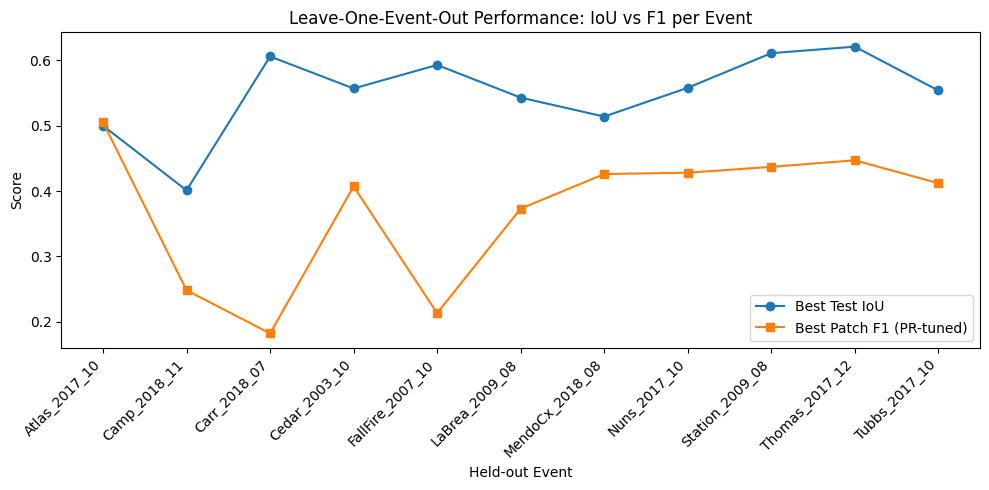

In [ ]:
import matplotlib.pyplot as plt

events = [
    "Atlas_2017_10",
    "Camp_2018_11",
    "Carr_2018_07",
    "Cedar_2003_10",
    "FallFire_2007_10",
    "LaBrea_2009_08",
    "MendoCx_2018_08",
    "Nuns_2017_10",
    "Station_2009_08",
    "Thomas_2017_12",
    "Tubbs_2017_10",
]

best_iou = [0.500, 0.401, 0.606, 0.557, 0.593, 0.543, 0.514, 0.558, 0.611, 0.621, 0.554]
best_f1  = [0.505, 0.248, 0.182, 0.407, 0.213, 0.373, 0.426, 0.428, 0.437, 0.447, 0.412]

x = range(len(events))

plt.figure(figsize=(10, 5))
plt.plot(x, best_iou, marker="o", label="Best Test IoU")
plt.plot(x, best_f1, marker="s", label="Best Patch F1 (PR-tuned)")
plt.xticks(x, events, rotation=45, ha="right")
plt.xlabel("Held-out Event")
plt.ylabel("Score")
plt.title("Leave-One-Event-Out Performance: IoU vs F1 per Event")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!ls -lh /content/patches32_balanced


In [ ]:
import nbformat as nbf
from pathlib import Path

# 🔧 1) Set the path to your original notebook file
# If it's in the same folder as this notebook in Colab: upload it via the file sidebar and use that name.
in_path = Path("Copy of wildfire_model_fixed_clean.ipynb")  # <- change if your file name is different

# 🔧 2) Name for the cleaned notebook
out_path = Path("wildfire_model_fixed_clean_github.ipynb")

# --- Load the notebook as nbformat object (v4 is standard) ---
nb = nbf.read(in_path, as_version=4)

print("Top-level metadata keys BEFORE:", list(nb.metadata.keys()))

# --- Remove top-level widgets metadata if present ---
if "widgets" in nb.metadata:
    print("Removing nb.metadata['widgets']")
    del nb.metadata["widgets"]

# --- Also clean widgets metadata from cells, just in case ---
for i, cell in enumerate(nb.cells):
    md = cell.get("metadata", {})
    if "widgets" in md:
        print(f"Removing cell[{i}].metadata['widgets']")
        del md["widgets"]
        cell["metadata"] = md

print("Top-level metadata keys AFTER:", list(nb.metadata.keys()))

# --- Write cleaned notebook ---
nbf.write(nb, out_path)
print("✅ Wrote cleaned notebook to:", out_path)


FileNotFoundError: [Errno 2] No such file or directory: 'Copy of wildfire_model_fixed_clean.ipynb'

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize_patches_on_burn(
    evm,
    burn,
    patch_size=PATCH_SIZE,
    stride=PATCH_STRIDE,
    min_burned_frac=MIN_BURNED_FRAC,
    near_radius=NEAR_RADIUS,
    max_patches_to_draw=300,
):
    """
    Show where patches are cut from on the MODIS burned area map.
    Draws red boxes = burned-containing patches,
           blue boxes = nearby-unburned patches.
    """

    bands, H, W = evm.shape
    burn_bin = (burn > 0).astype(np.uint8)

    if burn_bin.sum() == 0:
        print("No burned pixels in this event; nothing to visualize.")
        return

    # Distance transform: distance to nearest burned pixel
    dist = distance_transform_edt(1 - burn_bin)
    near_mask = (dist > 0) & (dist <= near_radius)

    burned_boxes = []
    unburned_boxes = []

    for row in range(0, H - patch_size + 1, stride):
        for col in range(0, W - patch_size + 1, stride):
            burn_patch = burn_bin[row:row+patch_size, col:col+patch_size]
            if burn_patch.shape != (patch_size, patch_size):
                continue

            mask_patch = burn_patch.astype(np.uint8)
            frac_burned = mask_patch.mean()

            if frac_burned >= min_burned_frac:
                burned_boxes.append((row, col))
            else:
                # nearby-unburned
                near_patch = near_mask[row:row+patch_size, col:col+patch_size].any()
                if near_patch:
                    unburned_boxes.append((row, col))

    print(
        f"Found {len(burned_boxes)} burned patches and "
        f"{len(unburned_boxes)} nearby-unburned patches."
    )

    # Maybe subsample for plotting so it doesn't get too cluttered
    def subsample(boxes, max_n):
        if len(boxes) <= max_n:
            return boxes
        idx = np.random.choice(len(boxes), max_n, replace=False)
        return [boxes[i] for i in idx]

    burned_boxes = subsample(burned_boxes, max_patches_to_draw)
    unburned_boxes = subsample(unburned_boxes, max_patches_to_draw)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("MODIS burned area with patch footprints")
    im = ax.imshow(burn_bin, cmap="gray")
    fig.colorbar(im, ax=ax, label="Burned (1) / Unburned (0)")

    # red for burned-containing patches
    for (row, col) in burned_boxes:
        rect = Rectangle(
            (col, row), patch_size, patch_size,
            linewidth=1, edgecolor="red", facecolor="none", alpha=0.7
        )
        ax.add_patch(rect)

    # blue for nearby-unburned patches
    for (row, col) in unburned_boxes:
        rect = Rectangle(
            (col, row), patch_size, patch_size,
            linewidth=1, edgecolor="cyan", facecolor="none", alpha=0.7
        )
        ax.add_patch(rect)

    ax.set_xlabel("X (columns)")
    ax.set_ylabel("Y (rows)")
    plt.show()


Cedar_2003_10 2003 10
Already exists: /content/evm_patches_data/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
Already exists: /content/evm_patches_data/Burned_Cedar_2003_10_2003-10_EPSG5070_500m.tif
✅ EVM & Burn rasters already aligned.
Found 71 burned patches and 43 nearby-unburned patches.


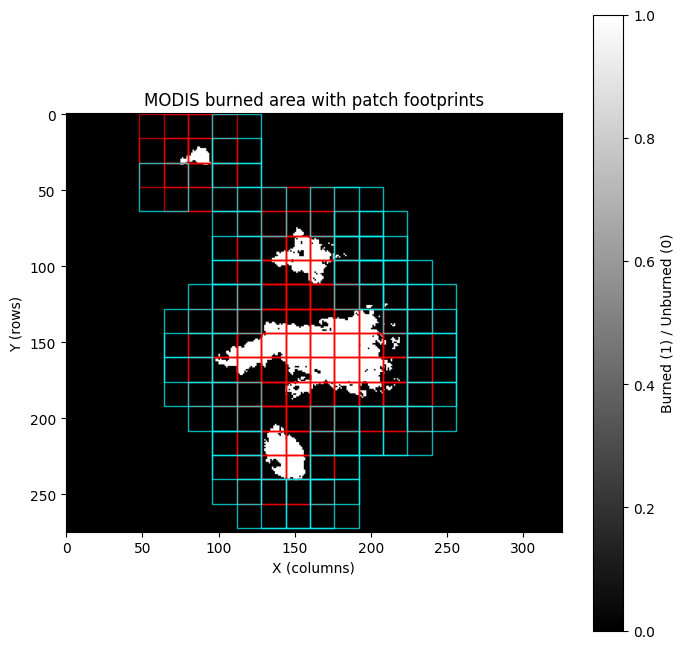

In [ ]:
# Example: visualize for the first event only
name, year, month = events[0]
print(name, year, month)

evm_gs = evm_gs_path(name, year, month)
burn_gs = burn_gs_path(name, year, month)

evm_local = gsutil_cp(evm_gs)
burn_local = gsutil_cp(burn_gs)

evm, burn, meta = load_aligned_evm_burn(evm_local, burn_local)

visualize_patches_on_burn(evm, burn)


zip all files together

In [ ]:
PATCH_OUT_DIR = "/content/evm_patches_npz"
ZIP_PATH = "/content/unet_patches32_stride16.zip"

# Zip the whole directory
!zip -r "$ZIP_PATH" "$PATCH_OUT_DIR"


  adding: content/evm_patches_npz/ (stored 0%)
  adding: content/evm_patches_npz/Camp_2018_11_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Nuns_2017_10_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Carr_2018_07_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Atlas_2017_10_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Cedar_2003_10_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Thomas_2017_12_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/MendoCx_2018_08_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Tubbs_2017_10_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/Station_2009_08_patches.npz (deflated 3%)
  adding: content/evm_patches_npz/FallFire_2007_10_patches.npz (deflated 4%)
  adding: content/evm_patches_npz/LaBrea_2009_08_patches.npz (deflated 4%)


IMports


In [ ]:
# ============================================
# 0. Imports & config
# ============================================
import os, glob, random, math
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PATCH_OUT_DIR = "/content/evm_patches_npz"
BATCH_SIZE = 16
EPOCHS = 50
PATIENCE = 5      # early stopping patience
VAL_FRAC = 0.1    # fraction of training patches used as validation
LEARNING_RATE = 1e-3

# ============================================
# 1. Utility: load patches and handle NaNs
# ============================================
def load_patches_from_files(files, add_missing_mask=True):
    """
    files: list of .npz paths
    add_missing_mask: if True, concatenates per-band validity mask as extra channels.
                      X_out shape: (N, 2*C, H, W) (env + mask)
                      Y_out shape: (N, 1, H, W)
    """
    X_list, Y_list, event_names = [], [], []

    for f in files:
        data = np.load(f, allow_pickle=True)
        X = data["X"]   # (N, C, H, W) with NaNs in environmental channels
        Y = data["Y"]   # (N, 1, H, W)
        meta = data["meta"].item()
        event_name = meta["event_name"]

        X_list.append(X)
        Y_list.append(Y)
        event_names.extend([event_name] * X.shape[0])

    X_all = np.concatenate(X_list, axis=0)   # (N_total, C, H, W)
    Y_all = np.concatenate(Y_list, axis=0)

    # ---- build validity mask BEFORE filling ----
    # True where missing; False where valid
    missing_mask = np.isnan(X_all)
    valid_mask = (~missing_mask).astype(np.float32)  # 1 = real, 0 = missing

    # ---- replace NaNs/inf with 0 so PyTorch is happy ----
    X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)

    if add_missing_mask:
        # concatenate along channel dimension: (N, C, H, W) -> (N, 2C, H, W)
        X_all = np.concatenate([X_all, valid_mask], axis=1)

    return X_all, Y_all, event_names


# ============================================
# 2. Dataset with normalization + augmentation
# ============================================
class FirePatchDataset(Dataset):
    def __init__(self, X, Y,
                 band_mean_env=None, band_std_env=None,
                 normalize=True, augment=False,
                 num_env_channels=None):
        """
        X: np.ndarray (N, C_total, H, W) where:
           - first C_env channels = environmental variables
           - last C_env channels  = validity mask (0/1)
        Y: np.ndarray (N, 1, H, W) burned mask (0/1)
        """
        assert X.shape[0] == Y.shape[0]
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)

        self.normalize = normalize
        self.augment = augment

        # how many channels are "real env" (rest are mask)
        self.C_total = self.X.shape[1]
        if num_env_channels is None:
            self.C_env = self.C_total // 2
        else:
            self.C_env = num_env_channels

        # band-wise stats for env channels only
        if self.normalize:
            if band_mean_env is None or band_std_env is None:
                # compute from this X (env channels only)
                N, C_tot, H, W = self.X.shape
                X_env = self.X[:, :self.C_env]                  # (N, C_env, H, W)
                Xr = X_env.reshape(N, self.C_env, -1)           # (N, C_env, H*W)
                self.band_mean_env = np.nanmean(Xr, axis=(0, 2))
                self.band_std_env  = np.nanstd(Xr, axis=(0, 2)) + 1e-6
            else:
                self.band_mean_env = np.array(band_mean_env)
                self.band_std_env  = np.array(band_std_env) + 1e-6
        else:
            self.band_mean_env = None
            self.band_std_env  = None

    def __len__(self):
        return self.X.shape[0]

    def _augment(self, x, y):
        """
        x: (C_tot, H, W)
        y: (1, H, W)
        Apply spatial transforms and small noise to env channels only.
        """
        # flips
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[2])  # horizontal flip (W axis)
            y = torch.flip(y, dims=[2])
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[1])  # vertical flip (H axis)
            y = torch.flip(y, dims=[1])

        # rotations 0, 90, 180, 270
        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            x = torch.rot90(x, k, dims=[1, 2])
            y = torch.rot90(y, k, dims=[1, 2])

        # small Gaussian noise on env channels only
        if torch.rand(1) < 0.5:
            x_env = x[:self.C_env]
            x_mask = x[self.C_env:]
            x_env = x_env + 0.01 * torch.randn_like(x_env)
            x = torch.cat([x_env, x_mask], dim=0)

        return x, y

    def __getitem__(self, idx):
        x = self.X[idx].copy()   # (C_tot, H, W)
        y = self.Y[idx].copy()   # (1, H, W)

        # normalize env channels only
        if self.normalize:
            env = x[:self.C_env]         # (C_env, H, W)
            mask = x[self.C_env:]        # (C_env, H, W)
            mean = self.band_mean_env[:, None, None]
            std  = self.band_std_env[:, None, None]
            env = (env - mean) / std
            x = np.concatenate([env, mask], axis=0)

        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        if self.augment:
            x, y = self._augment(x, y)

        return x, y


# ============================================
# 3. U-Net model (standard-ish, but lightweight)
# ============================================
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels, base_ch=64):
        super().__init__()

        self.down1 = DoubleConv(in_channels, base_ch)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(base_ch*4, base_ch*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_ch*8, base_ch*16)

        self.up4 = nn.ConvTranspose2d(base_ch*16, base_ch*8, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(base_ch*16, base_ch*8)

        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(base_ch*8, base_ch*4)

        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(base_ch*4, base_ch*2)

        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(base_ch*2, base_ch)

        self.final = nn.Conv2d(base_ch, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        c4 = self.down4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c5 = self.dec4(u4)

        u3 = self.up3(c5)
        u3 = torch.cat([u3, c3], dim=1)
        c6 = self.dec3(u3)

        u2 = self.up2(c6)
        u2 = torch.cat([u2, c2], dim=1)
        c7 = self.dec2(u2)

        u1 = self.up1(c7)
        u1 = torch.cat([u1, c1], dim=1)
        c8 = self.dec1(u1)

        logits = self.final(c8)   # (B,1,H,W)
        return logits


# ============================================
# 4. Loss & metrics
# ============================================
def dice_loss(logits, targets, eps=1e-6):
    """
    logits: (B,1,H,W)
    targets: (B,1,H,W) in {0,1}
    """
    probs = torch.sigmoid(logits)
    probs = probs.view(probs.size(0), -1)
    targets = targets.view(targets.size(0), -1)

    intersection = (probs * targets).sum(dim=1)
    union = probs.sum(dim=1) + targets.sum(dim=1)
    dice = (2 * intersection + eps) / (union + eps)
    return 1.0 - dice.mean()

def compute_segmentation_metrics(logits, targets, threshold=0.5, eps=1e-6):
    """
    logits, targets: (B,1,H,W)
    returns dict of aggregate metrics over the batch
    """
    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()

        y_true = targets.view(-1)
        y_pred = preds.view(-1)

        tp = (y_true * y_pred).sum()
        fp = ((1 - y_true) * y_pred).sum()
        fn = (y_true * (1 - y_pred)).sum()
        tn = ((1 - y_true) * (1 - y_pred)).sum()

        dice = (2*tp + eps) / (2*tp + fp + fn + eps)
        iou  = (tp + eps) / (tp + fp + fn + eps)
        acc  = (tp + tn + eps) / (tp + tn + fp + fn + eps)
        prec = (tp + eps) / (tp + fp + eps)
        rec  = (tp + eps) / (tp + fn + eps)

    return {
        "dice": dice.item(),
        "iou": iou.item(),
        "accuracy": acc.item(),
        "precision": prec.item(),
        "recall": rec.item(),
    }


# ============================================
# 5. Prepare file list (one .npz per event)
# ============================================
npz_files = sorted(glob.glob(os.path.join(PATCH_OUT_DIR, "*_patches.npz")))
assert len(npz_files) > 0, "No patch files found in PATCH_OUT_DIR"

print("Found patch files:")
for f in npz_files:
    print("  ", os.path.basename(f))

# peek to get number of bands (env channels)
tmp = np.load(npz_files[0], allow_pickle=True)
C_env = tmp["X"].shape[1]
print("\nEnvironmental bands per patch:", C_env)
del tmp


# ============================================
# 6. Leave-one-event-out cross-validation
# ============================================
fold_results = []

for fold_idx, held_out_file in enumerate(npz_files):
    held_out_name = os.path.basename(held_out_file)
    print("\n" + "="*70)
    print(f"FOLD {fold_idx+1}/{len(npz_files)} - Held-out event: {held_out_name}")

    train_files = [f for f in npz_files if f != held_out_file]
    test_files  = [held_out_file]

    # ---------- Load train+val patches ----------
    X_train_all, Y_train_all, train_event_names = load_patches_from_files(
        train_files, add_missing_mask=True
    )
    N_total, C_tot, H, W = X_train_all.shape
    C_env_eff = C_tot // 2
    print(f"Total train patches (all events except held-out): {N_total}")
    print(f"Total channels: {C_tot} (env={C_env_eff}, mask={C_env_eff})")

    # Random train/val split
    idx = np.random.permutation(N_total)
    n_val = max(1, int(VAL_FRAC * N_total))
    val_idx = idx[:n_val]
    train_idx = idx[n_val:]

    X_tr = X_train_all[train_idx]
    Y_tr = Y_train_all[train_idx]
    X_val = X_train_all[val_idx]
    Y_val = Y_train_all[val_idx]

    # ---------- Compute per-band stats on env channels (train only) ----------
    N_tr = X_tr.shape[0]
    Xr_env = X_tr[:, :C_env_eff].reshape(N_tr, C_env_eff, -1)
    band_mean_env = Xr_env.mean(axis=(0, 2))
    band_std_env  = Xr_env.std(axis=(0, 2)) + 1e-6

    # ---------- Class imbalance: compute pos_weight for BCE ----------
    y_flat = Y_tr.reshape(-1)
    pos = y_flat.sum()
    neg = y_flat.size - pos
    if pos == 0:
        pos_weight_value = 1.0
    else:
        pos_weight_value = (neg / (pos + 1e-6)).item()
    print(f"pos_weight (neg/pos) for fold {fold_idx}: {pos_weight_value:.2f}")

    pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
    bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # ---------- Datasets & loaders ----------
    train_ds = FirePatchDataset(
        X_tr, Y_tr,
        band_mean_env=band_mean_env,
        band_std_env=band_std_env,
        normalize=True,
        augment=True,
        num_env_channels=C_env_eff,
    )
    val_ds = FirePatchDataset(
        X_val, Y_val,
        band_mean_env=band_mean_env,
        band_std_env=band_std_env,
        normalize=True,
        augment=False,
        num_env_channels=C_env_eff,
    )

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=2, pin_memory=True)

    # ---------- Model & optimizer ----------
    in_channels = C_tot  # env + mask
    model = UNet(in_channels=in_channels, base_ch=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # ---------- Training loop with early stopping ----------
    best_val_loss = float("inf")
    best_model_state = None
    no_improve = 0

    def run_epoch(loader, train_mode=True):
        if train_mode:
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        count = 0

        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            if train_mode:
                optimizer.zero_grad()

            logits = model(xb)
            loss_bce = bce_loss_fn(logits, yb)
            loss_dice = dice_loss(logits, yb)
            loss = loss_bce + loss_dice

            if train_mode:
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * xb.size(0)
            count += xb.size(0)

        return running_loss / max(1, count)

    for epoch in range(1, EPOCHS + 1):
        train_loss = run_epoch(train_loader, train_mode=True)
        val_loss   = run_epoch(val_loader,   train_mode=False)
        print(f"  Epoch {epoch:02d} | train: {train_loss:.4f} | val: {val_loss:.4f}")

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= PATIENCE:
                print(f"  Early stopping triggered after {epoch} epochs.")
                break

    if best_model_state is None:
        print("WARNING: best_model_state is None; using last epoch weights.")
    else:
        model.load_state_dict(best_model_state)

    # ============================================
    # 7. Evaluation on held-out event (test set)
    # ============================================
    X_test_all, Y_test_all, test_event_names = load_patches_from_files(
        test_files, add_missing_mask=True
    )
    N_te, C_te, H, W = X_test_all.shape
    print(f"Test patches from held-out event: {N_te}")

    # Use SAME normalization stats as training env channels
    test_ds = FirePatchDataset(
        X_test_all, Y_test_all,
        band_mean_env=band_mean_env,
        band_std_env=band_std_env,
        normalize=True,
        augment=False,
        num_env_channels=C_env_eff,
    )
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=2, pin_memory=True)

    model.eval()
    all_metrics = defaultdict(list)

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            batch_metrics = compute_segmentation_metrics(logits, yb, threshold=0.5)

            for k, v in batch_metrics.items():
                all_metrics[k].append(v)

    # Average metrics over batches
    fold_metrics = {k: float(np.mean(v)) for k, v in all_metrics.items()}
    fold_metrics["held_out_event"] = held_out_name
    fold_metrics["best_val_loss"] = best_val_loss

    fold_results.append(fold_metrics)

    print("\nFold results for held-out event:", held_out_name)
    for k, v in fold_metrics.items():
        if k not in ["held_out_event"]:
            print(f"  {k}: {v:.4f}")


# ============================================
# 8. Summary over folds
# ============================================
print("\n" + "#"*70)
print("CROSS-VALIDATION SUMMARY (leave-one-event-out)")
for fr in fold_results:
    print("\nEvent:", fr["held_out_event"])
    print(f"  best_val_loss: {fr['best_val_loss']:.4f}")
    print(f"  dice:          {fr['dice']:.4f}")
    print(f"  iou:           {fr['iou']:.4f}")
    print(f"  accuracy:      {fr['accuracy']:.4f}")
    print(f"  precision:     {fr['precision']:.4f}")
    print(f"  recall:        {fr['recall']:.4f}")

# Overall mean Dice/IoU across folds
mean_dice = np.mean([fr["dice"] for fr in fold_results])
mean_iou  = np.mean([fr["iou"]  for fr in fold_results])
print("\nMean Dice over folds:", round(mean_dice, 4))
print("Mean IoU  over folds:", round(mean_iou, 4))


Using device: cuda
Found patch files:
   Atlas_2017_10_patches.npz
   Camp_2018_11_patches.npz
   Carr_2018_07_patches.npz
   Cedar_2003_10_patches.npz
   FallFire_2007_10_patches.npz
   LaBrea_2009_08_patches.npz
   MendoCx_2018_08_patches.npz
   Nuns_2017_10_patches.npz
   Station_2009_08_patches.npz
   Thomas_2017_12_patches.npz
   Tubbs_2017_10_patches.npz

Environmental bands per patch: 83

FOLD 1/11 - Held-out event: Atlas_2017_10_patches.npz
Total train patches (all events except held-out): 908
Total channels: 166 (env=83, mask=83)
pos_weight (neg/pos) for fold 0: 6.24
  Epoch 01 | train: 1.7801 | val: 1.7502
  Epoch 02 | train: 1.6673 | val: 1.7921
  Epoch 03 | train: 1.6514 | val: 1.7248
  Epoch 04 | train: 1.6105 | val: 1.6799
  Epoch 05 | train: 1.6152 | val: 1.7168
  Epoch 06 | train: 1.5799 | val: 1.7126
  Epoch 07 | train: 1.5500 | val: 1.9305
  Epoch 08 | train: 1.5047 | val: 1.7599
  Epoch 09 | train: 1.5563 | val: 1.7533
  Early stopping triggered after 9 epochs.
Test 

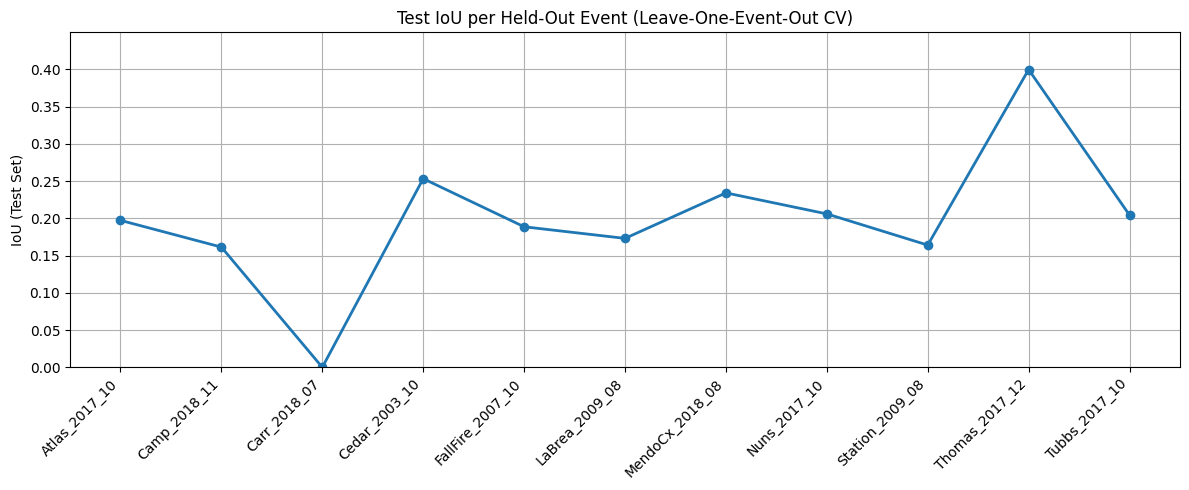

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# IoU values from your results (in event order)
events = [
    "Atlas_2017_10",
    "Camp_2018_11",
    "Carr_2018_07",
    "Cedar_2003_10",
    "FallFire_2007_10",
    "LaBrea_2009_08",
    "MendoCx_2018_08",
    "Nuns_2017_10",
    "Station_2009_08",
    "Thomas_2017_12",
    "Tubbs_2017_10",
]

ious = np.array([
    0.1973,
    0.1614,
    0.0000,
    0.2533,
    0.1887,
    0.1731,
    0.2342,
    0.2060,
    0.1641,
    0.3998,
    0.2043,
])

plt.figure(figsize=(12, 5))
plt.plot(events, ious, marker='o', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.ylabel("IoU (Test Set)")
plt.title("Test IoU per Held-Out Event (Leave-One-Event-Out CV)")
plt.grid(True)
plt.ylim(0, max(ious) + 0.05)
plt.tight_layout()
plt.show()


In [ ]:
import os, glob
import numpy as np

PATCH_OUT_DIR = "/content/evm_patches_npz"
npz_files = sorted(glob.glob(os.path.join(PATCH_OUT_DIR, "*_patches.npz")))

for f in npz_files:
    data = np.load(f, allow_pickle=True)
    X = data["X"]   # (N, C, H, W)
    meta = data["meta"].item()
    event_name = meta["event_name"]
    N, C, H, W = X.shape
    total_pixels_per_band = N * H * W

    # count NaNs per band
    X_reshaped = X.reshape(N, C, -1)        # (N, C, H*W)
    nan_counts = np.isnan(X_reshaped).sum(axis=(0, 2))   # (C,)

    nan_frac = nan_counts / total_pixels_per_band  # fraction per band

    print("Event:", event_name, "| file:", os.path.basename(f))
    print("  Total pixels per band:", total_pixels_per_band)
    print("  Bands with any NaNs:", np.where(nan_counts > 0)[0])
    print("  Bands completely NaN:", np.where(nan_counts == total_pixels_per_band)[0])
    print("  Example nan_frac for first 10 bands:", nan_frac[:10])
    print("-" * 60)


Event: Atlas_2017_10 | file: Atlas_2017_10_patches.npz
  Total pixels per band: 54272
  Bands with any NaNs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 82]
  Bands completely NaN: []
  Example nan_frac for first 10 bands: [0.19475973 0.19475973 0.19475973 0.19475973 0.19475973 0.19475973
 0.19475973 0.19475973 0.19475973 0.19475973]
------------------------------------------------------------
Event: Camp_2018_11 | file: Camp_2018_11_patches.npz
  Total pixels per band: 69632
  Bands with any NaNs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 82]
  Bands completely NaN: []
  Example nan_f

In [ ]:
import os, glob
import numpy as np

PATCH_OUT_DIR = "/content/evm_patches_npz"
npz_files = sorted(glob.glob(os.path.join(PATCH_OUT_DIR, "*_patches.npz")))

for f in npz_files:
    data = np.load(f, allow_pickle=True)
    X = data["X"]   # (N, C, H, W)
    meta = data["meta"].item()
    event_name = meta["event_name"]
    N, C, H, W = X.shape
    total_pixels_per_band = N * H * W

    # count NaNs per band
    X_reshaped = X.reshape(N, C, -1)        # (N, C, H*W)
    nan_counts = np.isnan(X_reshaped).sum(axis=(0, 2))   # (C,)

    nan_frac = nan_counts / total_pixels_per_band  # fraction per band

    print("Event:", event_name, "| file:", os.path.basename(f))
    print("  Total pixels per band:", total_pixels_per_band)
    print("  Bands with any NaNs:", np.where(nan_counts > 0)[0])
    print("  Bands completely NaN:", np.where(nan_counts == total_pixels_per_band)[0])
    print("  Example nan_frac for first 10 bands:", nan_frac[:10])
    print("-" * 60)


Event: Atlas_2017_10 | file: Atlas_2017_10_patches.npz
  Total pixels per band: 54272
  Bands with any NaNs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 82]
  Bands completely NaN: []
  Example nan_frac for first 10 bands: [0.19475973 0.19475973 0.19475973 0.19475973 0.19475973 0.19475973
 0.19475973 0.19475973 0.19475973 0.19475973]
------------------------------------------------------------
Event: Camp_2018_11 | file: Camp_2018_11_patches.npz
  Total pixels per band: 69632
  Bands with any NaNs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 82]
  Bands completely NaN: []
  Example nan_f



*   List item

*   List item
*   List item


*   List item



pacth extraction

More export of evms with more features

In [ ]:
import ee
ee.Initialize(project='california-fire-model')  # if not already initialized

tasks = ee.batch.Task.list()
for t in tasks:
    s = t.status()
    desc = s.get('description')
    state = s.get('state')

    # Only touch EVM tasks
    if desc and desc.startswith('EVMx_'):
        if state in ('READY', 'RUNNING', 'FAILED', 'CANCELLED'):
            print(f"🔪 Cancelling old EVM task: {desc} | state={state}")
            try:
                t.cancel()
            except Exception as e:
                print("  (could not cancel, but that's ok)", e)


🔪 Cancelling old EVM task: EVMx_MendoCx_2018_08_2018-08_prev_2018-07_EPSG5070_500m | state=READY
🔪 Cancelling old EVM task: EVMx_Carr_2018_07_2018-07_prev_2018-06_EPSG5070_500m | state=READY
🔪 Cancelling old EVM task: EVMx_Camp_2018_11_2018-11_prev_2018-10_EPSG5070_500m | state=READY
🔪 Cancelling old EVM task: EVMx_Nuns_2017_10_2017-10_prev_2017-09_EPSG5070_500m | state=READY
🔪 Cancelling old EVM task: EVMx_Tubbs_2017_10_2017-10_prev_2017-09_EPSG5070_500m | state=READY
🔪 Cancelling old EVM task: EVMx_Atlas_2017_10_2017-10_prev_2017-09_EPSG5070_500m | state=READY
🔪 Cancelling old EVM task: EVMx_Thomas_2017_12_2017-12_prev_2017-11_EPSG5070_500m | state=RUNNING
🔪 Cancelling old EVM task: EVMx_FallFire_2007_10_2007-10_prev_2007-09_EPSG5070_500m | state=RUNNING
🔪 Cancelling old EVM task: EVMx_LaBrea_2009_08_2009-08_prev_2009-07_EPSG5070_500m | state=CANCELLED
🔪 Cancelling old EVM task: EVMx_MendoCx_2018_08_2018-08_prev_2018-07_EPSG5070_500m | state=FAILED
🔪 Cancelling old EVM task: EVMx_Car

In [ ]:
# ✅ One-and-done: EE auth + burned-mask exports (EPSG:5070 @ 500 m)

!pip -q install -U earthengine-api geemap

import os, subprocess, pathlib
import ee

PROJECT_ID = "california-fire-model"

# ---- Robust EE init for Colab ----
def ee_bootstrap():
    try:
        ee.Initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE already initialized.")
        return
    except Exception as e:
        print("[init] Need to authenticate:", e)

    try:
        import geemap
        geemap.ee_initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE initialized via geemap.")
        return
    except Exception as e:
        print("[geemap] init failed:", e)

    try:
        from google.colab import auth as colab_auth
        print("[colab] Authenticating user for ADC...")
        colab_auth.authenticate_user()
        ee.Initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE initialized via Colab ADC.")
        return
    except Exception as e:
        print("[colab ADC] failed:", e)

    try:
        print("[cli] Running: earthengine authenticate --quiet")
        r = subprocess.run(["earthengine", "authenticate", "--quiet"],
                           text=True, capture_output=True)
        print(r.stdout or "")
        if r.returncode != 0:
            print(r.stderr or "")
            raise RuntimeError("CLI auth failed")
        ee.Initialize(project=PROJECT_ID)
        ee.Number(1).getInfo()
        print("✅ EE initialized via CLI.")
        return
    except Exception as e:
        raise RuntimeError(
            "Earth Engine auth failed. Enable pop-ups/third-party cookies, "
            "ensure correct Google account, then re-run this cell."
        ) from e

ee_bootstrap()

# ---- Use existing events / helpers if present, else define ----
if 'events' not in globals():
    events = [
        ("Cedar_2003_10", ["San Diego"],                (2003, 10)),
        ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
        ("Station_2009_08", ["Los Angeles"],            (2009, 8)),
        ("LaBrea_2009_08",  ["Santa Barbara"],          (2009, 8)),
        ("Thomas_2017_12",  ["Ventura","Santa Barbara"],(2017, 12)),
        ("Atlas_2017_10",   ["Napa"],                   (2017, 10)),
        ("Tubbs_2017_10",   ["Napa","Sonoma"],          (2017, 10)),
        ("Nuns_2017_10",    ["Sonoma"],                 (2017, 10)),
        ("Camp_2018_11",    ["Butte"],                  (2018, 11)),
        ("Carr_2018_07",    ["Shasta","Trinity"],       (2018, 7)),
        ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"], (2018, 8)),
    ]

if 'aoi_from_counties' not in globals():
    STATE_CA = '06'
    COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
        ee.Filter.eq('STATEFP', STATE_CA)
    )
    def aoi_from_counties(names):
        fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
        return ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()

# ---- Burned-mask export (MCD64A1 → Byte 0/1, EPSG:5070 @ 500 m) ----
SCALE = 500
CRS   = 'EPSG:5070'  # match EVM13 grid & prof guidance
BUCKET = 'california-fire-model'
if 'INCLUDE_NEXT_MONTH' not in globals():
    INCLUDE_NEXT_MONTH = True  # keep in sync with your EVM exports

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def burned_image(start, end, region):
    """
    Build a binary burned mask for [start,end), reprojected to EPSG:5070 @ 500 m,
    clipped to the AOI. Values: 1 = burned, 0 = unburned.
    """
    burn = (ee.ImageCollection('MODIS/061/MCD64A1')
            .filterDate(start, end)
            .select('BurnDate')
            .max()          # any burn in the month
            .gt(0)          # burned → 1; unburned → 0
            .unmask(0)      # outside footprint → 0
            .rename('burn')
            .toByte())

    # Reproject BEFORE export so map previews look correct; export also pins CRS/scale.
    return burn.reproject(crs=CRS, scale=SCALE).clip(region)

FILE_PREFIX_FMT = "burned_events/{name}/Burned_{name}_{ym}_EPSG5070_500m"

for name, counties, (yr, mo) in events:
    aoi = aoi_from_counties(counties)

    # Event month
    ym   = f"{yr}-{mo:02d}"
    desc = f"Burned_{name}_{ym}_EPSG5070_500m"
    ee.batch.Export.image.toCloudStorage(
        image=burned_image(*month_range(yr, mo), aoi),
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=FILE_PREFIX_FMT.format(name=name, ym=ym),
        region=aoi,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    ).start()
    print(f"🚀 Burned export: {desc}")

    # Next month (optional)
    if INCLUDE_NEXT_MONTH:
        mo2 = 1 if mo == 12 else mo + 1
        yr2 = yr + 1 if mo == 12 else yr
        ym2   = f"{yr2}-{mo2:02d}"
        desc2 = f"Burned_{name}_next_{ym2}_EPSG5070_500m"
        ee.batch.Export.image.toCloudStorage(
            image=burned_image(*month_range(yr2, mo2), aoi),
            description=desc2,
            bucket=BUCKET,
            fileNamePrefix=FILE_PREFIX_FMT.format(name=f"{name}_next", ym=ym2),
            region=aoi,
            scale=SCALE,
            crs=CRS,
            maxPixels=1e13
        ).sx
# (Optional) quick sanity: confirm projection info on one sample image
name, counties, (yr, mo) = events[0]
sample_img = burned_image(*month_range(yr, mo), aoi_from_counties(counties))
print("Projection check:", sample_img.projection().getInfo())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.2/463.2 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.5/631.5 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
✅ EE already initialized.
🚀 Burned export: Burned_Cedar_2003_10_2003-10_EPSG5070_500m
🚀 Burned export: Burned_Cedar_2003_10_next_2003-11_EPSG5070_500m
🚀 Burned export: Burned_FallFire_2007_10_2007-10_EPSG5070_500m
🚀 Burned export: Burned_FallFire_2007_10_next_2007-11_EPSG5070_500m
🚀 Burned export: Burned_Station_2009_08_2009-08_EPSG5070_500m
🚀 Burned export: Burned_Station_2009_08_next_2009-09_EPSG5070_500m
🚀 Burned export: Burned_LaBrea_2009_08_2009-08_EPSG5070_500m
🚀 Burned export: Burned_LaBrea_2009_08_next_2009-09_EPSG5070_500m
🚀 Burned export: Burned_Thomas_2017_12_2017-12_EPSG5070_500m
🚀 Burned export: Burned_Thomas_2017_12_next_2018-01_EPSG5070_500m
🚀 Burned export: Burned_Atlas_2017_10_2017-10_EPSG5070_500m
🚀 Burned export: Burned_Atlas_2017_1

new one

In [ ]:
# Re-run LaBrea only
fire_name = "LaBrea_2009_08"
fire_year, fire_month = 2009, 8
counties = ["Santa Barbara"]

region = aoi_from_counties(counties)
export_prev_month_evm(
    fire_name=fire_name,
    fire_year=fire_year,
    fire_month=fire_month,
    region=region
)


🚀 Started EVM export for LaBrea_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/LaBrea_2009_08/EVMx_LaBrea_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif


In [ ]:
# ✅ Burned-mask exports (EPSG:5070 @ 500 m) — buffer(0) fix applied

!pip -q install -U earthengine-api geemap

import ee, geemap, math, subprocess
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# -------------------------
# Events (same as your list)
# -------------------------
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# -------------------------
# AOI helpers (FIX: no 0-error buffer)
# -------------------------
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # Heal small slivers with a non-zero maxError, then simplify and bound
    geom = geom.buffer(0, 100)   # <- 100 m tolerance avoids "0 error margin" crash
    geom = geom.simplify(100)    # <- keep geometry lightweight
    return geom.bounds(1000)     # <- stable export extent

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

# -------------------------
# Config
# -------------------------
SCALE = 500
CRS   = 'EPSG:5070'  # match features
BUCKET = 'california-fire-model'
INCLUDE_NEXT_MONTH = True  # keep consistent with your features/labels logic

# -------------------------
# Burned mask builder
# -------------------------
def burned_image(start, end, region, strict_month=False):
    """
    Binary burned mask for [start,end) using MODIS MCD64A1.
    1 = burned, 0 = unburned. Reprojected to 5070 @ 500m and clipped to AOI.
    strict_month=False uses the monthly image for that month (recommended).
    If strict_month=True, additionally constrains BurnDate by DOY window.
    """
    ic = (ee.ImageCollection('MODIS/061/MCD64A1')
          .filterDate(start, end)
          .select('BurnDate'))

    burnDate = ic.max()

    if strict_month:
        doy_start = ee.Number(start.getRelative('day', 'year')).add(1)
        doy_end   = ee.Number(end.getRelative('day', 'year'))
        same_year = start.format('YYYY').equals(end.format('YYYY'))
        mask_same = burnDate.gte(doy_start).And(burnDate.lte(doy_end))
        mask_wrap = burnDate.gte(doy_start).Or(burnDate.lte(doy_end))
        mask = ee.Image(ee.Algorithms.If(same_year, mask_same, mask_wrap))
        burned = burnDate.updateMask(mask).gt(0)
    else:
        burned = burnDate.gt(0)

    burn = (burned
            .unmask(0)
            .rename('burn')
            .toByte())

    return burn.reproject(crs=CRS, scale=SCALE).clip(region)

FILE_PREFIX_FMT = "burned_events/{name}/Burned_{name}_{ym}_EPSG5070_500m"

def next_month_year(year, month):
    return (year + 1, 1) if month == 12 else (year, month + 1)

# -------------------------
# Exports
# -------------------------
for name, counties, (yr, mo) in events:
    aoi = aoi_from_counties(counties)

    ym   = f"{yr}-{mo:02d}"
    desc = f"Burned_{name}_{ym}_EPSG5070_500m"
    task = ee.batch.Export.image.toCloudStorage(
        image=burned_image(*month_range(yr, mo), aoi, strict_month=False),
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=FILE_PREFIX_FMT.format(name=name, ym=ym),
        region=aoi,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Burned export: {desc}  | task_id={task.id}")

    if INCLUDE_NEXT_MONTH:
        ny, nm = next_month_year(yr, mo)
        ym2   = f"{ny}-{nm:02d}"
        desc2 = f"Burned_{name}_next_{ym2}_EPSG5070_500m"
        task2 = ee.batch.Export.image.toCloudStorage(
            image=burned_image(*month_range(ny, nm), aoi, strict_month=False),
            description=desc2,
            bucket=BUCKET,
            fileNamePrefix=FILE_PREFIX_FMT.format(name=f"{name}_next", ym=ym2),
            region=aoi,
            scale=SCALE,
            crs=CRS,
            maxPixels=1e13
        )
        task2.start()
        print(f"🚀 Burned export: {desc2}  | task_id={task2.id}")

# -------------------------
# (Optional) quick sanity
# -------------------------
nm, counties, (yr, mo) = events[0]
proj = burned_image(*month_range(yr, mo), aoi_from_counties(counties)).projection().getInfo()
print("Projection check:", proj)


🚀 Burned export: Burned_Cedar_2003_10_2003-10_EPSG5070_500m  | task_id=CHVYW3LMINFZDETRURBSPU2W
🚀 Burned export: Burned_Cedar_2003_10_next_2003-11_EPSG5070_500m  | task_id=F6WUP6ZXJZAIA7VTJRWH354W
🚀 Burned export: Burned_FallFire_2007_10_2007-10_EPSG5070_500m  | task_id=QWU4ACBJENC4QLVEOHYQ5ICG
🚀 Burned export: Burned_FallFire_2007_10_next_2007-11_EPSG5070_500m  | task_id=JU6AXQFJVZNVNRLP2IVNYJSM
🚀 Burned export: Burned_Station_2009_08_2009-08_EPSG5070_500m  | task_id=JP2QB7EFHILFXO2A5NQXCALC
🚀 Burned export: Burned_Station_2009_08_next_2009-09_EPSG5070_500m  | task_id=A4TWOQXXGY4JT2R3NHKMEYZG
🚀 Burned export: Burned_LaBrea_2009_08_2009-08_EPSG5070_500m  | task_id=QH2PYHCVEN5DHEOCIX5SG6DC
🚀 Burned export: Burned_LaBrea_2009_08_next_2009-09_EPSG5070_500m  | task_id=VT7Z5AJLGXTDQKRW5ZL2JHVS
🚀 Burned export: Burned_Thomas_2017_12_2017-12_EPSG5070_500m  | task_id=JJIQARP2BRB74IJH2YKOTFET
🚀 Burned export: Burned_Thomas_2017_12_next_2018-01_EPSG5070_500m  | task_id=QCO5GTPI2AD5DMB73MHMFJVY
🚀

True Satellite image of MOdis MCD64A1 PROduct for many california fire events.

In [ ]:
# This cell was a failed training attempt.

In [ ]:
# --- Patch extraction (64x64 / stride 32) using prev-month EVMs + MODIS burned mask ---
# Positives: strictly inside MODIS burned mask; Negatives: unburned (near-ring + background)
# Writes: /content/patches_from_prevEVM_bal_clean/index.csv and per-event folders with .npz tiles

!pip -q install google-cloud-storage rasterio pandas numpy scipy tqdm pyproj pillow

from google.colab import auth
auth.authenticate_user()

import os, math, random, shutil, re
import numpy as np
import pandas as pd
from google.cloud import storage
from rasterio.io import MemoryFile
import rasterio
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from scipy.ndimage import (
    label as cc_label, binary_closing, binary_dilation, binary_erosion
)
from tqdm import tqdm
from pyproj import Transformer
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
BUCKET      = "california-fire-model"
EVM_PREFIX  = "evms_events/"
BURN_PREFIX = "burned_events/"

OUT_DIR  = "/content/patches_from_prevEVM_bal_clean"
os.makedirs(OUT_DIR, exist_ok=True)

# >>> Key changes you asked for <<<
PATCH_SIZE   = 32       # larger spatial context
STRIDE       = 16       # overlap for coverage
DROP_BORDER  = False     # include edges so burns at image borders are not missed
# <<< ---------------------------- >>>

# Positive selection is purely from burned mask
# (no FRAC/CC requirement—if any burned pixel is inside tile, it's a positive)
# You can tighten if you want later.
POS_REQUIRE_CENTER   = False   # True would force a center mini-window hit
POS_CORE_ERODE_PIX   = 0       # 0 = use cleaned mask as-is

# Negatives: take from near unburned ring (hard negatives) + background unburned
RING_NEG_MIN_PIX  = 2
RING_NEG_MAX_PIX  = 8
BALANCE_PER_EVENT = True       # 1:1 pos:neg per event

# Burn mask cleanup
MIN_BLOB_PX    = 4
DO_CLOSING     = True
CLOSING_STRUCT = np.ones((3,3), bool)
DILATE_PIX     = 0             # dilate burn a bit (0 keeps strict)

# Water/wetlands exclusion via NLCD codes in EVM band 13 (if present / aligned)
NLCD_WATER_CLASSES = {11, 90, 95}
WATER_MAX_FRAC     = 0.02
NODATA_CODE        = -9999

# Random seed
rng = random.Random(1337)

client = storage.Client()

# -----------------------
# GCS + filename parsing
# -----------------------
def list_tifs(prefix):
    return [
        b for b in client.list_blobs(BUCKET, prefix=prefix)
        if b.name.lower().endswith(".tif")
    ]

def open_gcs_tif(blob):
    data = blob.download_as_bytes()
    mem = MemoryFile(data)
    ds  = mem.open()
    return ds, mem

# burned_events/{event}/Burned_{event}_{YYYY-MM}_EPSG5070_500m.tif
burn_re = re.compile(
    r"^burned_events/(?P<event_key>[^/]+)/"
    r"Burned_(?P<event_key2>[^_]+_\d{4}_\d{2})_(?P<fire_ym>\d{4}-\d{2})_EPSG5070_500m\.tif$"
)

def parse_burn_blob_name(blob_name):
    m = burn_re.match(blob_name)
    if not m:
        return None
    return {
        "event_key": m.group("event_key"),
        "fire_ym":   m.group("fire_ym"),
        "blob_name": blob_name
    }

# evms_events/{event}/EVM13_{event}_{fire_ym}_prev_{prev_ym}_EPSG5070_500m.tif
evm_re = re.compile(
    r"^evms_events/(?P<event_key>[^/]+)/"
    r"EVM13_(?P<event_key2>[^/]+)_(?P<fire_ym>\d{4}-\d{2})_prev_(?P<prev_ym>\d{4}-\d{2})_EPSG5070_500m\.tif$"
)

def parse_evm_blob_name(blob_name):
    m = evm_re.match(blob_name)
    if not m:
        return None
    return {
        "event_key": m.group("event_key"),
        "fire_ym":   m.group("fire_ym"),
        "prev_ym":   m.group("prev_ym"),
        "blob_name": blob_name
    }

evm_info_by_event = {}
for b in list_tifs(EVM_PREFIX):
    info = parse_evm_blob_name(b.name)
    if info:
        evm_info_by_event.setdefault(info["event_key"], []).append((info, b))

burn_info_by_event = {}
for b in list_tifs(BURN_PREFIX):
    info = parse_burn_blob_name(b.name)
    if info:
        burn_info_by_event.setdefault(info["event_key"], []).append((info, b))

pairs = []
for event_key in sorted(evm_info_by_event.keys()):
    if event_key not in burn_info_by_event:
        print(f"⚠️ No burned TIFF for {event_key}, skipping.")
        continue
    for evm_meta, evm_blob in evm_info_by_event[event_key]:
        fire_ym = evm_meta["fire_ym"]
        # match on fire_ym
        hit = None
        for burn_meta, burn_blob in burn_info_by_event[event_key]:
            if burn_meta["fire_ym"] == fire_ym:
                hit = (burn_meta, burn_blob)
                break
        if hit is None:
            print(f"⚠️ {event_key}: no burned match for fire_ym={fire_ym}")
            continue
        burn_meta, burn_blob = hit
        pairs.append({
            "event_key": event_key,
            "fire_ym":   fire_ym,
            "prev_ym":   evm_meta["prev_ym"],
            "evm_blob":  evm_blob,
            "burn_blob": burn_blob,
        })

print(f"\nFound {len(pairs)} (EVM_prev ↔ Burn_fire) pairs.\n")

# -----------------------
# Spatial helpers
# -----------------------
def ensure_burn_on_evm_grid(burn_ds, evm_ds):
    same_grid = (
        burn_ds.crs == evm_ds.crs and
        evm_ds.transform.almost_equals(burn_ds.transform) and
        (burn_ds.width  == evm_ds.width) and
        (burn_ds.height == evm_ds.height)
    )
    if same_grid:
        return (burn_ds.read(1) > 0)
    burn_arr = burn_ds.read(1)
    dst = np.zeros((evm_ds.height, evm_ds.width), dtype=np.float32)
    reproject(
        source=burn_arr,
        destination=dst,
        src_transform=burn_ds.transform,
        src_crs=burn_ds.crs,
        dst_transform=evm_ds.transform,
        dst_crs=evm_ds.crs,
        resampling=Resampling.nearest
    )
    return (dst > 0)

def clean_burn_mask(mask_bool, min_blob_px=MIN_BLOB_PX, dilate_iter=DILATE_PIX):
    m = mask_bool
    if DO_CLOSING:
        m = binary_closing(m, structure=CLOSING_STRUCT)
    if dilate_iter > 0:
        m = binary_dilation(m, iterations=dilate_iter)
    labs, n = cc_label(m, structure=np.ones((3,3), bool))
    if n == 0:
        return np.zeros_like(m, dtype=bool)
    sizes = np.bincount(labs.ravel())
    keep = np.zeros_like(sizes, dtype=bool)
    keep[np.where(sizes >= min_blob_px)[0]] = True
    keep[0] = False
    return keep[labs]

def nan_safe(x):
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

# -----------------------
# Extraction
# -----------------------
index_rows     = []
per_event_rows = []

for pair in pairs:
    key       = pair["event_key"]
    fire_ym   = pair["fire_ym"]
    prev_ym   = pair["prev_ym"]
    evm_blob  = pair["evm_blob"]
    burn_blob = pair["burn_blob"]

    out_evt_dir = os.path.join(OUT_DIR, key)
    if os.path.isdir(out_evt_dir):
        shutil.rmtree(out_evt_dir, ignore_errors=True)
    os.makedirs(out_evt_dir, exist_ok=True)

    evm_ds, evm_mem   = open_gcs_tif(evm_blob)
    burn_ds, burn_mem = open_gcs_tif(burn_blob)

    try:
        assert evm_ds.crs.to_epsg() == 5070, f"{key}: EVM CRS != EPSG:5070"
        assert burn_ds.crs.to_epsg() == 5070, f"{key}: Burn CRS != EPSG:5070"
        assert evm_ds.count >= 13, f"{key}: EVM bands={evm_ds.count} (<13?) (need NLCD in band 13 if available)"
        assert burn_ds.count == 1, f"{key}: Burn bands={burn_ds.count} (!=1)"

        H, W = evm_ds.height, evm_ds.width
        ps, st = PATCH_SIZE, STRIDE

        # Align burn to EVM grid and clean
        burn_raw  = ensure_burn_on_evm_grid(burn_ds, evm_ds)     # bool
        burn_cln  = clean_burn_mask(burn_raw, MIN_BLOB_PX, DILATE_PIX)
        burn_core = binary_erosion(burn_cln, iterations=POS_CORE_ERODE_PIX) if POS_CORE_ERODE_PIX>0 else burn_cln

        # Near-ring for "hard" negatives (unburned just outside burn)
        near_ring = binary_dilation(burn_cln, iterations=RING_NEG_MAX_PIX) & \
                    ~binary_dilation(burn_cln, iterations=RING_NEG_MIN_PIX)

        # Water exclusion mask via NLCD band (band 13); if missing, this step will simply behave as zeros
        nlcd = evm_ds.read(13)
        nlcd = np.nan_to_num(nlcd, nan=NODATA_CODE)
        nlcd_i = np.rint(nlcd).astype(np.int32)
        excl_codes = set(NLCD_WATER_CLASSES) | {NODATA_CODE}
        is_excluded = np.isin(nlcd_i, list(excl_codes))

        # Sliding window limits
        max_i = (H - ps)//st + 1
        max_j = (W - ps)//st + 1
        if not DROP_BORDER:
            # include trailing windows that run past the nominal grid
            max_i = math.ceil(H / st)
            max_j = math.ceil(W / st)

        pos_tiles, ring_neg_tiles, bg_neg_tiles = [], [], []
        pbar = tqdm(total=max_i*max_j, desc=f"Scan {key}", leave=False)

        for ii in range(max_i):
            for jj in range(max_j):
                pbar.update(1)
                row = ii*st
                col = jj*st
                if DROP_BORDER and (row+ps > H or col+ps > W):
                    continue
                # Clamp window if we’re beyond edge (when DROP_BORDER=False)
                row = min(row, H-ps)
                col = min(col, W-ps)

                y_tile = burn_core[row:row+ps, col:col+ps]
                ring_t = near_ring[row:row+ps, col:col+ps]
                excl_t = is_excluded[row:row+ps, col:col+ps]

                # skip heavy water/wetlands tiles
                if float(excl_t.mean()) > WATER_MAX_FRAC:
                    continue

                burned_px = int(y_tile.sum())
                if burned_px > 0:
                    # (Optional) require center hit: a small 16x16 block at center intersects burn_core
                    if POS_REQUIRE_CENTER:
                        sub = min(16, ps)
                        r0 = row + (ps - sub)//2
                        c0 = col + (ps - sub)//2
                        center_ok = (burn_core[r0:r0+sub, c0:c0+sub].sum() > 0)
                        if not center_ok:
                            # treat as negative candidates (background) if desired, else skip
                            bg_neg_tiles.append((row, col))
                            continue
                    pos_tiles.append((row, col))
                else:
                    # negatives: prefer near-ring (hard), else background (easy)
                    if ring_t.any():
                        ring_neg_tiles.append((row, col))
                    else:
                        bg_neg_tiles.append((row, col))
        pbar.close()

        # If no positives, skip event
        if len(pos_tiles) == 0:
            print(f"🧹 {key}: zero positives -> skip")
            shutil.rmtree(out_evt_dir, ignore_errors=True)
            continue

        # Build negative pool: take from ring first, then top-off from background
        neg_pool = list(ring_neg_tiles)
        if len(neg_pool) < len(pos_tiles):
            need = len(pos_tiles) - len(neg_pool)
            rng.shuffle(bg_neg_tiles)
            neg_pool.extend(bg_neg_tiles[:need])

        # Balance 1:1
        rng.shuffle(pos_tiles)
        rng.shuffle(neg_pool)
        if BALANCE_PER_EVENT:
            take = min(len(pos_tiles), len(neg_pool))
            pos_sel = pos_tiles[:take]
            neg_sel = neg_pool[:take]
        else:
            pos_sel = pos_tiles
            neg_sel = neg_pool

        print(f"{key}: positives={len(pos_sel)}, negatives={len(neg_sel)}")

        # Write tiles
        def write_tile(row, col, label_str):
            win = Window(col_off=col, row_off=row, width=ps, height=ps)
            X = evm_ds.read(window=win).astype(np.float32)   # (C,H,W)
            X = nan_safe(X)
            Y = burn_cln[row:row+ps, col:col+ps].astype(np.uint8)  # (H,W) — cleaned burned mask

            tile_id = f"{key}_r{row}_c{col}_ps{ps}"
            np.savez_compressed(
                os.path.join(out_evt_dir, f"{tile_id}.npz"),
                x=X,
                y=Y,
                meta=dict(
                    event=key,
                    prev_ym=prev_ym,
                    fire_ym=fire_ym,
                    label=label_str,
                    evm_blob=evm_blob.name,
                    burn_blob=burn_blob.name,
                    row=row, col=col,
                    patch_size=ps,
                    stride=st
                )
            )
            index_rows.append({
                "tile_id": tile_id,
                "event": key,
                "prev_ym": prev_ym,
                "fire_ym": fire_ym,
                "row": row,
                "col": col,
                "patch_size": ps,
                "stride": st,
                "evm_blob": evm_blob.name,
                "burn_blob": burn_blob.name,
                "label": label_str
            })

        for (r,c) in pos_sel: write_tile(r,c,"burned")
        for (r,c) in neg_sel: write_tile(r,c,"unburned")

        per_event_rows.append({
            "event": key,
            "prev_ym": prev_ym,
            "fire_ym": fire_ym,
            "positives": len(pos_sel),
            "negatives": len(neg_sel),
            "total": len(pos_sel)+len(neg_sel),
            "patch_size": ps,
            "stride": st
        })

    finally:
        evm_ds.close(); evm_mem.close()
        burn_ds.close(); burn_mem.close()

# ---------- Save indices & summary ----------
idx_path = os.path.join(OUT_DIR, "index.csv")
pd.DataFrame(index_rows).to_csv(idx_path, index=False)

summary_df = pd.DataFrame(per_event_rows).sort_values("total", ascending=False)
summary_path = os.path.join(OUT_DIR, "per_event_summary.csv")
summary_df.to_csv(summary_path, index=False)

print(f"\n✅ Done. index.csv -> {idx_path}")
print(f"📄 per_event_summary.csv -> {summary_path}")
print(f"Total tiles: {len(index_rows)}")
if len(summary_df):
    print(f"Unique events with data: {summary_df['event'].nunique()}")
    display(summary_df.head(10))
else:
    print("No events produced patches. Check prefixes/file names in GCS.")



Found 11 (EVM_prev ↔ Burn_fire) pairs.



Atlas_2017_10: positives=2, negatives=2


Camp_2018_11: positives=2, negatives=2


Carr_2018_07: positives=14, negatives=14


Cedar_2003_10: positives=41, negatives=41


FallFire_2007_10: positives=88, negatives=88


LaBrea_2009_08: positives=13, negatives=13


MendoCx_2018_08: positives=31, negatives=31


Nuns_2017_10: positives=9, negatives=9


Station_2009_08: positives=31, negatives=31


Thomas_2017_12: positives=28, negatives=28


Tubbs_2017_10: positives=17, negatives=17

✅ Done. index.csv -> /content/patches_from_prevEVM_bal_clean/index.csv
📄 per_event_summary.csv -> /content/patches_from_prevEVM_bal_clean/per_event_summary.csv
Total tiles: 552
Unique events with data: 11


,event,prev_ym,fire_ym,positives,negatives,total,patch_size,stride
4,FallFire_2007_10,2007-09,2007-10,88,88,176,32,16
3,Cedar_2003_10,2003-09,2003-10,41,41,82,32,16
6,MendoCx_2018_08,2018-07,2018-08,31,31,62,32,16
8,Station_2009_08,2009-07,2009-08,31,31,62,32,16
9,Thomas_2017_12,2017-11,2017-12,28,28,56,32,16
10,Tubbs_2017_10,2017-09,2017-10,17,17,34,32,16
2,Carr_2018_07,2018-06,2018-07,14,14,28,32,16
5,LaBrea_2009_08,2009-07,2009-08,13,13,26,32,16
7,Nuns_2017_10,2017-09,2017-10,9,9,18,32,16
1,Camp_2018_11,2018-10,2018-11,2,2,4,32,16


How these pathces are cut. Patch Extraction code.

1) Setup: dataset + loader (reads your saved patches)

All Patches

> Add blockquote



shards saved

In [ ]:
# Minimal PyTorch Dataset that reads your saved shards
import glob, torch
from torch.utils.data import Dataset

class EVMBurnSegDataset(Dataset):
    def __init__(self, root, shard_glob="seg32_shard*.npz"):
        self.paths = sorted(glob.glob(os.path.join(root, shard_glob)))
        self.items = []  # (path, idx)
        for p in self.paths:
            with np.load(p, allow_pickle=True) as z:
                n = z["X"].shape[0]
            self.items.extend([(p, i) for i in range(n)])

    def __len__(self): return len(self.items)

    def __getitem__(self, k):
        p, i = self.items[k]
        z = np.load(p, allow_pickle=True)
        x = z["X"][i]           # (C,H,W) float32
        y = z["Y"][i]           # (1,H,W) uint8
        m = z["meta"][i].item() # dict
        # convert to torch tensors
        x = torch.from_numpy(x)
        y = torch.from_numpy(y.astype(np.float32))
        return x, y, m

# Example usage:
# ds = EVMBurnSegDataset("/content/patches_evm500m_seg32")
# x, y, m = ds[0]
# x.shape, y.shape, m


In [ ]:
# This cell was a redundant training cell.

In [ ]:
# --- Patch extraction (32x32 / stride 16) using prev-month EVMs + MODIS burned mask ---
# Positives: any burned pixel inside tile; Negatives: ring around burns + background
# Output: /content/patches_from_prevEVM_bal_clean/<event>/*.npz + index.csv

!pip -q install google-cloud-storage rasterio pandas numpy scipy tqdm

from google.colab import auth
auth.authenticate_user()

import os, math, random, shutil, re
import numpy as np
import pandas as pd
from google.cloud import storage
from rasterio.io import MemoryFile
import rasterio
from rasterio.windows import Window
from rasterio.warp import reproject, Resampling
from scipy.ndimage import (label as cc_label, binary_closing, binary_dilation, binary_erosion)
from tqdm import tqdm

# -----------------------
# Config
# -----------------------
BUCKET      = "california-fire-model"
EVM_PREFIX  = "evms_events/"
BURN_PREFIX = "burned_events/"

OUT_DIR  = "/content/patches_from_prevEVM_bal_clean"
os.makedirs(OUT_DIR, exist_ok=True)

PATCH_SIZE   = 32
STRIDE       = 16
DROP_BORDER  = False

POS_REQUIRE_CENTER   = False
POS_CORE_ERODE_PIX   = 0

RING_NEG_MIN_PIX  = 2
RING_NEG_MAX_PIX  = 8
BALANCE_PER_EVENT = True

MIN_BLOB_PX    = 4
DO_CLOSING     = True
CLOSING_STRUCT = np.ones((3,3), bool)
DILATE_PIX     = 0

# Water/wetlands exclusion if NLCD exists (band 13 on EVM13).
NLCD_WATER_CLASSES = {11, 90, 95}
WATER_MAX_FRAC     = 0.02
NODATA_CODE        = -9999

rng = random.Random(1337)
client = storage.Client()

# -----------------------
# GCS listing + parsing
# -----------------------
def list_tifs(prefix):
    return [b for b in client.list_blobs(BUCKET, prefix=prefix) if b.name.lower().endswith(".tif")]

def open_gcs_tif(blob):
    data = blob.download_as_bytes()
    mem = MemoryFile(data)
    ds  = mem.open()
    return ds, mem

# burned_events/{event}/Burned_{event}_{YYYY-MM}_EPSG5070_500m.tif
burn_re = re.compile(
    r"^burned_events/(?P<event_key>[^/]+)/"
    r"Burned_(?P<event_key2>[^_]+_\d{4}_\d{2})_(?P<fire_ym>\d{4}-\d{2})_EPSG5070_500m\.tif$"
)

def parse_burn_blob_name(blob_name):
    m = burn_re.match(blob_name)
    if not m: return None
    return {"event_key": m.group("event_key"), "fire_ym": m.group("fire_ym"), "blob_name": blob_name}

# Support EVM13 **and** EVMx
# evms_events/{event}/EVM(13|x)_{event}_{fire_ym}_prev_{prev_ym}_EPSG5070_500m.tif
evm_re = re.compile(
    r"^evms_events/(?P<event_key>[^/]+)/"
    r"(?P<prefix>EVM13|EVMx)_(?P<event_key2>[^/]+)_(?P<fire_ym>\d{4}-\d{2})_prev_(?P<prev_ym>\d{4}-\d{2})_EPSG5070_500m\.tif$"
)

def parse_evm_blob_name(blob_name):
    m = evm_re.match(blob_name)
    if not m: return None
    return {
        "event_key": m.group("event_key"),
        "fire_ym":   m.group("fire_ym"),
        "prev_ym":   m.group("prev_ym"),
        "prefix":    m.group("prefix"),
        "blob_name": blob_name
    }

evm_info_by_event = {}
for b in list_tifs(EVM_PREFIX):
    info = parse_evm_blob_name(b.name)
    if info:
        evm_info_by_event.setdefault(info["event_key"], []).append((info, b))

burn_info_by_event = {}
for b in list_tifs(BURN_PREFIX):
    info = parse_burn_blob_name(b.name)
    if info:
        burn_info_by_event.setdefault(info["event_key"], []).append((info, b))

pairs = []
for event_key in sorted(evm_info_by_event.keys()):
    if event_key not in burn_info_by_event:
        print(f"⚠️ No burned TIFF for {event_key}, skipping.")
        continue
    # Prefer EVM13 if both exist for same fire_ym; else use EVMx.
    by_fire_ym = {}
    for evm_meta, evm_blob in evm_info_by_event[event_key]:
        by_fire_ym.setdefault(evm_meta["fire_ym"], []).append((evm_meta, evm_blob))
    for fire_ym, evm_list in by_fire_ym.items():
        # find burned with same fire_ym
        hit = None
        for burn_meta, burn_blob in burn_info_by_event[event_key]:
            if burn_meta["fire_ym"] == fire_ym:
                hit = (burn_meta, burn_blob)
                break
        if hit is None:
            print(f"⚠️ {event_key}: no burned match for fire_ym={fire_ym}")
            continue
        burn_meta, burn_blob = hit
        # pick preferred EVM
        evm_list.sort(key=lambda t: 0 if t[0]["prefix"]=="EVM13" else 1)
        evm_meta, evm_blob = evm_list[0]
        pairs.append({
            "event_key": event_key,
            "fire_ym":   fire_ym,
            "prev_ym":   evm_meta["prev_ym"],
            "evm_prefix": evm_meta["prefix"],
            "evm_blob":  evm_blob,
            "burn_blob": burn_blob,
        })

print(f"\nFound {len(pairs)} (EVM_prev ↔ Burn_fire) pairs.\n")

# -----------------------
# Spatial helpers
# -----------------------
def ensure_burn_on_evm_grid(burn_ds, evm_ds):
    same_grid = (
        burn_ds.crs == evm_ds.crs and
        evm_ds.transform.almost_equals(burn_ds.transform) and
        (burn_ds.width  == evm_ds.width) and
        (burn_ds.height == evm_ds.height)
    )
    if same_grid:
        return (burn_ds.read(1) > 0)
    burn_arr = burn_ds.read(1)
    dst = np.zeros((evm_ds.height, evm_ds.width), dtype=np.float32)
    reproject(
        source=burn_arr, destination=dst,
        src_transform=burn_ds.transform, src_crs=burn_ds.crs,
        dst_transform=evm_ds.transform, dst_crs=evm_ds.crs,
        resampling=Resampling.nearest
    )
    return (dst > 0)

def clean_burn_mask(mask_bool, min_blob_px=MIN_BLOB_PX, dilate_iter=DILATE_PIX):
    m = mask_bool
    if DO_CLOSING:
        m = binary_closing(m, structure=CLOSING_STRUCT)
    if dilate_iter > 0:
        m = binary_dilation(m, iterations=dilate_iter)
    labs, n = cc_label(m, structure=np.ones((3,3), bool))
    if n == 0:
        return np.zeros_like(m, dtype=bool)
    sizes = np.bincount(labs.ravel())
    keep = np.zeros_like(sizes, dtype=bool)
    keep[np.where(sizes >= min_blob_px)[0]] = True
    keep[0] = False
    return keep[labs]

def nan_safe(x):
    return np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)

# -----------------------
# Extraction
# -----------------------
index_rows     = []
per_event_rows = []

for pair in pairs:
    key       = pair["event_key"]
    fire_ym   = pair["fire_ym"]
    prev_ym   = pair["prev_ym"]
    evm_blob  = pair["evm_blob"]
    burn_blob = pair["burn_blob"]
    evm_prefix= pair["evm_prefix"]  # "EVM13" or "EVMx"

    out_evt_dir = os.path.join(OUT_DIR, key)
    if os.path.isdir(out_evt_dir):
        shutil.rmtree(out_evt_dir, ignore_errors=True)
    os.makedirs(out_evt_dir, exist_ok=True)

    evm_ds, evm_mem   = open_gcs_tif(evm_blob)
    burn_ds, burn_mem = open_gcs_tif(burn_blob)

    try:
        assert evm_ds.crs.to_epsg() == 5070, f"{key}: EVM CRS != EPSG:5070"
        assert burn_ds.crs.to_epsg() == 5070, f"{key}: Burn CRS != EPSG:5070"
        assert burn_ds.count == 1, f"{key}: Burn bands={burn_ds.count} (!=1)"

        H, W = evm_ds.height, evm_ds.width
        ps, st = PATCH_SIZE, STRIDE

        burn_raw  = ensure_burn_on_evm_grid(burn_ds, evm_ds)     # bool
        burn_cln  = clean_burn_mask(burn_raw, MIN_BLOB_PX, DILATE_PIX)
        burn_core = binary_erosion(burn_cln, iterations=POS_CORE_ERODE_PIX) if POS_CORE_ERODE_PIX>0 else burn_cln

        near_ring = binary_dilation(burn_cln, iterations=RING_NEG_MAX_PIX) & \
                    ~binary_dilation(burn_cln, iterations=RING_NEG_MIN_PIX)

        # Water exclusion tries NLCD (band 13). If missing (EVMx), this will just skip.
        if evm_prefix == "EVM13" and evm_ds.count >= 13:
            nlcd = evm_ds.read(13)
            nlcd = np.nan_to_num(nlcd, nan=NODATA_CODE)
            nlcd_i = np.rint(nlcd).astype(np.int32)
            excl_codes = set(NLCD_WATER_CLASSES) | {NODATA_CODE}
            is_excluded = np.isin(nlcd_i, list(excl_codes))
        else:
            is_excluded = np.zeros((H, W), dtype=bool)

        max_i = (H - ps)//st + 1
        max_j = (W - ps)//st + 1
        if not DROP_BORDER:
            max_i = math.ceil(H / st)
            max_j = math.ceil(W / st)

        pos_tiles, ring_neg_tiles, bg_neg_tiles = [], [], []
        pbar = tqdm(total=max_i*max_j, desc=f"Scan {key}", leave=False)

        for ii in range(max_i):
            for jj in range(max_j):
                pbar.update(1)
                row = ii*st; col = jj*st
                if DROP_BORDER and (row+ps > H or col+ps > W):
                    continue
                row = min(row, H-ps); col = min(col, W-ps)

                y_tile = burn_core[row:row+ps, col:col+ps]
                ring_t = near_ring[row:row+ps, col:col+ps]
                excl_t = is_excluded[row:row+ps, col:col+ps]

                if float(excl_t.mean()) > WATER_MAX_FRAC:
                    continue

                burned_px = int(y_tile.sum())
                if burned_px > 0:
                    if POS_REQUIRE_CENTER:
                        sub = min(16, ps)
                        r0 = row + (ps - sub)//2
                        c0 = col + (ps - sub)//2
                        if (burn_core[r0:r0+sub, c0:c0+sub].sum() <= 0):
                            bg_neg_tiles.append((row, col))
                            continue
                    pos_tiles.append((row, col))
                else:
                    ring_neg_tiles.append((row, col) if ring_t.any() else None)
                    if ring_neg_tiles[-1] is None:
                        ring_neg_tiles.pop()
                        bg_neg_tiles.append((row, col))
        pbar.close()

        if len(pos_tiles) == 0:
            print(f"🧹 {key}: zero positives -> skip")
            shutil.rmtree(out_evt_dir, ignore_errors=True)
            continue

        neg_pool = list(ring_neg_tiles)
        if len(neg_pool) < len(pos_tiles):
            need = len(pos_tiles) - len(neg_pool)
            rng.shuffle(bg_neg_tiles)
            neg_pool.extend(bg_neg_tiles[:need])

        rng.shuffle(pos_tiles); rng.shuffle(neg_pool)
        if BALANCE_PER_EVENT:
            take = min(len(pos_tiles), len(neg_pool))
            pos_sel = pos_tiles[:take]; neg_sel = neg_pool[:take]
        else:
            pos_sel = pos_tiles;      neg_sel = neg_pool

        print(f"{key} [{evm_prefix}]: positives={len(pos_sel)}, negatives={len(neg_sel)}")

        def write_tile(row, col, label_str):
            win = Window(col_off=col, row_off=row, width=ps, height=ps)
            X = evm_ds.read(window=win).astype(np.float32)   # (C,ps,ps)
            X = nan_safe(X)
            Y = burn_cln[row:row+ps, col:col+ps].astype(np.uint8)  # (ps,ps)

            tile_id = f"{key}_{evm_prefix}_r{row}_c{col}_ps{ps}"
            np.savez_compressed(
                os.path.join(out_evt_dir, f"{tile_id}.npz"),
                x=X, y=Y, meta=dict(
                    event=key, evm_type=evm_prefix,
                    prev_ym=prev_ym, fire_ym=fire_ym,
                    row=row, col=col, patch_size=ps, stride=st
                )
            )
            index_rows.append({
                "tile_id": tile_id,
                "file": os.path.join(out_evt_dir, f"{tile_id}.npz"),
                "event": key,
                "evm_type": evm_prefix,
                "prev_ym": prev_ym,
                "fire_ym": fire_ym,
                "row": row, "col": col,
                "patch_size": ps, "stride": st,
                "label": label_str
            })

        for (r,c) in pos_sel: write_tile(r,c,"burned")
        for (r,c) in neg_sel: write_tile(r,c,"unburned")

        per_event_rows.append({
            "event": key, "evm_type": evm_prefix,
            "prev_ym": prev_ym, "fire_ym": fire_ym,
            "positives": len(pos_sel), "negatives": len(neg_sel),
            "total": len(pos_sel)+len(neg_sel),
            "patch_size": ps, "stride": st
        })

    finally:
        evm_ds.close(); evm_mem.close()
        burn_ds.close(); burn_mem.close()

# ---------- Save indices & summary ----------
idx_path = os.path.join(OUT_DIR, "index.csv")
pd.DataFrame(index_rows).to_csv(idx_path, index=False)

summary_df = pd.DataFrame(per_event_rows).sort_values("total", ascending=False)
summary_path = os.path.join(OUT_DIR, "per_event_summary.csv")
summary_df.to_csv(summary_path, index=False)

print(f"\n✅ Done. index.csv -> {idx_path}")
print(f"📄 per_event_summary.csv -> {summary_path}")
print(f"Total tiles: {len(index_rows)}")
if len(summary_df):
    print(f"Unique events with data: {summary_df['event'].nunique()}")
    display(summary_df.head(10))
else:
    print("No events produced patches. Check prefixes/file names in GCS.")



Found 11 (EVM_prev ↔ Burn_fire) pairs.



Atlas_2017_10 [EVM13]: positives=2, negatives=2


Camp_2018_11 [EVM13]: positives=2, negatives=2


Carr_2018_07 [EVM13]: positives=14, negatives=14


Cedar_2003_10 [EVM13]: positives=41, negatives=41


FallFire_2007_10 [EVM13]: positives=88, negatives=88


LaBrea_2009_08 [EVM13]: positives=13, negatives=13


MendoCx_2018_08 [EVM13]: positives=31, negatives=31


Nuns_2017_10 [EVM13]: positives=9, negatives=9


Station_2009_08 [EVM13]: positives=31, negatives=31


Thomas_2017_12 [EVM13]: positives=28, negatives=28


Tubbs_2017_10 [EVM13]: positives=17, negatives=17

✅ Done. index.csv -> /content/patches_from_prevEVM_bal_clean/index.csv
📄 per_event_summary.csv -> /content/patches_from_prevEVM_bal_clean/per_event_summary.csv
Total tiles: 552
Unique events with data: 11


,event,evm_type,prev_ym,fire_ym,positives,negatives,total,patch_size,stride
4,FallFire_2007_10,EVM13,2007-09,2007-10,88,88,176,32,16
3,Cedar_2003_10,EVM13,2003-09,2003-10,41,41,82,32,16
6,MendoCx_2018_08,EVM13,2018-07,2018-08,31,31,62,32,16
8,Station_2009_08,EVM13,2009-07,2009-08,31,31,62,32,16
9,Thomas_2017_12,EVM13,2017-11,2017-12,28,28,56,32,16
10,Tubbs_2017_10,EVM13,2017-09,2017-10,17,17,34,32,16
2,Carr_2018_07,EVM13,2018-06,2018-07,14,14,28,32,16
5,LaBrea_2009_08,EVM13,2009-07,2009-08,13,13,26,32,16
7,Nuns_2017_10,EVM13,2017-09,2017-10,9,9,18,32,16
1,Camp_2018_11,EVM13,2018-10,2018-11,2,2,4,32,16


In [ ]:
import os
import random
import shutil
import json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# For reproducibility and device config
SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------------------------
# Config (adjust batch_size, epochs, etc. as needed)
# ------------------------------------------------------------------------------
CFG = {
    "batch_size": 32,
    "epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "patience": 6,
    "val_frac": 0.15,
}

DATA_ROOT = Path("/content/patches_from_prevEVM_bal_clean")  # point to your extracted patches folder
INDEX_CSV = DATA_ROOT / "index.csv"

# ------------------------------------------------------------------------------
# Load patch index CSV and add npz path column
# ------------------------------------------------------------------------------
idx = pd.read_csv(INDEX_CSV)
idx["npz_path"] = idx["file"]  # files already full paths in your index

# Optionally filter events if needed (e.g. EXCLUDE_EVENTS = {"LaBrea_2009_08"})
EXCLUDE_EVENTS = set()
idx = idx[~idx["event"].isin(EXCLUDE_EVENTS)].reset_index(drop=True)

print("Events in dataset:", sorted(idx["event"].unique()))
print("Total tiles:", len(idx))

# Leave-One-Event-Out folds
folds = [[e] for e in sorted(idx["event"].unique())]
print("Number of folds (events):", len(folds))

# ------------------------------------------------------------------------------
# Dataset class for loading .npz patches
# ------------------------------------------------------------------------------
class FireTileDataset(Dataset):
    def __init__(self, df, mean=None, std=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.mean = mean
        self.std = std
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        data = np.load(row["npz_path"], allow_pickle=True)
        x = data["x"].astype(np.float32)  # (C,H,W)
        y = data["y"].astype(np.float32)  # (H,W)

        # Normalize channels if stats provided
        if self.mean is not None and self.std is not None:
            x = (x - self.mean[:, None, None]) / (self.std[:, None, None] + 1e-6)

        # Augment with random flips (train-only)
        if self.augment:
            if random.random() < 0.5:
                x = x[:, :, ::-1].copy()
                y = y[:, ::-1].copy()
            if random.random() < 0.5:
                x = x[:, ::-1, :].copy()
                y = y[::-1, :].copy()

        x_t = torch.from_numpy(x)
        y_t = torch.from_numpy(y[None, ...])  # Add channel dim
        return x_t, y_t

# ------------------------------------------------------------------------------
# Compute channel-wise mean and std for normalization
# ------------------------------------------------------------------------------
def compute_channel_stats(npz_paths, sample_cap=2000):
    sel = npz_paths
    if len(sel) > sample_cap:
        sel = random.sample(sel, sample_cap)

    sum_ = None
    sum_sq = None
    pixel_count = 0
    for p in sel:
        d = np.load(p, allow_pickle=True)
        x = d["x"].astype(np.float32)
        C, H, W = x.shape
        flat = x.reshape(C, -1)
        s = flat.sum(axis=1)
        ss = (flat ** 2).sum(axis=1)
        if sum_ is None:
            sum_ = s
            sum_sq = ss
        else:
            sum_ += s
            sum_sq += ss
        pixel_count += H * W

    mean = sum_ / pixel_count
    var = (sum_sq / pixel_count) - mean ** 2
    std = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

# ------------------------------------------------------------------------------
# Split train/val sets from train events
# ------------------------------------------------------------------------------
def split_train_val(df, val_frac=0.15, seed=SEED):
    rng = np.random.RandomState(seed)
    idxs = np.arange(len(df))
    rng.shuffle(idxs)
    val_n = int(round(val_frac * len(df)))
    val_idx = idxs[:val_n]
    train_idx = idxs[val_n:]
    return df.iloc[train_idx].reset_index(drop=True), df.iloc[val_idx].reset_index(drop=True)

# ------------------------------------------------------------------------------
# DataLoader collate function
# ------------------------------------------------------------------------------
def collate_fn(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs, 0), torch.stack(ys, 0)

# ------------------------------------------------------------------------------
# Create DataLoader
# ------------------------------------------------------------------------------
def make_loader(df, mean, std, batch_size, augment, split_name):
    ds = FireTileDataset(df, mean=mean, std=std, augment=(augment and split_name == "train"))
    return DataLoader(ds, batch_size=batch_size, shuffle=(split_name == "train"), drop_last=False, collate_fn=collate_fn)

# ------------------------------------------------------------------------------
# Model: small ResUNet
# ------------------------------------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.conv2 = nn.Conv2d(c_out, c_out, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(c_out)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class Down(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(c_in, c_out)

    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.up = nn.ConvTranspose2d(c_in, c_in // 2, 2, stride=2)
        self.conv = ConvBlock(c_in, c_out)

    def forward(self, x, skip):
        x = self.up(x)
        dh = skip.size(2) - x.size(2)
        dw = skip.size(3) - x.size(3)
        if dh or dw:
            x = F.pad(x, (0, dw, 0, dh))
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class ResUNet(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.inc = ConvBlock(c_in, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.up1 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up3 = Up(64, 32)
        self.outc = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        u1 = self.up1(x4, x3)
        u2 = self.up2(u1, x2)
        u3 = self.up3(u2, x1)
        return self.outc(u3)  # logits

# ------------------------------------------------------------------------------
# Loss: BCE + Dice loss
# ------------------------------------------------------------------------------
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, y_true):
        bce_loss = self.bce(logits, y_true)
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs * y_true).sum(dim=(1, 2, 3)) + self.smooth
        den = (probs + y_true).sum(dim=(1, 2, 3)) + self.smooth
        dice = 1.0 - (num / den)
        return 0.5 * bce_loss + 0.5 * dice.mean()

# ------------------------------------------------------------------------------
# Train or validate one epoch
# ------------------------------------------------------------------------------
def epoch_pass(model, loader, criterion, optimizer=None, train_mode=False):
    model.train(train_mode)
    tot_loss = tot_tp = tot_fp = tot_fn = 0.0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tot_loss += loss.item() * x.size(0)
        probs = torch.sigmoid(logits)
        pred = (probs > 0.5).float()
        tp = (pred * y).sum().item()
        fp = (pred * (1 - y)).sum().item()
        fn = ((1 - pred) * y).sum().item()
        tot_tp += tp
        tot_fp += fp
        tot_fn += fn
    n = len(loader.dataset)
    mean_loss = tot_loss / max(n, 1)
    iou = tot_tp / (tot_tp + tot_fp + tot_fn + 1e-6)
    f1 = (2 * tot_tp) / (2 * tot_tp + tot_fp + tot_fn + 1e-6)
    return mean_loss, iou, f1

# ------------------------------------------------------------------------------
# Run Leave-One-Event-Out fold
# ------------------------------------------------------------------------------
def run_loeo_fold(k, test_event, idx, cfg, save_root):
    print(f"=== Fold {k}: testing on event {test_event} ===")
    test_df = idx[idx["event"] == test_event].reset_index(drop=True)
    rest_df = idx[idx["event"] != test_event].reset_index(drop=True)
    train_df, val_df = split_train_val(rest_df, cfg["val_frac"], seed=SEED)

    print(f"Train tiles: {len(train_df)}, Val tiles: {len(val_df)}, Test tiles: {len(test_df)}")

    mean, std = compute_channel_stats(train_df["npz_path"].tolist())
    C = np.load(train_df["npz_path"].iloc[0], allow_pickle=True)["x"].shape[0]

    model = ResUNet(C).to(device)
    criterion = BCEDiceLoss()
    optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    train_loader = make_loader(train_df, mean, std, cfg["batch_size"], True, "train")
    val_loader = make_loader(val_df, mean, std, cfg["batch_size"], False, "val")
    test_loader = make_loader(test_df, mean, std, cfg["batch_size"], False, "test")

    best_iou = -1.0
    patience_left = cfg["patience"]

    checkpoint_tmp = save_root / f"fold{k}_tmp.pt"

    for epoch in range(1, cfg["epochs"] + 1):
        train_loss, train_iou, train_f1 = epoch_pass(model, train_loader, criterion, optimizer, True)
        val_loss, val_iou, val_f1 = epoch_pass(model, val_loader, criterion, None, False)

        print(f"Epoch [{epoch:02d}] Train IoU/F1: {train_iou:.3f}/{train_f1:.3f} | Val IoU/F1: {val_iou:.3f}/{val_f1:.3f}")

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), checkpoint_tmp)
            patience_left = cfg["patience"]
        else:
            patience_left -= 1
            if patience_left == 0:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load(checkpoint_tmp, map_location=device))

    # Evaluate on test
    test_loss, test_iou, test_f1 = epoch_pass(model, test_loader, criterion, None, False)
    print(f"Test IoU: {test_iou:.4f}, Test F1: {test_f1:.4f}")

    # Save checkpoint
    checkpoint_path = save_root / f"fold{k}_{test_event}.pt"
    shutil.copy(checkpoint_tmp, checkpoint_path)

    return {
        "fold": k,
        "test_event": test_event,
        "val_best_iou": best_iou,
        "test_iou": test_iou,
        "test_f1": test_f1,
        "checkpoint": str(checkpoint_path),
    }

# ------------------------------------------------------------------------------
# Main execution: run all folds
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    RUN_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
    SAVE_ROOT = Path(f"/content/fire_loeo_runs/{RUN_STAMP}")
    SAVE_ROOT.mkdir(parents=True, exist_ok=True)

    all_results = []
    for k, held_out_event in enumerate(folds):
        result = run_loeo_fold(k, held_out_event[0], idx, CFG, SAVE_ROOT)
        all_results.append(result)

    res_df = pd.DataFrame(all_results)
    res_df.to_csv(SAVE_ROOT / "results_summary.csv", index=False)

    print("\nLOEO cross-validation results:")
    print(res_df)


Device: cuda
Events in dataset: ['Atlas_2017_10', 'Camp_2018_11', 'Carr_2018_07', 'Cedar_2003_10', 'FallFire_2007_10', 'LaBrea_2009_08', 'MendoCx_2018_08', 'Nuns_2017_10', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
Total tiles: 552
Number of folds (events): 11
=== Fold 0: testing on event Atlas_2017_10 ===
Train tiles: 466, Val tiles: 82, Test tiles: 4
Epoch [01] Train IoU/F1: 0.205/0.341 | Val IoU/F1: 0.213/0.351
Epoch [02] Train IoU/F1: 0.280/0.437 | Val IoU/F1: 0.275/0.431
Epoch [03] Train IoU/F1: 0.302/0.464 | Val IoU/F1: 0.308/0.471
Epoch [04] Train IoU/F1: 0.338/0.505 | Val IoU/F1: 0.394/0.565
Epoch [05] Train IoU/F1: 0.378/0.549 | Val IoU/F1: 0.361/0.531
Epoch [06] Train IoU/F1: 0.354/0.523 | Val IoU/F1: 0.332/0.498
Epoch [07] Train IoU/F1: 0.401/0.573 | Val IoU/F1: 0.340/0.508
Epoch [08] Train IoU/F1: 0.398/0.570 | Val IoU/F1: 0.451/0.621
Epoch [09] Train IoU/F1: 0.434/0.605 | Val IoU/F1: 0.421/0.592
Epoch [10] Train IoU/F1: 0.428/0.599 | Val IoU/F1: 0.407/0.578
Epoc

In [ ]:
# =========================
# Wildfire LOEO Training on prev-month EVM patches (EVM13 + EVMx supported)
# =========================
!pip -q install torch torchvision pandas scikit-learn matplotlib

import os, math, json, random, shutil
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# -------------------------------------------------
# 0) Reproducibility & config
# -------------------------------------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

CFG = {
    "batch_size": 32,
    "epochs": 50,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "patience": 6,        # early stop patience on val IoU
    "val_frac": 0.15,     # fraction of non-test data that becomes val (within LOEO)
}

# Point to your extracted patches (change if needed)
DATA_ROOT = Path("/content/patches_from_prevEVM_bal_clean")
INDEX_CSV = DATA_ROOT / "index.csv"
assert INDEX_CSV.exists(), f"index.csv not found at {INDEX_CSV}"

idx = pd.read_csv(INDEX_CSV)

# If your extractor wrote an absolute "file" path, prefer it. Else, rebuild from event/tile_id.
if "file" in idx.columns and idx["file"].notna().all():
    idx["npz_path"] = idx["file"].astype(str)
else:
    # fallback (matches extractor naming "<event>/<tile_id>.npz")
    def _path_from_row(r):
        return str(DATA_ROOT / r["event"] / f"{r['tile_id']}.npz")
    idx["npz_path"] = idx.apply(_path_from_row, axis=1)

# Basic sanity: keep only existing files
idx = idx[idx["npz_path"].apply(os.path.exists)].reset_index(drop=True)
assert len(idx), "No readable .npz files after filtering."

# Optional: ensure burned/unburned to positive flag for quick stats (not used by trainer)
if "label" in idx.columns:
    idx["positive"] = (idx["label"] == "burned").astype(int)

print("Events in dataset:", sorted(idx["event"].unique()))
print("Total tiles:", len(idx))

# Build LOEO folds (one per unique event)
folds = [[e] for e in sorted(idx["event"].unique())]
print("Num folds:", len(folds))

# -------------------------------------------------
# 1) Dataset / Dataloader
# -------------------------------------------------
class FireTileDataset(Dataset):
    """
    Each .npz contains:
      x: (C,H,W)  prev-month EVM stack (float32)
      y: (H,W)    fire-month burned mask (0/1)
    """
    def __init__(self, df, mean=None, std=None, augment=False):
        self.df = df.reset_index(drop=True)
        self.mean = mean
        self.std  = std
        self.augment = augment

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        d = np.load(row["npz_path"], allow_pickle=True)
        x = d["x"].astype(np.float32)          # (C,H,W)
        y = d["y"].astype(np.float32)          # (H,W)

        # nan-safe then normalize
        x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        if self.mean is not None and self.std is not None:
            x = (x - self.mean[:,None,None]) / (self.std[:,None,None] + 1e-6)

        # simple flips on train only
        if self.augment:
            if random.random() < 0.5:
                x = x[:,:,::-1].copy(); y = y[:,::-1].copy()
            if random.random() < 0.5:
                x = x[:,::-1,:].copy(); y = y[::-1,:].copy()

        x_t = torch.from_numpy(x)            # (C,H,W)
        y_t = torch.from_numpy(y[None,...])  # (1,H,W)
        return x_t, y_t

def compute_channel_stats(npz_paths, sample_cap=2000):
    sel = list(npz_paths)
    if len(sel) > sample_cap:
        sel = random.sample(sel, sample_cap)
    sums = None; sums2 = None; pix = 0
    C_ref = None
    for p in sel:
        d = np.load(p, allow_pickle=True)
        x = np.nan_to_num(d["x"].astype(np.float32), nan=0.0)
        C,H,W = x.shape
        if C_ref is None: C_ref = C
        x2d = x.reshape(C, -1)
        s  = x2d.sum(1)
        s2 = (x2d**2).sum(1)
        sums  = s  if sums  is None else (sums  + s)
        sums2 = s2 if sums2 is None else (sums2 + s2)
        pix += H*W
    mean = sums / max(1,pix)
    var  = sums2/max(1,pix) - mean**2
    std  = np.sqrt(np.maximum(var, 1e-12))
    return mean.astype(np.float32), std.astype(np.float32)

def split_train_val(df, frac=0.15, seed=1337):
    rng = np.random.RandomState(seed)
    idxs = np.arange(len(df)); rng.shuffle(idxs)
    val_n = int(round(frac * len(df)))
    val_idx = idxs[:val_n]; train_idx = idxs[val_n:]
    return df.iloc[train_idx].reset_index(drop=True), df.iloc[val_idx].reset_index(drop=True)

def make_loader(df, mean, std, batch_size, augment):
    ds = FireTileDataset(df, mean=mean, std=std, augment=augment)
    return DataLoader(ds, batch_size=batch_size, shuffle=augment, num_workers=2, pin_memory=True)

# -------------------------------------------------
# 2) Model: small U-Net-ish
# -------------------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.m = nn.Sequential(
            nn.Conv2d(c_in, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(True),
            nn.Conv2d(c_out, c_out, 3, padding=1), nn.BatchNorm2d(c_out), nn.ReLU(True)
        )
    def forward(self,x): return self.m(x)

class Down(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = ConvBlock(c_in, c_out)
    def forward(self,x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.up   = nn.ConvTranspose2d(c_in, c_in//2, 2, stride=2)
        self.conv = ConvBlock(c_in, c_out)
    def forward(self,x,skip):
        x = self.up(x)
        dh = skip.size(2) - x.size(2); dw = skip.size(3) - x.size(3)
        if dh or dw: x = F.pad(x,(0,dw,0,dh))
        x = torch.cat([skip,x],1)
        return self.conv(x)

class SmallUNet(nn.Module):
    def __init__(self, c_in):
        super().__init__()
        self.inc   = ConvBlock(c_in, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64,128)
        self.down3 = Down(128,256)
        self.up1   = Up(256,128)
        self.up2   = Up(128,64)
        self.up3   = Up(64,32)
        self.outc  = nn.Conv2d(32, 1, 1)
    def forward(self,x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3)
        u1 = self.up1(x4, x3); u2 = self.up2(u1, x2); u3 = self.up3(u2, x1)
        return self.outc(u3)  # logits

# -------------------------------------------------
# 3) Loss (BCE + Dice)
# -------------------------------------------------
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()
    def forward(self, logits, y_true):
        bce_loss = self.bce(logits, y_true)
        probs = torch.sigmoid(logits)
        num = 2.0*(probs*y_true).sum((1,2,3)) + self.smooth
        den = (probs + y_true).sum((1,2,3)) + self.smooth
        dice = 1.0 - (num/den)
        return 0.5*bce_loss + 0.5*dice.mean()

# -------------------------------------------------
# 4) One epoch pass + curves
# -------------------------------------------------
def epoch_pass(model, loader, criterion, optimizer=None, train_mode=False):
    model.train(mode=train_mode)
    tot_loss=tot_tp=tot_fp=tot_fn=0.0
    for x,y in loader:
        x=x.to(device); y=y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        if train_mode:
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        tot_loss += loss.item()*x.size(0)
        with torch.no_grad():
            p = (torch.sigmoid(logits) > 0.5).float()
            tot_tp += (p*y).sum().item()
            tot_fp += (p*(1-y)).sum().item()
            tot_fn += ((1-p)*y).sum().item()
    n = len(loader.dataset)
    mean_loss = tot_loss/max(1,n)
    iou = tot_tp/(tot_tp+tot_fp+tot_fn+1e-6)
    f1  = (2*tot_tp)/(2*tot_tp+tot_fp+tot_fn+1e-6)
    return mean_loss, iou, f1

thr_grid = np.round(np.linspace(0.05,0.95,19),2)

@torch.no_grad()
def eval_loader_curves(model, loader, thresholds):
    model.eval()
    tps={thr:0.0 for thr in thresholds}
    fps={thr:0.0 for thr in thresholds}
    fns={thr:0.0 for thr in thresholds}
    for x,y in loader:
        x=x.to(device); y=y.to(device)
        probs = torch.sigmoid(model(x))
        for thr in thresholds:
            p = (probs > thr).float()
            tps[thr] += (p*y).sum().item()
            fps[thr] += (p*(1-y)).sum().item()
            fns[thr] += ((1-p)*y).sum().item()
    rows=[]
    for thr in thresholds:
        tp,fp,fn = tps[thr], fps[thr], fns[thr]
        rows.append({"thr":float(thr),
                     "IoU":float(tp/(tp+fp+fn+1e-6)),
                     "F1": float((2*tp)/(2*tp+fp+fn+1e-6))})
    return pd.DataFrame(rows)

def plot_and_save_curve(df, title, out_png):
    plt.figure(figsize=(6,4))
    plt.plot(df["thr"], df["IoU"], marker="o", label="IoU")
    plt.plot(df["thr"], df["F1"],  marker="o", label="F1")
    plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title(title)
    plt.grid(True); plt.legend(); plt.tight_layout()
    plt.savefig(out_png, dpi=160); plt.close()

@torch.no_grad()
def save_tile_panel(model, npz_path, mean, std, thr, out_png, rgb_idx=(2,1,0)):
    d = np.load(npz_path, allow_pickle=True)
    x_raw = np.nan_to_num(d["x"].astype(np.float32), nan=0.0)
    y     = d["y"].astype(np.float32)
    Xn = (x_raw - mean[:,None,None]) / (std[:,None,None] + 1e-6)
    X  = torch.from_numpy(Xn[None]).to(device)
    p  = (torch.sigmoid(model(X)) > thr).float()[0,0].cpu().numpy()
    C,H,W = x_raw.shape
    r,g,b = [min(max(i,0), C-1) for i in rgb_idx]
    rgb   = np.stack([x_raw[r],x_raw[g],x_raw[b]],0)
    lo = np.percentile(rgb, 2, axis=(1,2), keepdims=True)
    hi = np.percentile(rgb,98, axis=(1,2), keepdims=True)
    rgb = np.clip((rgb-lo)/(hi-lo+1e-6),0,1).transpose(1,2,0)
    overlay = rgb.copy()
    overlay[y>0.5] = overlay[y>0.5]*0.6 + np.array([0.0,1.0,0.0])*0.4  # GT green
    overlay[p>0.5] = overlay[p>0.5]*0.6 + np.array([1.0,0.0,1.0])*0.4  # Pred magenta
    fig,axs = plt.subplots(1,4, figsize=(12,3))
    axs[0].imshow(rgb); axs[0].set_title("EVM (RGB-ish)"); axs[0].axis("off")
    axs[1].imshow(y, cmap="gray"); axs[1].set_title("GT burned"); axs[1].axis("off")
    axs[2].imshow(p, cmap="gray"); axs[2].set_title(f"Pred@{thr:.2f}"); axs[2].axis("off")
    axs[3].imshow(overlay); axs[3].set_title("Overlay"); axs[3].axis("off")
    plt.tight_layout(); plt.savefig(out_png, dpi=160); plt.close()

# -------------------------------------------------
# 5) LOEO fold runner
# -------------------------------------------------
def run_loeo_fold(k, test_event, idx, cfg, SAVE_ROOT):
    print(f"\n=== Fold {k}: test={test_event} ===")
    test_df = idx[idx["event"]==test_event].reset_index(drop=True)
    rest_df = idx[idx["event"]!=test_event].reset_index(drop=True)
    train_df, val_df = split_train_val(rest_df, frac=cfg["val_frac"], seed=SEED)

    print(f"train tiles: {len(train_df)}, val tiles: {len(val_df)}, test tiles: {len(test_df)}")
    print("train events:", sorted(train_df["event"].unique()))
    print("val events:  ", sorted(val_df["event"].unique()))
    print("test event:  ", test_event)

    mean, std = compute_channel_stats(train_df["npz_path"].tolist())
    C = np.load(train_df["npz_path"].iloc[0], allow_pickle=True)["x"].shape[0]

    model = SmallUNet(C).to(device)
    crit  = BCEDiceLoss()
    opt   = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    train_loader = make_loader(train_df, mean, std, cfg["batch_size"], augment=True)
    val_loader   = make_loader(val_df,   mean, std, cfg["batch_size"], augment=False)
    test_loader  = make_loader(test_df,  mean, std, cfg["batch_size"], augment=False)

    best_iou = -1.0
    patience_left = cfg["patience"]
    ckpt_tmp = f"/content/fold{k}.pt"

    for e in range(1, cfg["epochs"]+1):
        tl,ti,tf = epoch_pass(model, train_loader, crit, opt, True)
        vl,vi,vf = epoch_pass(model, val_loader,   crit, None, False)
        print(f"[{e:02d}] train IoU/F1 {ti:.3f}/{tf:.3f} | val IoU/F1 {vi:.3f}/{vf:.3f}")
        if vi > best_iou:
            best_iou = vi
            torch.save(model.state_dict(), ckpt_tmp)
            patience_left = cfg["patience"]
        else:
            patience_left -= 1
            if patience_left <= 0:
                print("Early stopping.")
                break

    model.load_state_dict(torch.load(ckpt_tmp, map_location=device))

    # Threshold sweep on VAL, then apply to TEST
    thr_grid = np.round(np.linspace(0.05,0.95,19),2)
    df_val_curve  = eval_loader_curves(model, val_loader,  thr_grid)
    best_row      = df_val_curve.sort_values(["IoU","F1","thr"], ascending=[False,False,True]).iloc[0]
    best_thr      = float(best_row["thr"])
    print(f"Best thr for fold {k}: {best_thr:.2f} (IoU={best_row['IoU']:.4f}, F1={best_row['F1']:.4f})")

    df_test_curve = eval_loader_curves(model, test_loader, thr_grid)
    test_at_best  = df_test_curve[df_test_curve["thr"]==best_thr].iloc[0]

    # Save artifacts
    fold_prefix = f"fold{k}_{test_event}"
    (SAVE_ROOT / "checkpoints").mkdir(parents=True, exist_ok=True)
    (SAVE_ROOT / "viz").mkdir(parents=True, exist_ok=True)
    ckpt_path = SAVE_ROOT / "checkpoints" / f"{fold_prefix}.pt"
    shutil.copyfile(ckpt_tmp, ckpt_path)

    df_val_curve.to_csv(SAVE_ROOT / f"{fold_prefix}_val_curve.csv", index=False)
    df_test_curve.to_csv(SAVE_ROOT / f"{fold_prefix}_test_curve.csv", index=False)
    plot_and_save_curve(df_val_curve,  f"VAL curves - {test_event}",  SAVE_ROOT / f"{fold_prefix}_val_curve.png")
    plot_and_save_curve(df_test_curve, f"TEST curves - {test_event}", SAVE_ROOT / f"{fold_prefix}_test_curve.png")

    # A few visual panels from test set
    samp = test_df.sample(min(8, len(test_df)), random_state=SEED)
    for i, (_, row) in enumerate(samp.iterrows()):
        out_png = SAVE_ROOT / "viz" / f"{fold_prefix}_tile{i}.png"
        save_tile_panel(model, row["npz_path"], mean, std, thr=best_thr, out_png=out_png, rgb_idx=(2,1,0))

    return {
        "fold": k,
        "test_event": test_event,
        "best_thr": best_thr,
        "val_best_IoU": float(best_row["IoU"]),
        "val_best_F1":  float(best_row["F1"]),
        "test_IoU@best": float(test_at_best["IoU"]),
        "test_F1@best":  float(test_at_best["F1"]),
        "checkpoint": str(ckpt_path),
    }

# -------------------------------------------------
# 6) Save root (to Drive or local)
# -------------------------------------------------
RUN_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
SAVE_ROOT = Path(f"/content/fire_loeo_runs/{RUN_STAMP}")
SAVE_ROOT.mkdir(parents=True, exist_ok=True)
print("Saving all artifacts to:", SAVE_ROOT)

# -------------------------------------------------
# 7) Run LOEO
# -------------------------------------------------
all_rows = []
for k, held in enumerate(folds):
    test_event = held[0]
    all_rows.append(run_loeo_fold(k, test_event, idx, CFG, SAVE_ROOT))

# -------------------------------------------------
# 8) Summary
# -------------------------------------------------
run_manifest = {
    "seed": SEED, "cfg": CFG,
    "events": sorted(idx["event"].unique()),
    "data_root": str(DATA_ROOT), "index_csv": str(INDEX_CSV),
    "device": str(device), "run_stamp": RUN_STAMP,
}
with open(SAVE_ROOT / "run_manifest.json", "w") as f:
    json.dump(run_manifest, f, indent=2)

idx.to_csv(SAVE_ROOT / "index_copy.csv", index=False)
xx
print("\n===== LOEO Results (thr selected on VAL, applied to TEST) =====")
print(res_df.to_string(index=False))
print("\nMean Test IoU:", res_df["test_IoU@best"].mean(), "±", res_df["test_IoU@best"].std())
print("Mean Test F1 :", res_df["test_F1@best"].mean(),  "±", res_df["test_F1@best"].std())
print("\nArtifacts saved to:", SAVE_ROOT)


Device: cuda
Events in dataset: ['Atlas_2017_10', 'Camp_2018_11', 'Carr_2018_07', 'Cedar_2003_10', 'FallFire_2007_10', 'LaBrea_2009_08', 'MendoCx_2018_08', 'Nuns_2017_10', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
Total tiles: 552
Num folds: 11
Saving all artifacts to: /content/fire_loeo_runs/20251107_175652

=== Fold 0: test=Atlas_2017_10 ===
train tiles: 466, val tiles: 82, test tiles: 4
train events: ['Camp_2018_11', 'Carr_2018_07', 'Cedar_2003_10', 'FallFire_2007_10', 'LaBrea_2009_08', 'MendoCx_2018_08', 'Nuns_2017_10', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
val events:   ['Camp_2018_11', 'Carr_2018_07', 'Cedar_2003_10', 'FallFire_2007_10', 'LaBrea_2009_08', 'MendoCx_2018_08', 'Nuns_2017_10', 'Station_2009_08', 'Thomas_2017_12', 'Tubbs_2017_10']
test event:   Atlas_2017_10
[01] train IoU/F1 0.202/0.337 | val IoU/F1 0.231/0.376
[02] train IoU/F1 0.280/0.437 | val IoU/F1 0.291/0.451
[03] train IoU/F1 0.309/0.472 | val IoU/F1 0.317/0.481
[04] train IoU/F1 0.

now visualize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# This cell was a visualization attempt with a path error and can be removed, as `XRQKZMYFnPC0` covers similar visualization.

In [ ]:
# This cell was a visualization attempt that produced an error and can be removed, as `XRQKZMYFnPC0` and `VXCYahuKLWp-` cover similar visualization.


--- Rebuilding Atlas_2017_10 (fold 0) ---

=== Atlas_2017_10 : Interactive Map (zoom/pan this in Colab) ===



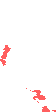
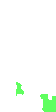
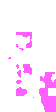

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Atlas_2017_10_webmap.html


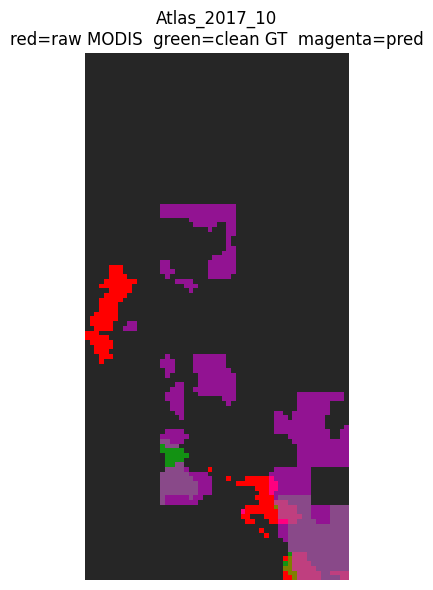

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Atlas_2017_10_slide_overlay.png

--- Rebuilding Camp_2018_11 (fold 1) ---

=== Camp_2018_11 : Interactive Map (zoom/pan this in Colab) ===



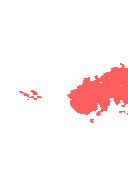
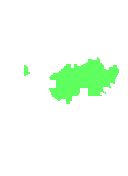
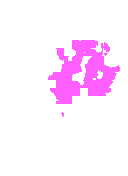

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Camp_2018_11_webmap.html


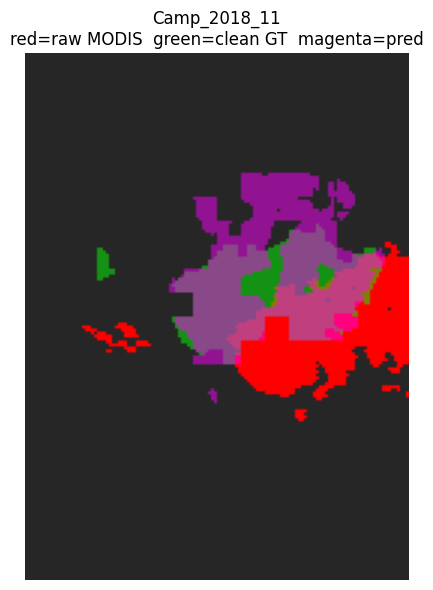

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Camp_2018_11_slide_overlay.png

--- Rebuilding Carr_2018_07 (fold 2) ---

=== Carr_2018_07 : Interactive Map (zoom/pan this in Colab) ===



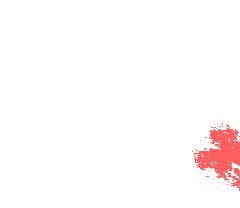
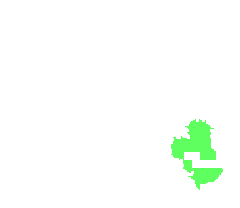
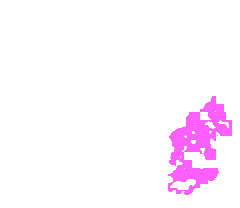

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Carr_2018_07_webmap.html


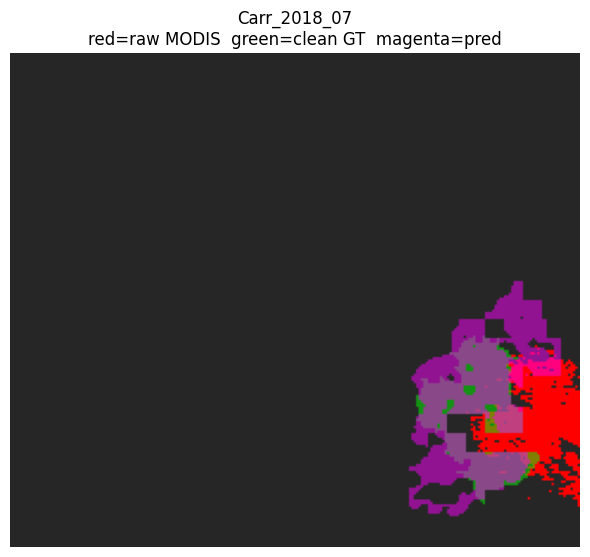

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Carr_2018_07_slide_overlay.png

--- Rebuilding Cedar_2003_10 (fold 3) ---

=== Cedar_2003_10 : Interactive Map (zoom/pan this in Colab) ===



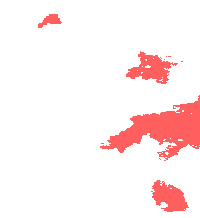
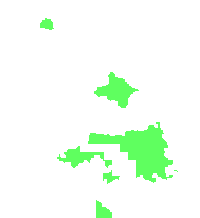
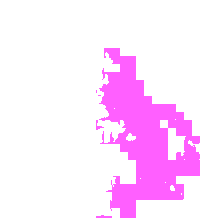

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Cedar_2003_10_webmap.html


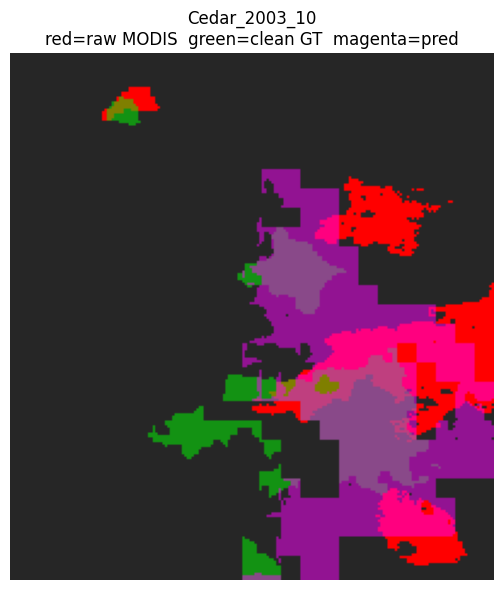

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Cedar_2003_10_slide_overlay.png

--- Rebuilding FallFire_2007_10 (fold 4) ---

=== FallFire_2007_10 : Interactive Map (zoom/pan this in Colab) ===



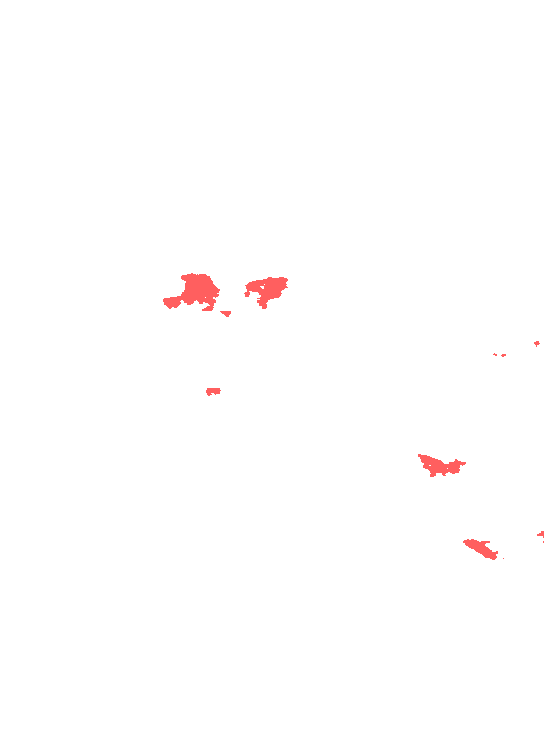
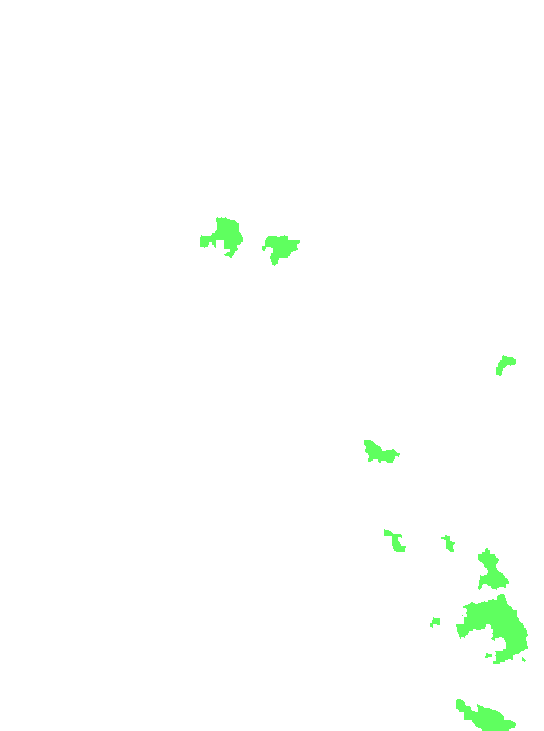
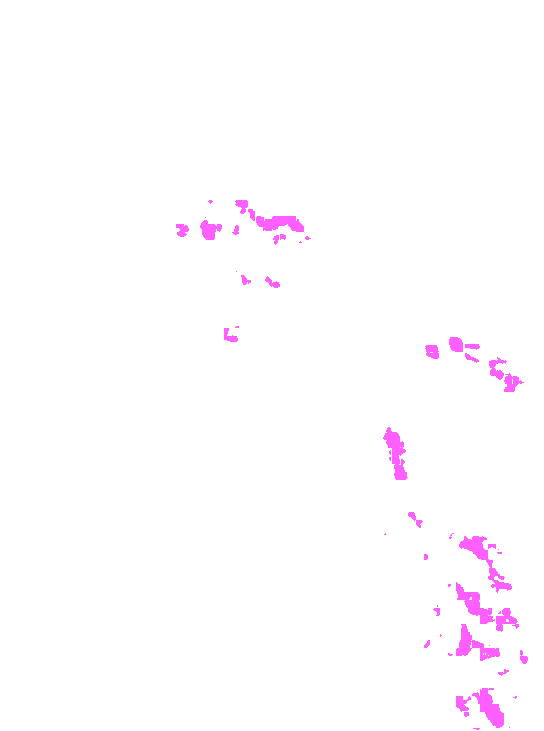

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/FallFire_2007_10_webmap.html


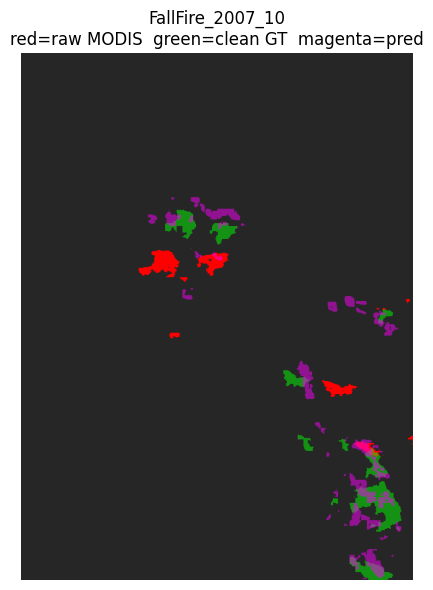

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/FallFire_2007_10_slide_overlay.png

--- Rebuilding LaBrea_2009_08 (fold 5) ---

=== LaBrea_2009_08 : Interactive Map (zoom/pan this in Colab) ===



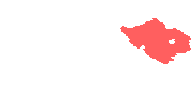
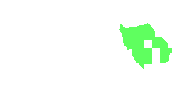
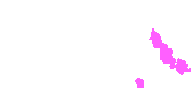

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/LaBrea_2009_08_webmap.html


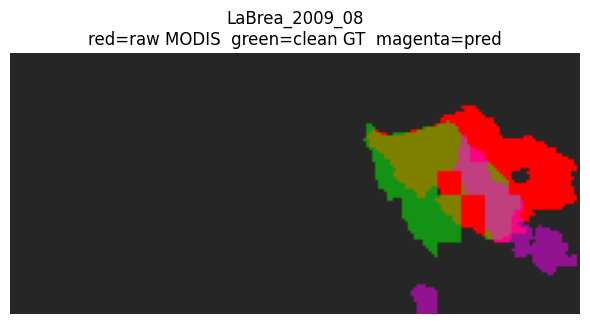

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/LaBrea_2009_08_slide_overlay.png

--- Rebuilding MendoCx_2018_08 (fold 6) ---

=== MendoCx_2018_08 : Interactive Map (zoom/pan this in Colab) ===



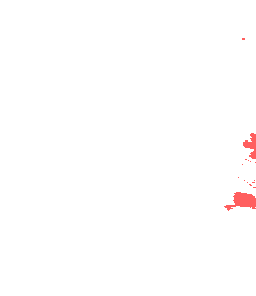
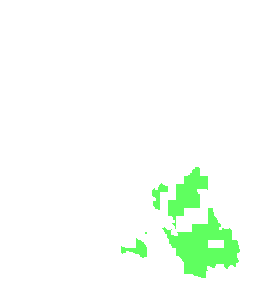
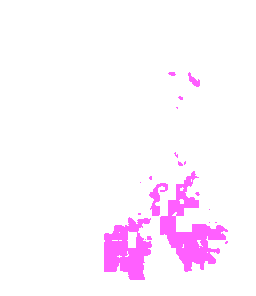

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/MendoCx_2018_08_webmap.html


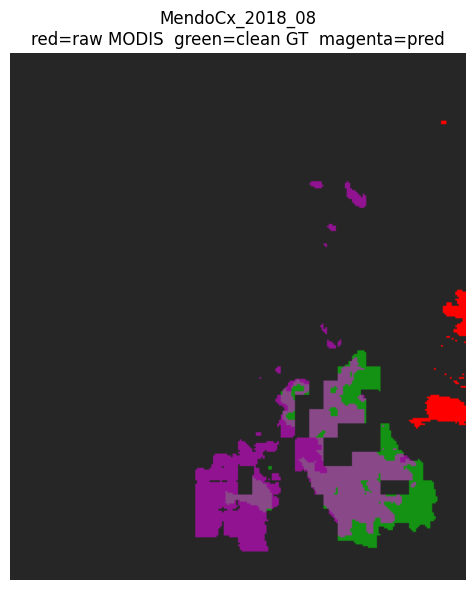

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/MendoCx_2018_08_slide_overlay.png

--- Rebuilding Nuns_2017_10 (fold 7) ---

=== Nuns_2017_10 : Interactive Map (zoom/pan this in Colab) ===



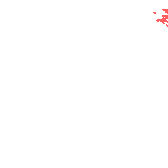
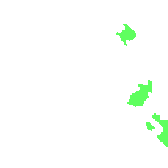
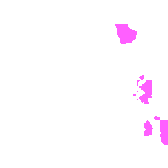

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Nuns_2017_10_webmap.html


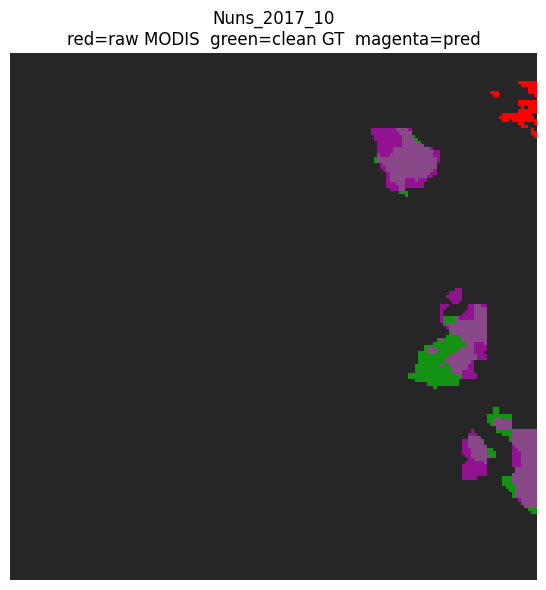

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Nuns_2017_10_slide_overlay.png

--- Rebuilding Station_2009_08 (fold 8) ---

=== Station_2009_08 : Interactive Map (zoom/pan this in Colab) ===



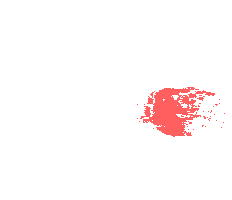
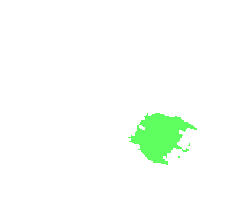
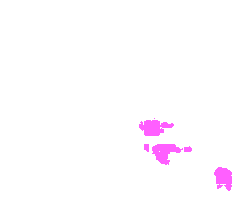

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Station_2009_08_webmap.html


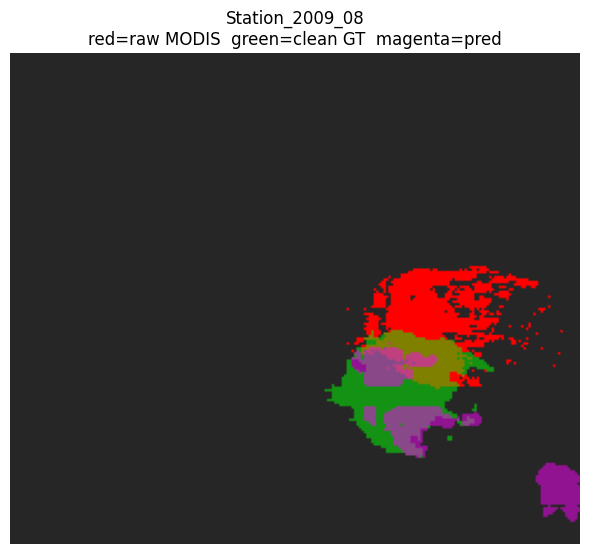

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Station_2009_08_slide_overlay.png

--- Rebuilding Thomas_2017_12 (fold 9) ---

=== Thomas_2017_12 : Interactive Map (zoom/pan this in Colab) ===



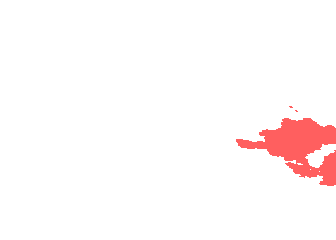
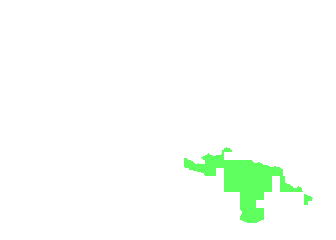
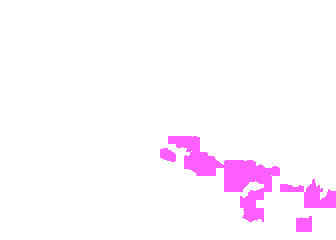

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Thomas_2017_12_webmap.html


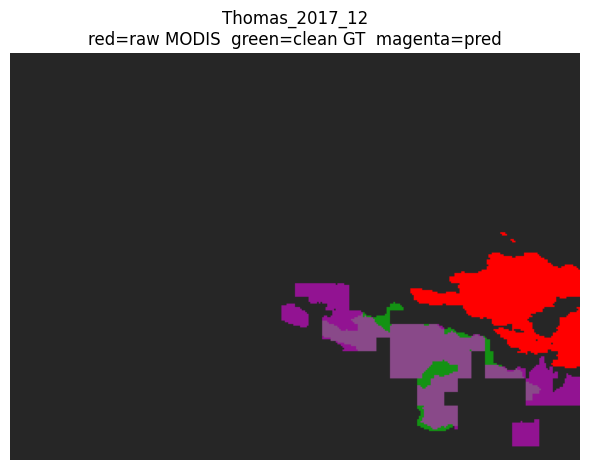

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Thomas_2017_12_slide_overlay.png

--- Rebuilding Tubbs_2017_10 (fold 10) ---

=== Tubbs_2017_10 : Interactive Map (zoom/pan this in Colab) ===



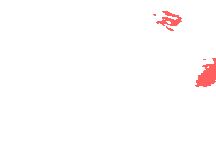
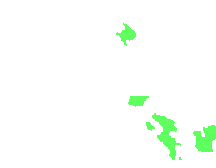
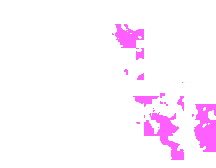

HTML saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Tubbs_2017_10_webmap.html


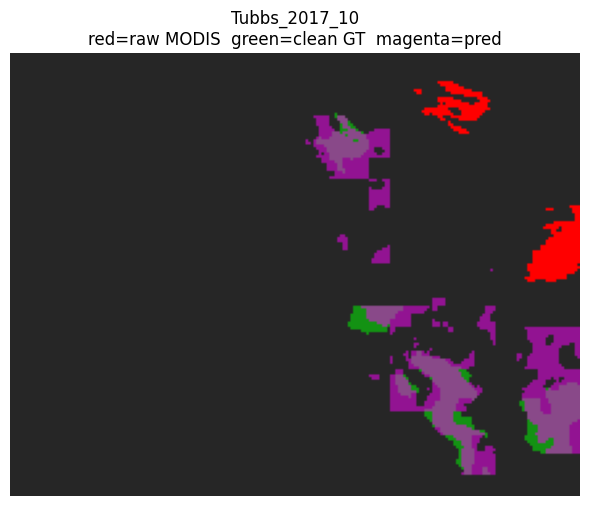

Slide PNG saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/presentation_maps/Tubbs_2017_10_slide_overlay.png


,fold,event,html,png
0,0,Atlas_2017_10,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
1,1,Camp_2018_11,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
2,2,Carr_2018_07,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
3,3,Cedar_2003_10,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
4,4,FallFire_2007_10,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
5,5,LaBrea_2009_08,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
6,6,MendoCx_2018_08,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
7,7,Nuns_2017_10,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
8,8,Station_2009_08,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...
9,9,Thomas_2017_12,/content/drive/MyDrive/fire_loeo_runs/20251029...,/content/drive/MyDrive/fire_loeo_runs/20251029...


In [ ]:
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display
from pyproj import Transformer
from affine import Affine
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import rasterio
from pathlib import Path

# =========================
# styling helpers
# =========================

def make_rgba(mask_bool, color_rgba, max_edge=4000):
    """
    Turn a boolean mask (H,W) into RGBA uint8, maybe downsample so it's not huge.
    color_rgba = (R,G,B,A) in [0..255]
    returns (rgba_small, scale)
    """
    H, W = mask_bool.shape
    rgba = np.zeros((H, W, 4), dtype=np.uint8)
    r,g,b,a = color_rgba
    m = mask_bool.astype(bool)
    rgba[m,0] = r
    rgba[m,1] = g
    rgba[m,2] = b
    rgba[m,3] = a

    # downsample if gigantic (keeps Colab/f folium snappy)
    max_dim = max(H, W)
    if max_dim > max_edge:
        scale = max_edge / max_dim
        newH = max(1, int(round(H * scale)))
        newW = max(1, int(round(W * scale)))
        rgba_small = cv2.resize(rgba, (newW, newH), interpolation=cv2.INTER_NEAREST)
        return rgba_small, scale
    else:
        return rgba, 1.0

def crop_align_for_event(test_df, model, mean, std, best_thr, burn_blob):
    """
    - stitch model preds + CLEAN GT onto its pixel canvas
    - read MODIS raw burn tif
    - crop all to common size (upper-left overlap)
    - return arrays + raster metadata for georeferencing
    """
    # stitch full-scene clean GT + preds
    gt_clean_full, pred_prob_full, pred_bin_full = stitch_clean_gt_and_model(
        test_df, model, mean, std, best_thr
    )
    Hc_canvas, Wc_canvas = gt_clean_full.shape

    # read raw burned tiff (1-band) for georef + MODIS "raw"
    blob_bytes = burn_blob.download_as_bytes()
    mem = rasterio.io.MemoryFile(blob_bytes)
    ds  = mem.open()
    raw_arr = ds.read(1).astype(np.uint8)
    Hraw, Wraw = raw_arr.shape

    # crop everything to shared min size
    Hc = min(Hc_canvas, Hraw)
    Wc = min(Wc_canvas, Wraw)

    raw_crop   = (raw_arr[:Hc, :Wc] > 0).astype(np.uint8)
    clean_crop = gt_clean_full[:Hc, :Wc].astype(np.uint8)
    pred_crop  = pred_bin_full[:Hc, :Wc].astype(np.uint8)

    return raw_crop, clean_crop, pred_crop, ds, mem, Hc, Wc

def cropped_bounds_wgs84(ds, Hc, Wc):
    """
    For the cropped upper-left Hc x Wc window of ds,
    compute its bounding box in lat/lon for folium.
    """
    full_affine: Affine = ds.transform
    transformer = Transformer.from_crs(ds.crs, "EPSG:4326", always_xy=True)

    # pixel (0,0) upper-left
    x_ul, y_ul = full_affine * (0, 0)
    # pixel (Wc,Hc) lower-right
    x_lr, y_lr = full_affine * (Wc, Hc)

    lon_ul, lat_ul = transformer.transform(x_ul, y_ul)
    lon_lr, lat_lr = transformer.transform(x_lr, y_lr)

    min_lat = min(lat_ul, lat_lr)
    max_lat = max(lat_ul, lat_lr)
    min_lon = min(lon_ul, lon_lr)
    max_lon = max(lon_ul, lon_lr)

    # center for default map zoom
    center_lat = 0.5*(min_lat+max_lat)
    center_lon = 0.5*(min_lon+max_lon)

    return (min_lat, min_lon, max_lat, max_lon, center_lat, center_lon)

def scaled_bounds(min_lat, min_lon, max_lat, max_lon, scale):
    """
    When we downsample an overlay by 'scale', we shrink bbox from UL corner.
    We'll assume north-up affine (which is true for proj.5070 exports).
    UL corner is (min_lon, max_lat), LR is (max_lon, min_lat).
    """
    ul_lat = max_lat
    ul_lon = min_lon
    lr_lat = min_lat
    lr_lon = max_lon

    new_lr_lat = ul_lat + scale*(lr_lat - ul_lat)
    new_lr_lon = ul_lon + scale*(lr_lon - ul_lon)

    new_min_lat = min(ul_lat, new_lr_lat)
    new_max_lat = max(ul_lat, new_lr_lat)
    new_min_lon = min(ul_lon, new_lr_lon)
    new_max_lon = max(ul_lon, new_lr_lon)

    return [[new_min_lat, new_min_lon],[new_max_lat, new_max_lon]]

def make_single_event_map_inline(
    event_name,
    raw_crop,
    clean_crop,
    pred_crop,
    ds,
    Hc, Wc,
    outdir
):
    """
    Build folium.Map with:
    - Streets & Satellite base layers
    - red: raw MODIS burn (holes + smoke issues)
    - green: cleaned GT we actually trained on
    - magenta: model prediction
    Display inline in Colab AND save an .html
    """

    # 1. compute geo bounds for cropped window
    min_lat, min_lon, max_lat, max_lon, ctr_lat, ctr_lon = cropped_bounds_wgs84(ds, Hc, Wc)

    # 2. turn masks into RGBA overlays + downsample
    raw_rgba,   raw_scale   = make_rgba(raw_crop.astype(bool),   (255,   0,   0, 160))   # red
    clean_rgba, clean_scale = make_rgba(clean_crop.astype(bool), (  0, 255,   0, 160))   # green
    pred_rgba,  pred_scale  = make_rgba(pred_crop.astype(bool),  (255,   0, 255, 160))   # magenta

    # 3. compute bounds for each (account for downsample scale)
    bounds_raw   = scaled_bounds(min_lat, min_lon, max_lat, max_lon, raw_scale)
    bounds_clean = scaled_bounds(min_lat, min_lon, max_lat, max_lon, clean_scale)
    bounds_pred  = scaled_bounds(min_lat, min_lon, max_lat, max_lon, pred_scale)

    # 4. build folium map
    m = folium.Map(
        location=(ctr_lat, ctr_lon),
        zoom_start=9,
        tiles=None,
    )

    folium.TileLayer("OpenStreetMap", name="Streets").add_to(m)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri",
        name="Satellite"
    ).add_to(m)

    ImageOverlay(
        image=raw_rgba,
        bounds=bounds_raw,
        opacity=1.0,
        name="RAW MODIS Burn (red)"
    ).add_to(m)

    ImageOverlay(
        image=clean_rgba,
        bounds=bounds_clean,
        opacity=1.0,
        name="CLEAN GT Burn (green)"
    ).add_to(m)

    ImageOverlay(
        image=pred_rgba,
        bounds=bounds_pred,
        opacity=1.0,
        name="Model Prediction (magenta)"
    ).add_to(m)

    folium.LayerControl(collapsed=False).add_to(m)

    # 5. save HTML for sharing
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)
    html_path = outdir / f"{event_name}_webmap.html"
    m.save(str(html_path))

    # 6. INLINE DISPLAY in Colab
    print(f"\n=== {event_name} : Interactive Map (zoom/pan this in Colab) ===")
    display(m)
    print("HTML saved:", html_path)

    # 7. ALSO build a static PNG panel for slides
    # We'll just stack the 3 masks using the same color logic on top of a fake "satellite-ish"
    # grey background so it's easy to screenshot.
    bg = np.dstack([np.ones((Hc,Wc))*0.15]*3)  # dark gray background

    # paint layers: raw red, clean green, pred magenta
    overlay_rgb = bg.copy()
    # raw red
    overlay_rgb[raw_crop>0]   = [1.0, 0.0, 0.0]
    # clean green (this can overwrite or mix; we can alpha blend):
    overlay_rgb[clean_crop>0] = 0.5*overlay_rgb[clean_crop>0] + 0.5*np.array([0.0,1.0,0.0])
    # pred magenta
    overlay_rgb[pred_crop>0]  = 0.5*overlay_rgb[pred_crop>0]  + 0.5*np.array([1.0,0.0,1.0])

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.imshow(overlay_rgb)
    ax.set_title(f"{event_name}\nred=raw MODIS  green=clean GT  magenta=pred")
    ax.axis("off")

    slide_png = outdir / f"{event_name}_slide_overlay.png"
    plt.tight_layout()
    plt.savefig(slide_png, dpi=200)
    plt.show()
    print("Slide PNG saved:", slide_png)

    return {
        "event": event_name,
        "html": str(html_path),
        "png": str(slide_png)
    }

# =========================
# DRIVER LOOP FOR ALL FOLDS
# =========================

all_map_records = []

for fold_k in sorted(res_df["fold"].unique()):
    fold_row   = res_df[res_df["fold"] == fold_k].iloc[0]
    event_name = fold_row["test_event"]
    best_thr   = float(fold_row["best_thr"])
    ckpt_path  = fold_row["checkpoint"]

    print(f"\n--- Rebuilding {event_name} (fold {fold_k}) ---")

    # rebuild splits exactly like training
    test_df  = idx[idx["event"] == event_name].reset_index(drop=True)
    rest_df  = idx[idx["event"] != event_name].reset_index(drop=True)
    train_df, val_df = split_train_val(
        rest_df,
        frac=CFG["val_frac"],
        seed=SEED
    )

    # channel stats from TRAIN
    mean, std = compute_channel_stats(train_df["npz_path"].tolist())

    # load model
    C = np.load(train_df["npz_path"].iloc[0], allow_pickle=True)["x"].shape[0]
    model = ResUNet(C).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()

    # get the MODIS burned area blob for this event
    burn_blob = list_burn_tif_for_event(event_name)

    # stitch + crop to common region + grab raster georef ds
    raw_crop, clean_crop, pred_crop, ds, mem, Hc, Wc = crop_align_for_event(
        test_df, model, mean, std, best_thr, burn_blob
    )

    # build + show folium map inline and save HTML/PNG
    rec = make_single_event_map_inline(
        event_name,
        raw_crop,
        clean_crop,
        pred_crop,
        ds,
        Hc, Wc,
        outdir=Path(SAVE_ROOT) / "presentation_maps"
    )
    all_map_records.append({
        "fold": fold_k,
        **rec
    })

    ds.close()
    mem.close()

# show summary table in notebook
import pandas as pd
maps_df = pd.DataFrame(all_map_records).sort_values("fold").reset_index(drop=True)
display(maps_df)



=== Fold 0 / Atlas_2017_10 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold0_Atlas_2017_10.pt
 thr : 0.5


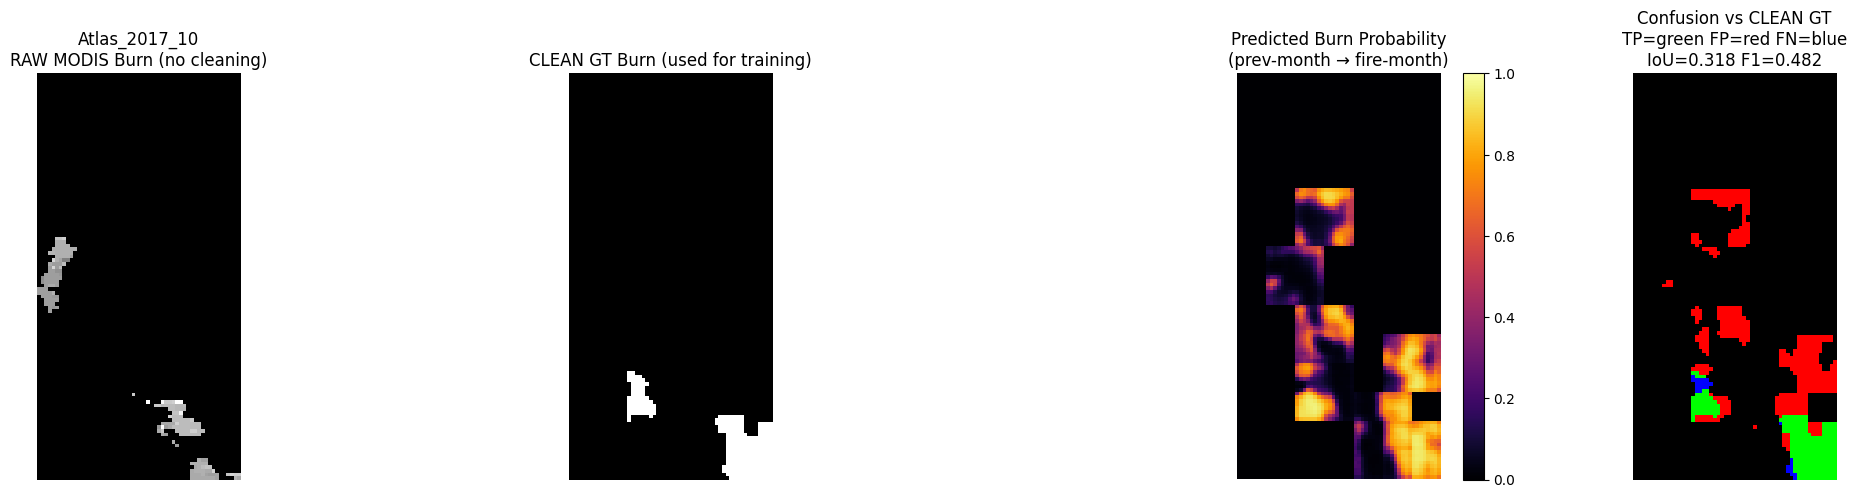

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/00_Atlas_2017_10_raw_vs_clean_vs_pred.png
tp=257 fp=525 fn=27 IoU=0.3177 F1=0.4822

=== Fold 1 / Camp_2018_11 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold1_Camp_2018_11.pt
 thr : 0.5


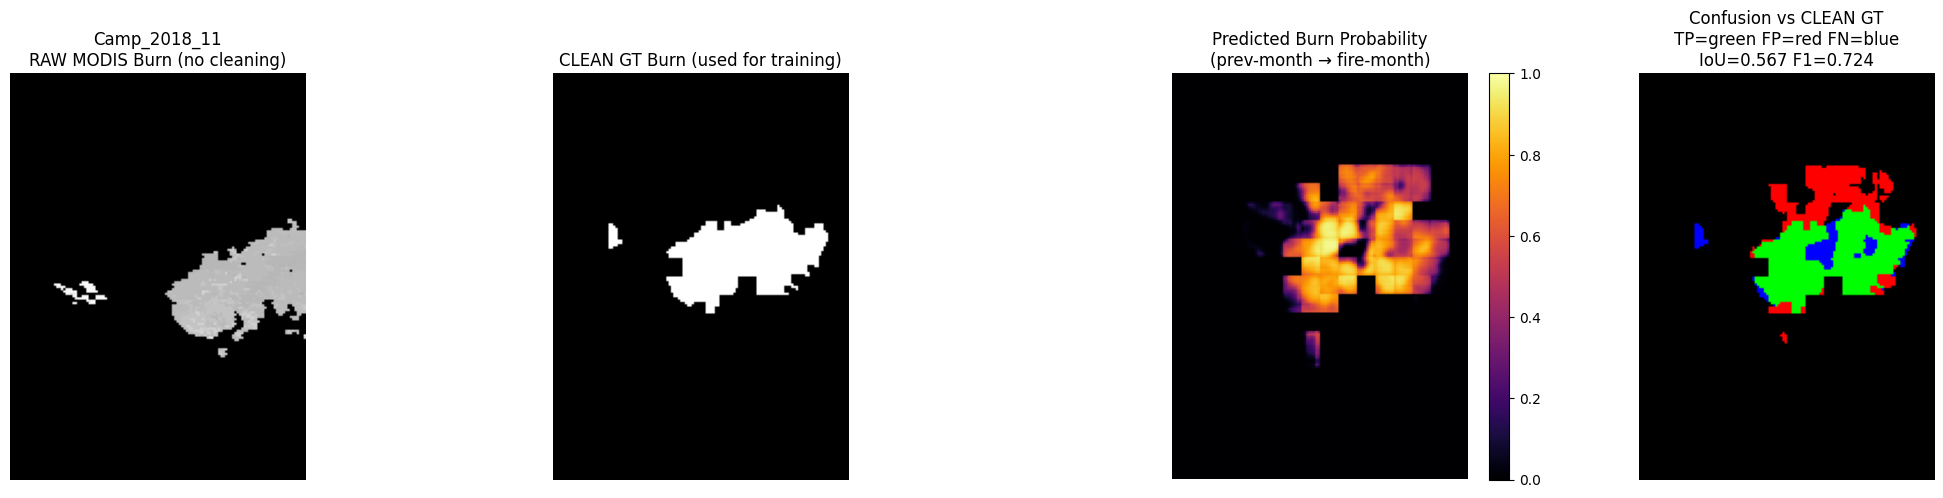

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/01_Camp_2018_11_raw_vs_clean_vs_pred.png
tp=1581 fp=908 fn=298 IoU=0.5673 F1=0.7239

=== Fold 2 / Carr_2018_07 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold2_Carr_2018_07.pt
 thr : 0.3


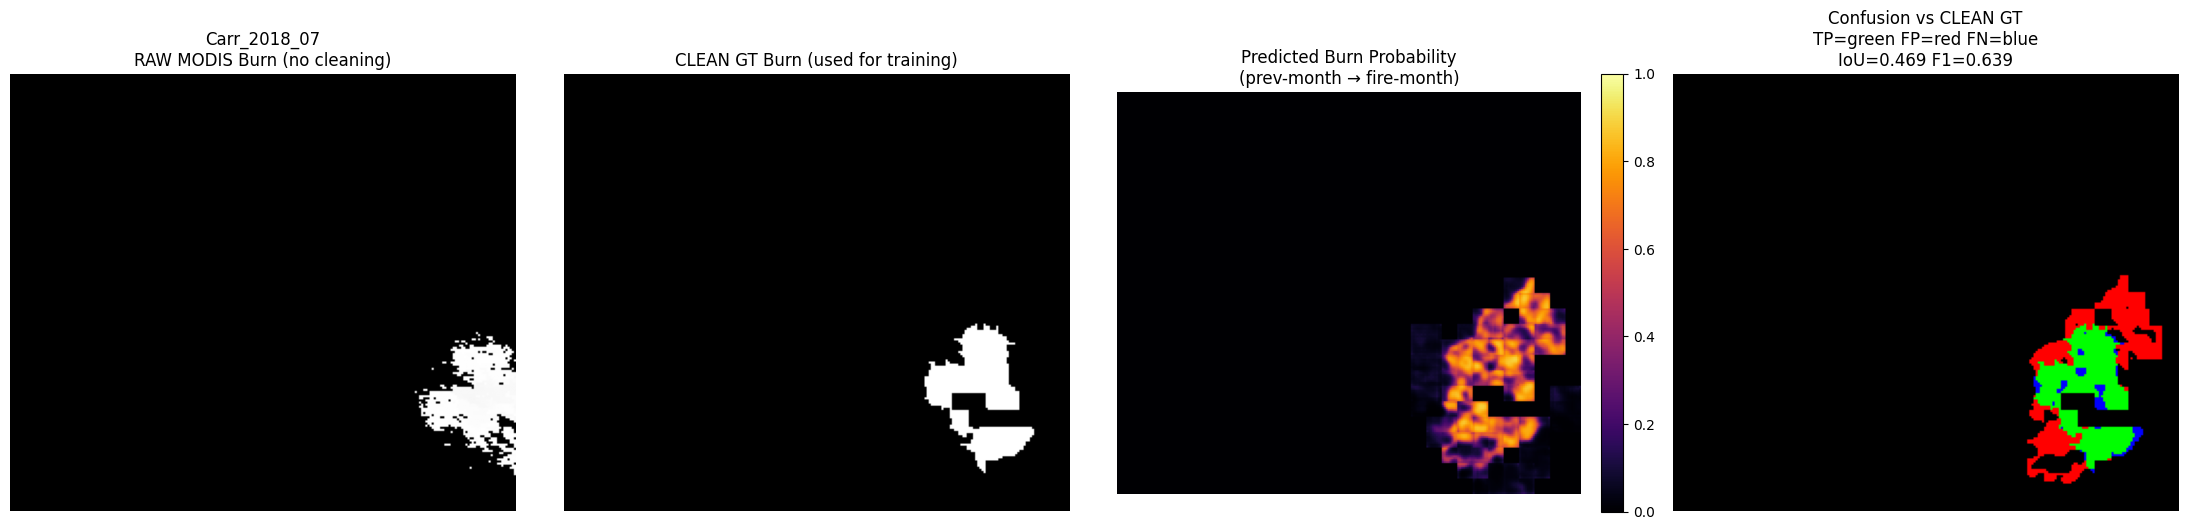

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/02_Carr_2018_07_raw_vs_clean_vs_pred.png
tp=1437 fp=1438 fn=187 IoU=0.4693 F1=0.6388

=== Fold 3 / Cedar_2003_10 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold3_Cedar_2003_10.pt
 thr : 0.5


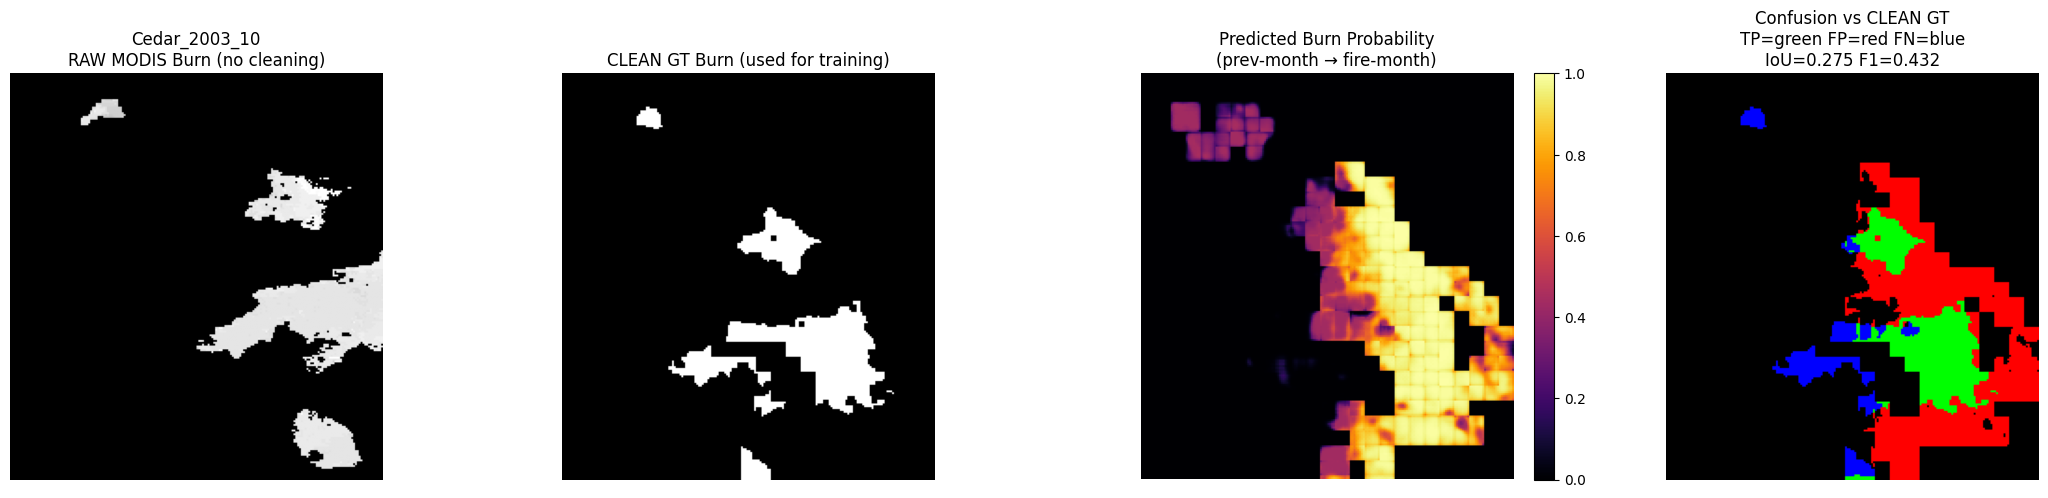

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/03_Cedar_2003_10_raw_vs_clean_vs_pred.png
tp=2626 fp=5767 fn=1147 IoU=0.2753 F1=0.4317

=== Fold 4 / FallFire_2007_10 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold4_FallFire_2007_10.pt
 thr : 0.55


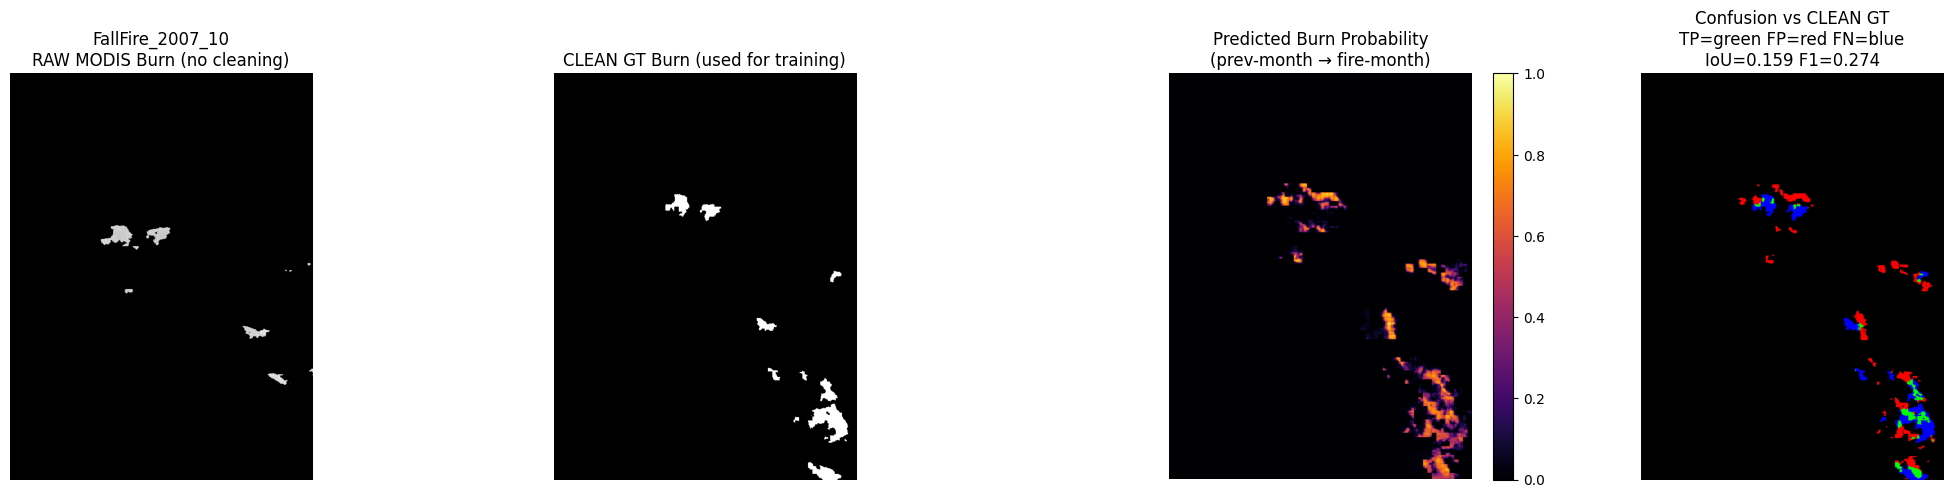

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/04_FallFire_2007_10_raw_vs_clean_vs_pred.png
tp=1756 fp=4544 fn=4755 IoU=0.1588 F1=0.2741

=== Fold 5 / LaBrea_2009_08 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold5_LaBrea_2009_08.pt
 thr : 0.5


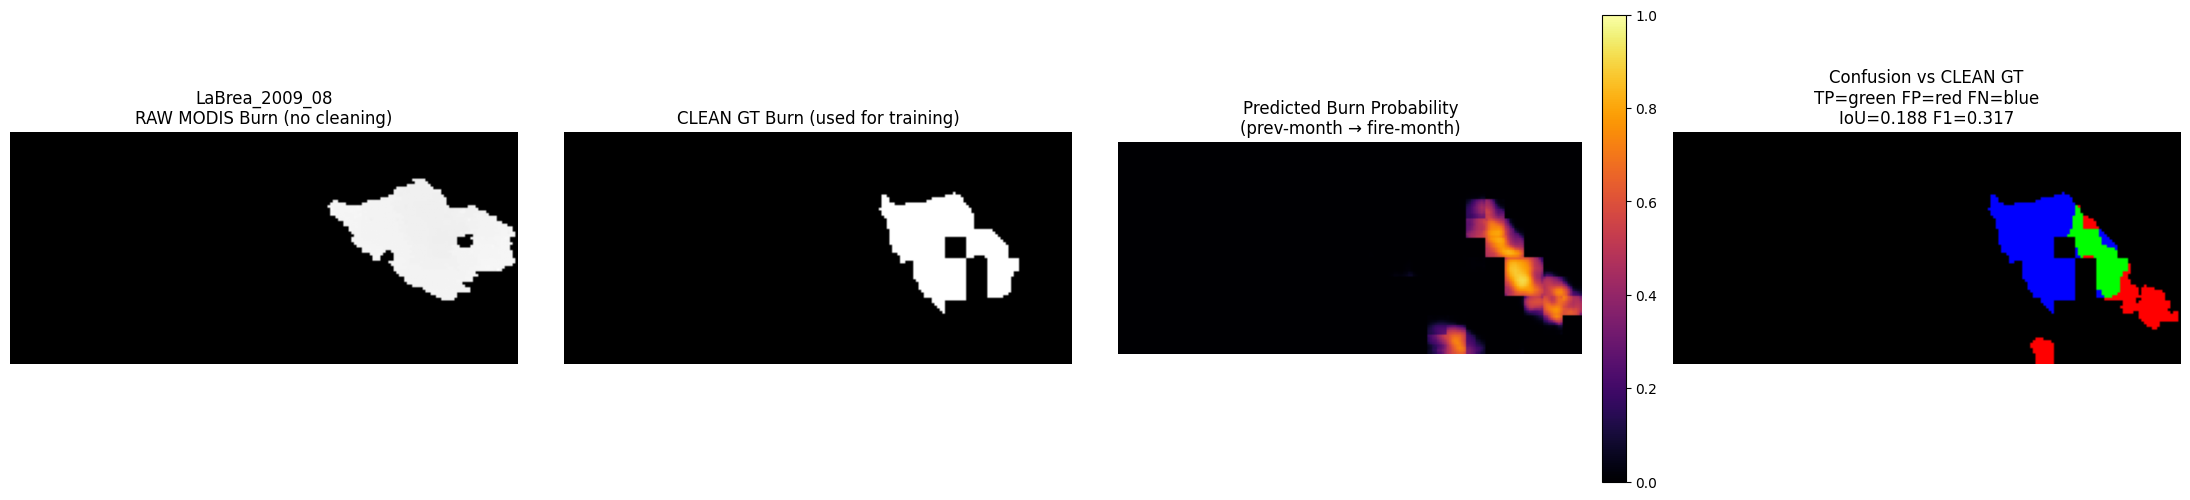

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/05_LaBrea_2009_08_raw_vs_clean_vs_pred.png
tp=299 fp=356 fn=934 IoU=0.1882 F1=0.3167

=== Fold 6 / MendoCx_2018_08 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold6_MendoCx_2018_08.pt
 thr : 0.45


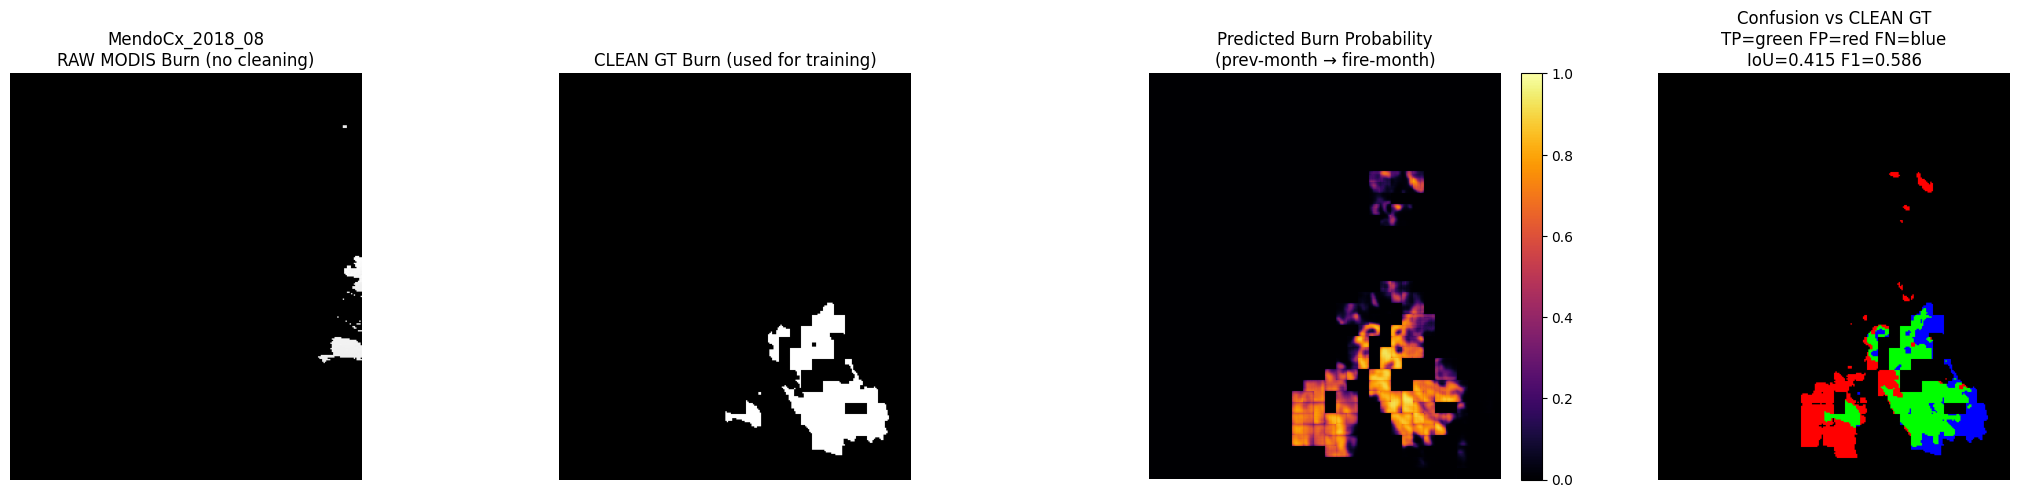

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/06_MendoCx_2018_08_raw_vs_clean_vs_pred.png
tp=2608 fp=2269 fn=1411 IoU=0.4148 F1=0.5863

=== Fold 7 / Nuns_2017_10 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold7_Nuns_2017_10.pt
 thr : 0.55


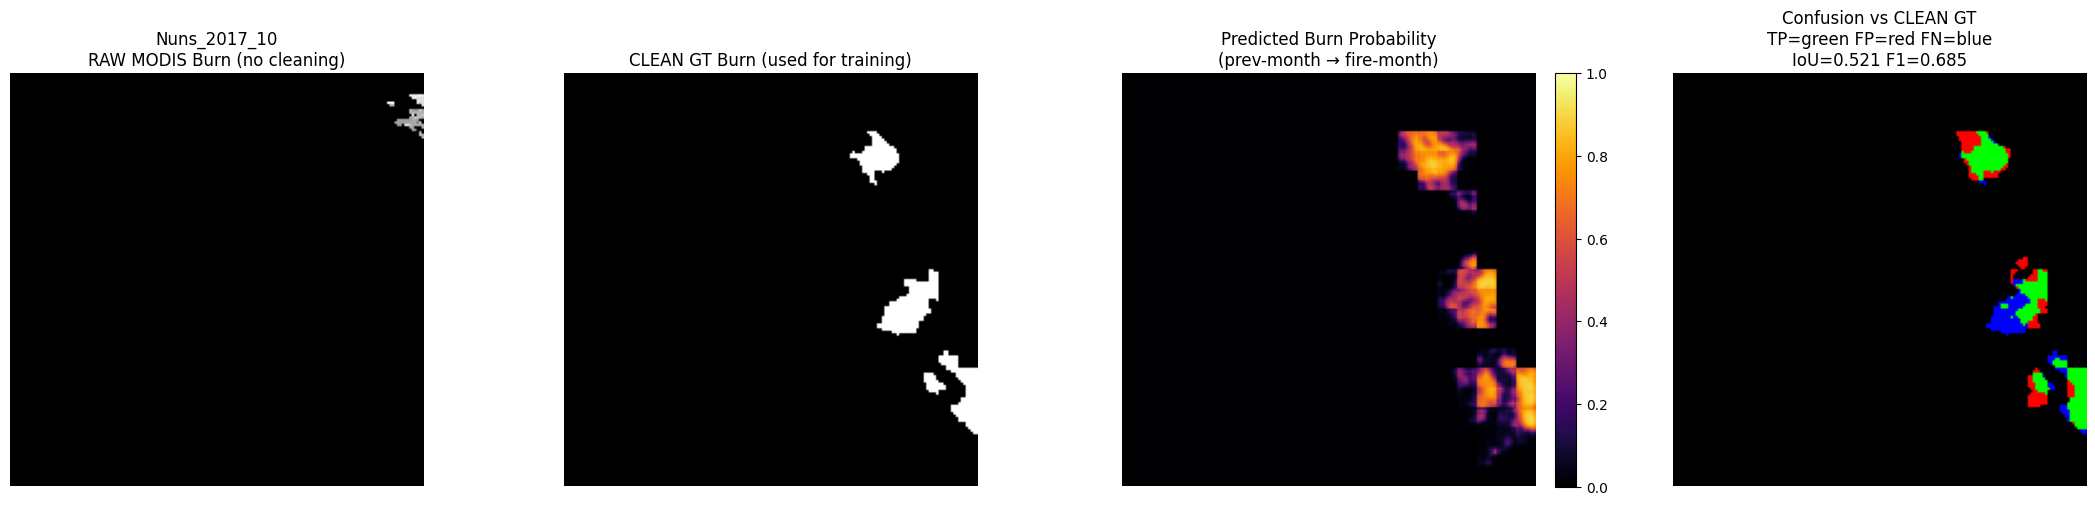

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/07_Nuns_2017_10_raw_vs_clean_vs_pred.png
tp=576 fp=278 fn=252 IoU=0.5208 F1=0.6849

=== Fold 8 / Station_2009_08 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold8_Station_2009_08.pt
 thr : 0.5


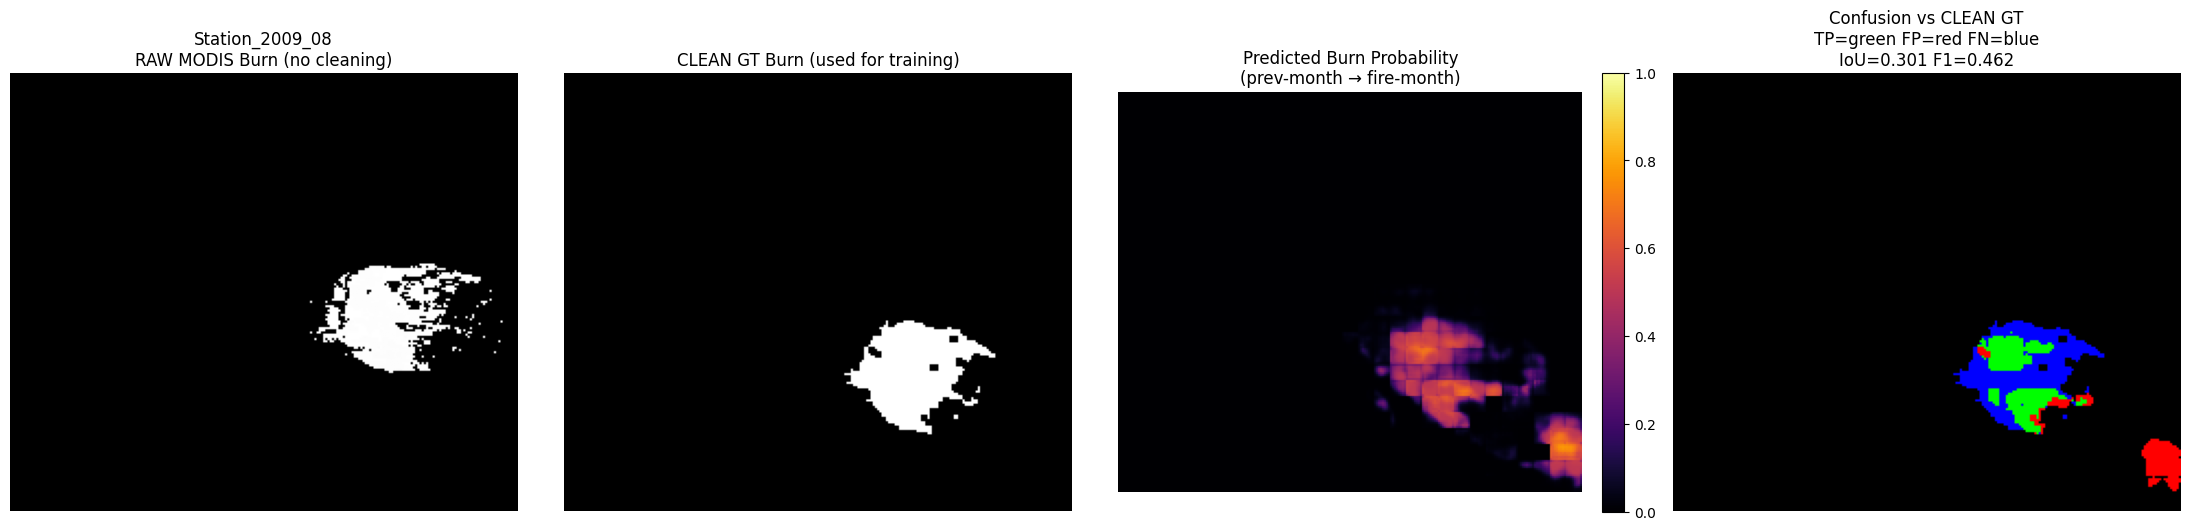

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/08_Station_2009_08_raw_vs_clean_vs_pred.png
tp=681 fp=425 fn=1160 IoU=0.3005 F1=0.4622

=== Fold 9 / Thomas_2017_12 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold9_Thomas_2017_12.pt
 thr : 0.45


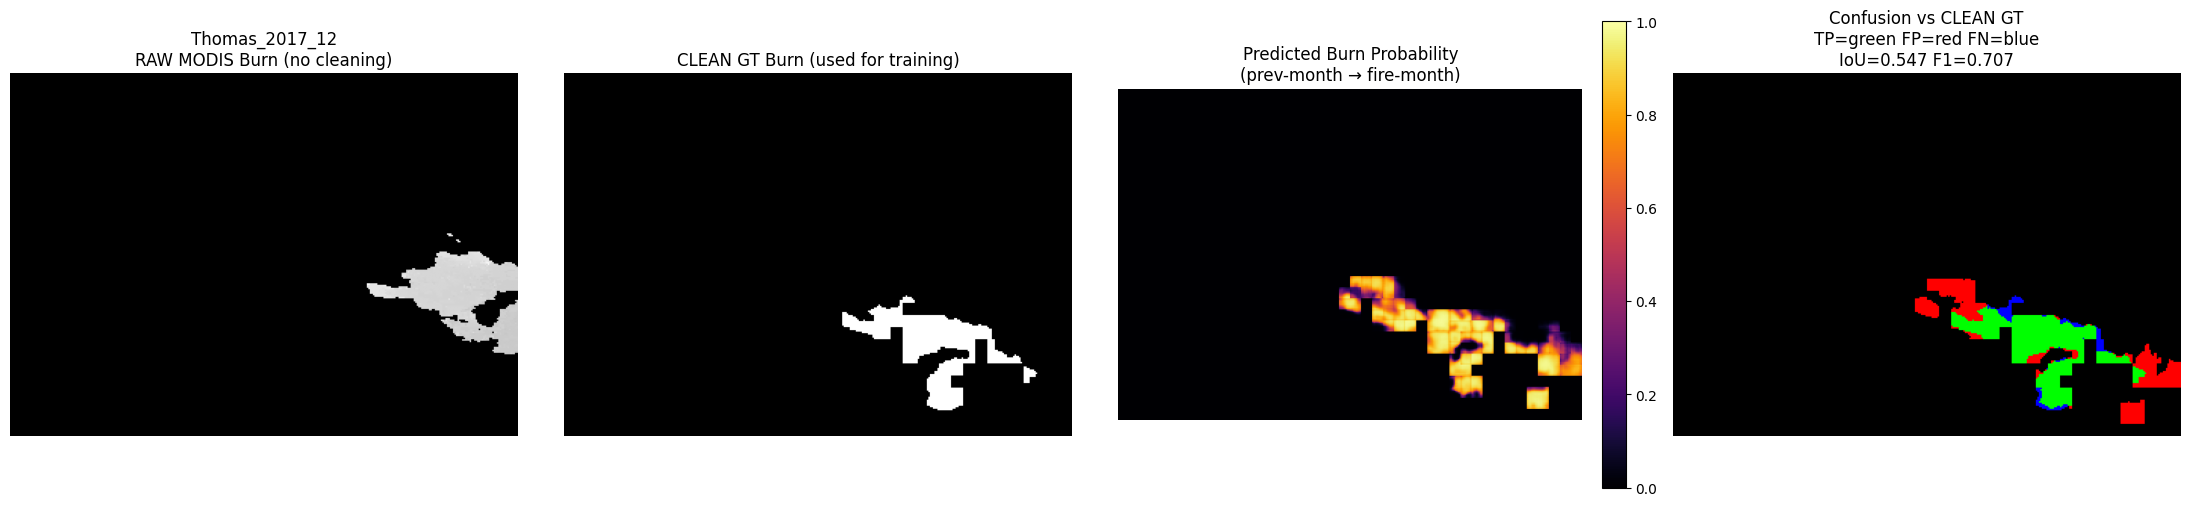

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/09_Thomas_2017_12_raw_vs_clean_vs_pred.png
tp=2430 fp=1711 fn=301 IoU=0.5471 F1=0.7072

=== Fold 10 / Tubbs_2017_10 ===
 ckpt: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/checkpoints/fold10_Tubbs_2017_10.pt
 thr : 0.5


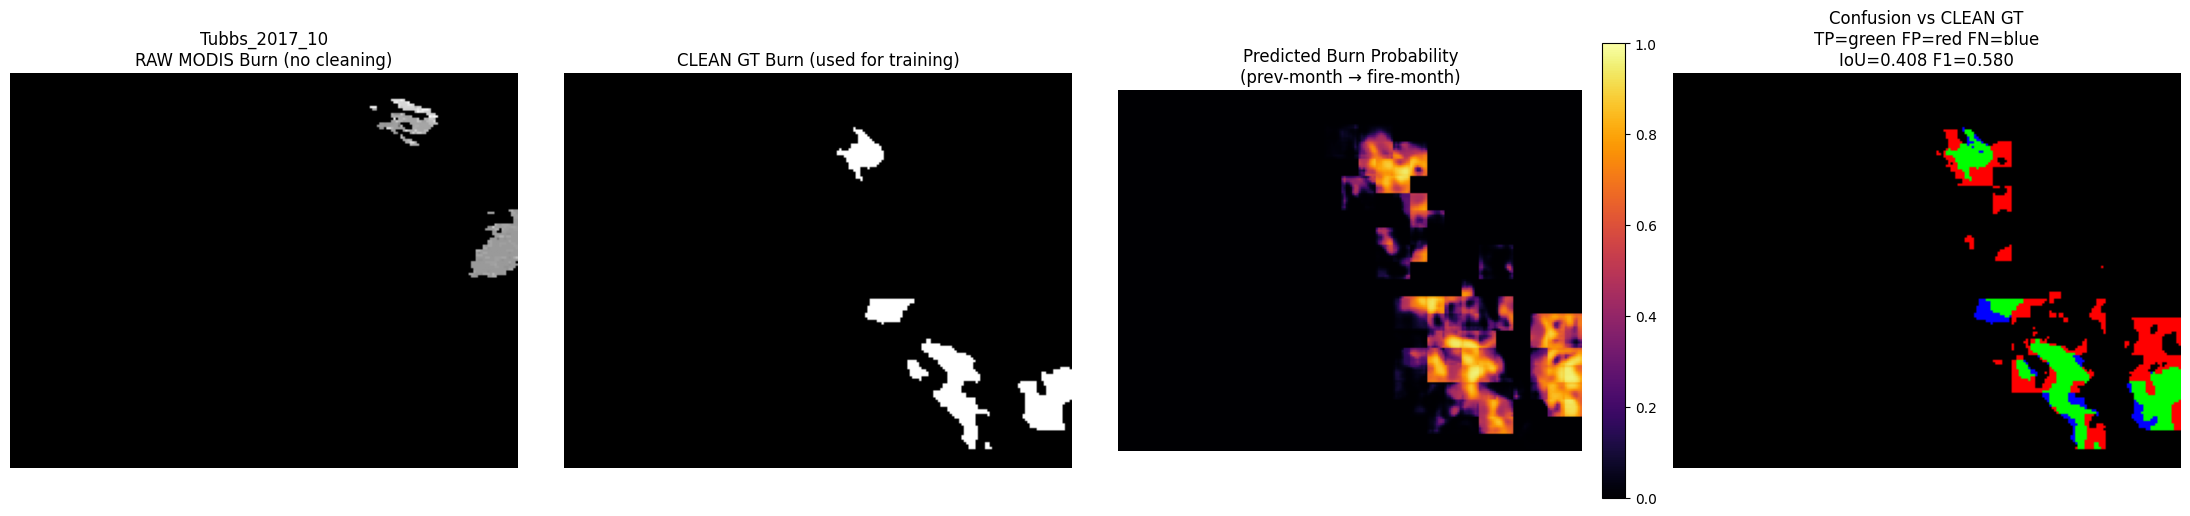

Saved: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/10_Tubbs_2017_10_raw_vs_clean_vs_pred.png
tp=1084 fp=1313 fn=260 IoU=0.4080 F1=0.5795


,fold,event,best_thr,tp,fp,fn,IoU,F1,panel_png
0,0,Atlas_2017_10,0.50,257,525,27,0.317676,0.482176,/content/drive/MyDrive/fire_loeo_runs/20251029...
1,1,Camp_2018_11,0.50,1581,908,298,0.567277,0.723901,/content/drive/MyDrive/fire_loeo_runs/20251029...
2,2,Carr_2018_07,0.30,1437,1438,187,0.469301,0.638809,/content/drive/MyDrive/fire_loeo_runs/20251029...
3,3,Cedar_2003_10,0.50,2626,5767,1147,0.275262,0.431695,/content/drive/MyDrive/fire_loeo_runs/20251029...
4,4,FallFire_2007_10,0.55,1756,4544,4755,0.158842,0.274139,/content/drive/MyDrive/fire_loeo_runs/20251029...
5,5,LaBrea_2009_08,0.50,299,356,934,0.188169,0.316737,/content/drive/MyDrive/fire_loeo_runs/20251029...
6,6,MendoCx_2018_08,0.45,2608,2269,1411,0.414758,0.586331,/content/drive/MyDrive/fire_loeo_runs/20251029...
7,7,Nuns_2017_10,0.55,576,278,252,0.520796,0.684899,/content/drive/MyDrive/fire_loeo_runs/20251029...
8,8,Station_2009_08,0.50,681,425,1160,0.300530,0.462165,/content/drive/MyDrive/fire_loeo_runs/20251029...
9,9,Thomas_2017_12,0.45,2430,1711,301,0.547051,0.707218,/content/drive/MyDrive/fire_loeo_runs/20251029...



Summary CSV: /content/drive/MyDrive/fire_loeo_runs/20251029_130529/viz_event_level_rawMODIS/raw_clean_pred_summary.csv


In [ ]:
#

## EVM Feature Export Logic

### Subtask:
Keep the cell containing the EVM feature export logic. This code is responsible for preparing and exporting the Earth Engine-based features required for model training.

#### Instructions
Keep the code cell with cell ID `E_V9Y2QZ8srq`. This cell defines the functions and parameters necessary to build and export the EVM (Environmental Vegetation Model) features to Google Cloud Storage.

**Reasoning**:
The next step is to add the code for EVM Feature Export Logic, as per the main task's instructions. This code is crucial for generating the input features for the model.



In [ ]:
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap, math

# Authenticate / init
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events (fire months)
# =========================
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# =========================
# AOI helpers (robust geometry)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # Avoid zero-buffer errors; modest simplify is safe for county-scale AOIs
    return geom.simplify(100)

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def prev_month(year, month):
    return (year-1, 12) if month == 1 else (year, month-1)

def prev_ym(year, month, k=1):
    d = ee.Date.fromYMD(year, month, 15).advance(-k, 'month')
    return ee.Number(d.get('year')).int(), ee.Number(d.get('month')).int()

# =========================
# Config
# =========================
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500
LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
BUCKET = 'california-fire-model'

FILE_PREFIX_FMT = (
    "evms_events/{fire_name}/"
    "EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{crs}_{scale}m"
)
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

# =========================
# Reprojection helpers
# =========================
def reproj_cont(img):        # continuous -> Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical -> Float32 (keep categories discrete)
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

# =========================
# Physics helpers (VPD)
# =========================
def _esat_kPa(Tc):
    # Tetens; Tc in °C
    return ee.Image(0.6108).multiply((ee.Image(17.27).multiply(Tc)).divide(Tc.add(237.3)).exp())

def _pressure_Pa(elev_m):
    # barometric approximation
    return ee.Image(101325).multiply((ee.Image(1).subtract(ee.Image(2.25577e-5).multiply(elev_m))).pow(5.25588))

def _ea_kPa(q, p_Pa):
    # specific humidity (kg/kg) to vapor pressure (kPa)
ea_Pa = q.multiply(p_Pa).divide(ee.Image(0.622).add(ee.Image(0.378).multiply(q)))
    return ea_Pa.divide(1000.0)

def vpd_from_tminsph(tminC, tmaxC, sph, elev):
    Tmean = tminC.add(tmaxC).divide(2)
    es = _esat_kPa(Tmean)
    p  = _pressure_Pa(elev)
    ea = _ea_kPa(sph, p)
    return es.subtract(ea).rename('VPD')  # kPa

# =========================
# NLCD helpers (epochal, correct release)
# =========================
NLCD_YEARS = [2001, 2006, 2011, 2016, 2019, 2021]

def choose_nlcd_year_num(fire_year_int):
    y = None
    for yr in NLCD_YEARS:
        if yr <= fire_year_int:
            y = yr
        else:
            break
    return y if y is not None else NLCD_YEARS[0]

def load_nlcd_epoch(nlcd_year_int):
    # 2001–2019 are in the 2019 release; 2021 is in the 2021 release
    asset = (f'USGS/NLCD_RELEASES/2021_REL/NLCD/{nlcd_year_int}'
             if nlcd_year_int == 2021
             else f'USGS/NLCD_RELEASES/2019_REL/NLCD/{nlcd_year_int}')
    return ee.Image(asset).select('landcover')

def one_hot_nlcd(nlcd_img):
    # Common NLCD classes
    classes = [11,12,21,22,23,24,31,41,42,43,52,71,81,82,90,95]
    return ee.Image.cat([nlcd_img.eq(c).rename(f'NLCD_{c}') for c in classes])

# =========================
# STATIC features (topo + NLCD one-hot)
# =========================
def build_static_features(region, nlcd_year_int):
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')
    aspect = ee.Terrain.aspect(dem)
    aspect_sin = reproj_cont(aspect.multiply(math.pi/180.0).sin()).rename('aspect_sin')
    aspect_cos = reproj_cont(aspect.multiply(math.pi/180.0).cos()).rename('aspect_cos')

    # 3x3 roughness via std-dev
    kernel3 = ee.Kernel.square(radius=1, units='pixels', normalize=False)
    roughness = reproj_cont(
        dem.reduceNeighborhood(reducer=ee.Reducer.stdDev(), kernel=kernel3)
    ).rename('roughness')

    # NLCD epoch -> one-hot (no explicit resample; reprojection handles alignment)
    nlcd_raw = load_nlcd_epoch(nlcd_year_int)
    nlcd_oh  = one_hot_nlcd(reproj_cat_to_float(nlcd_raw))

    return ee.Image.cat([elev, slope, aspect_sin, aspect_cos, roughness, nlcd_oh]).clip(region).toFloat()

# =========================
# DYNAMIC monthly features (weather/veg/LFMC/drought)
# =========================
def build_month_features(year, month, region):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')

    grid = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start, end)
    tmaxK = grid.select('tmmx').mean()
    tminK = grid.select('tmmn').mean()
    pr    = grid.select('pr').sum()
    wind  = grid.select('vs').mean()
    sph   = grid.select('sph').mean()
    eto   = grid.select('eto').sum()

    tmaxC = reproj_cont(tmaxK.subtract(273.15)).rename('tmax')
    tminC = reproj_cont(tminK.subtract(273.15)).rename('tmin')
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    sph   = reproj_cont(sph).rename('humidity')
    eto   = reproj_cont(eto).rename('eto')
    aridity = pr.divide(eto.max(1e-9)).rename('aridity')

    # MODIS vegetation with QA
    ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
            .filterDate(start, end)
            .map(lambda img: img.updateMask(img.select('SummaryQA').eq(0)))
            .select('NDVI').mean().multiply(0.0001))
    ndvi = reproj_cont(ndvi).rename('NDVI')

    lai = (ee.ImageCollection('MODIS/061/MCD15A3H')
           .filterDate(start, end)
           .map(lambda img: img.updateMask(img.select('FparLai_QC').bitwiseAnd(3).lt(2)))
           .select('Lai').mean().multiply(0.1))
    lai = reproj_cont(lai).rename('LAI')

    # LFMC (+ availability flag)
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc_has = lfmc_ic.size().gt(0)
    lfmc_val = ee.Image(ee.Algorithms.If(lfmc_has, lfmc_ic.mean(), ee.Image(0)))
    lfmc     = reproj_cont(lfmc_val).rename('LFMC')
    lfmc_flag = reproj_cont(ee.Image(lfmc_has)).rename('LFMC_available')

    # VPD (kPa) using SRTM for pressure
    elev_for_vpd = ee.Image('CGIAR/SRTM90_V4')
    VPD = reproj_cont(vpd_from_tminsph(tminC, tmaxC, sph, elev_for_vpd))

    # TerraClimate (monthly mean)
    tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterDate(start, end).mean()
    tc_def  = reproj_cont(tc.select('def')).rename('def')
    tc_pdsi = reproj_cont(tc.select('pdsi')).rename('pdsi')
    srad    = reproj_cont(tc.select('srad')).rename('srad')

    return ee.Image.cat([
        tmaxC, tminC, pr, wind, sph, eto, aridity,
        VPD, ndvi, lai, lfmc, lfmc_flag, tc_def, tc_pdsi, srad
    ]).clip(region).toFloat()

# =========================
# Lags + aggregates (fixed: homogeneous band names for VPD_3mo)
# =========================
def build_prev_with_lags(fire_year_int, fire_month_int, region, nlcd_year_int):
    # Statics (topo + NLCD)
    statics = build_static_features(region, nlcd_year_int)

    # Base month: prev-1
    y1, m1 = prev_ym(fire_year_int, fire_month_int, 1)
    base = build_month_features(y1, m1, region)

    # Lags prev-1..3 (explicit suffixes)
    lag_imgs = []
    for k in [1, 2, 3]:
        yk, mk = prev_ym(fire_year_int, fire_month_int, k)
        img_k = build_month_features(yk, mk, region)
        rn = img_k.bandNames().map(lambda b: ee.String(b).cat(ee.String(f'_lag{k}')))
        lag_imgs.append(img_k.rename(rn))

    # 3-month aggregates (PR sum, VPD mean) over prev-3..prev-1
    start3 = ee.Date.fromYMD(fire_year_int, fire_month_int, 1).advance(-3, 'month')
    end1   = ee.Date.fromYMD(fire_year_int, fire_month_int, 1)

    pr_3mo = reproj_cont(
        ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
          .select('pr')
          .filterDate(start3, end1)
          .sum()
    ).rename('pr_3mo')

    img_lags = ee.Image.cat(lag_imgs)

    # Build a homogeneous collection for VPD_3mo
    vpd_list = []
    for nm in ['VPD_lag1', 'VPD_lag2', 'VPD_lag3']:
        vpd_list.append(img_lags.select(nm).rename('VPD'))
    VPD_3mo = ee.ImageCollection(vpd_list).mean().rename('VPD_3mo')

    return ee.Image.cat([statics, base] + lag_imgs + [pr_3mo, VPD_3mo]).toFloat()

# =========================
# Export
# =========================
def export_prev_month_evm(fire_name, fire_year, fire_month, region):
    nlcd_year_int = choose_nlcd_year_num(int(fire_year))
    img = build_prev_with_lags(int(fire_year), int(fire_month), region, nlcd_year_int)

    fire_ym = f"{fire_year}-{fire_month:02d}"
    feat_y, feat_m = prev_month(fire_year, fire_month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name, fire_ym=fire_ym, feat_ym=feat_ym, crs=CRS_TAG, scale=SCALE
    )
    desc = prefix.split('/')[-1]

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started EVM export for {fire_name}: prev {feat_ym} → label {fire_ym} → gs://{BUCKET}/{prefix}.tif")

# =========================
# Kick off exports
# =========================
for fire_name, counties, (fire_year, fire_month) in events:
    region = aoi_from_counties(counties)
    export_prev_month_evm(
        fire_name=fire_name,
        fire_year=fire_year,
        fire_month=fire_month,
        region=region
    )

# =========================
# (Optional) check tasks
# =========================
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '|', s.get('state'), '|', s.get('error_message'))


IndentationError: expected an indented block after function definition on line 87 (ipython-input-556814458.py, line 89)

**Reasoning**:
The previous code block failed due to an `IndentationError` in the `_ea_kPa` function. I need to correct the indentation of the line where `ea_Pa` is defined to be inside the function body.



In [ ]:
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap, math

# Authenticate / init
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events (fire months)
# =========================
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# =========================
# AOI helpers (robust geometry)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # Avoid zero-buffer errors; modest simplify is safe for county-scale AOIs
    return geom.simplify(100)

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def prev_month(year, month):
    return (year-1, 12) if month == 1 else (year, month-1)

def prev_ym(year, month, k=1):
    d = ee.Date.fromYMD(year, month, 15).advance(-k, 'month')
    return ee.Number(d.get('year')).int(), ee.Number(d.get('month')).int()

# =========================
# Config
# =========================
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500
LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
BUCKET = 'california-fire-model'

FILE_PREFIX_FMT = (
    "evms_events/{fire_name}/"
    "EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{crs}_{scale}m"
)
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

# =========================
# Reprojection helpers
# =========================
def reproj_cont(img):        # continuous -> Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical -> Float32 (keep categories discrete)
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

# =========================
# Physics helpers (VPD)
# =========================
def _esat_kPa(Tc):
    # Tetens; Tc in °C
    return ee.Image(0.6108).multiply((ee.Image(17.27).multiply(Tc)).divide(Tc.add(237.3)).exp())

def _pressure_Pa(elev_m):
    # barometric approximation
    return ee.Image(101325).multiply((ee.Image(1).subtract(ee.Image(2.25577e-5).multiply(elev_m))).pow(5.25588))

def _ea_kPa(q, p_Pa):
    # specific humidity (kg/kg) to vapor pressure (kPa)
    ea_Pa = q.multiply(p_Pa).divide(ee.Image(0.622).add(ee.Image(0.378).multiply(q)))
    return ea_Pa.divide(1000.0)

def vpd_from_tminsph(tminC, tmaxC, sph, elev):
    Tmean = tminC.add(tmaxC).divide(2)
    es = _esat_kPa(Tmean)
    p  = _pressure_Pa(elev)
    ea = _ea_kPa(sph, p)
    return es.subtract(ea).rename('VPD')  # kPa

# =========================
# NLCD helpers (epochal, correct release)
# =========================
NLCD_YEARS = [2001, 2006, 2011, 2016, 2019, 2021]

def choose_nlcd_year_num(fire_year_int):
    y = None
    for yr in NLCD_YEARS:
        if yr <= fire_year_int:
            y = yr
        else:
            break
    return y if y is not None else NLCD_YEARS[0]

def load_nlcd_epoch(nlcd_year_int):
    # 2001–2019 are in the 2019 release; 2021 is in the 2021 release
    asset = (f'USGS/NLCD_RELEASES/2021_REL/NLCD/{nlcd_year_int}'
             if nlcd_year_int == 2021
             else f'USGS/NLCD_RELEASES/2019_REL/NLCD/{nlcd_year_int}')
    return ee.Image(asset).select('landcover')

def one_hot_nlcd(nlcd_img):
    # Common NLCD classes
    classes = [11,12,21,22,23,24,31,41,42,43,52,71,81,82,90,95]
    return ee.Image.cat([nlcd_img.eq(c).rename(f'NLCD_{c}') for c in classes])

# =========================
# STATIC features (topo + NLCD one-hot)
# =========================
def build_static_features(region, nlcd_year_int):
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')
    aspect = ee.Terrain.aspect(dem)
    aspect_sin = reproj_cont(aspect.multiply(math.pi/180.0).sin()).rename('aspect_sin')
    aspect_cos = reproj_cont(aspect.multiply(math.pi/180.0).cos()).rename('aspect_cos')

    # 3x3 roughness via std-dev
    kernel3 = ee.Kernel.square(radius=1, units='pixels', normalize=False)
    roughness = reproj_cont(
        dem.reduceNeighborhood(reducer=ee.Reducer.stdDev(), kernel=kernel3)
    ).rename('roughness')

    # NLCD epoch -> one-hot (no explicit resample; reprojection handles alignment)
    nlcd_raw = load_nlcd_epoch(nlcd_year_int)
    nlcd_oh  = one_hot_nlcd(reproj_cat_to_float(nlcd_raw))

    return ee.Image.cat([elev, slope, aspect_sin, aspect_cos, roughness, nlcd_oh]).clip(region).toFloat()

# =========================
# DYNAMIC monthly features (weather/veg/LFMC/drought)
# =========================
def build_month_features(year, month, region):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')

    grid = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start, end)
    tmaxK = grid.select('tmmx').mean()
    tminK = grid.select('tmmn').mean()
    pr    = grid.select('pr').sum()
    wind  = grid.select('vs').mean()
    sph   = grid.select('sph').mean()
    eto   = grid.select('eto').sum()

    tmaxC = reproj_cont(tmaxK.subtract(273.15)).rename('tmax')
    tminC = reproj_cont(tminK.subtract(273.15)).rename('tmin')
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    sph   = reproj_cont(sph).rename('humidity')
    eto   = reproj_cont(eto).rename('eto')
    aridity = pr.divide(eto.max(1e-9)).rename('aridity')

    # MODIS vegetation with QA
    ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
            .filterDate(start, end)
            .map(lambda img: img.updateMask(img.select('SummaryQA').eq(0)))
            .select('NDVI').mean().multiply(0.0001))
    ndvi = reproj_cont(ndvi).rename('NDVI')

    lai = (ee.ImageCollection('MODIS/061/MCD15A3H')
           .filterDate(start, end)
           .map(lambda img: img.updateMask(img.select('FparLai_QC').bitwiseAnd(3).lt(2)))
           .select('Lai').mean().multiply(0.1))
    lai = reproj_cont(lai).rename('LAI')

    # LFMC (+ availability flag)
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc_has = lfmc_ic.size().gt(0)
    lfmc_val = ee.Image(ee.Algorithms.If(lfmc_has, lfmc_ic.mean(), ee.Image(0)))
    lfmc     = reproj_cont(lfmc_val).rename('LFMC')
    lfmc_flag = reproj_cont(ee.Image(lfmc_has)).rename('LFMC_available')

    # VPD (kPa) using SRTM for pressure
    elev_for_vpd = ee.Image('CGIAR/SRTM90_V4')
    VPD = reproj_cont(vpd_from_tminsph(tminC, tmaxC, sph, elev_for_vpd))

    # TerraClimate (monthly mean)
    tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterDate(start, end).mean()
    tc_def  = reproj_cont(tc.select('def')).rename('def')
    tc_pdsi = reproj_cont(tc.select('pdsi')).rename('pdsi')
    srad    = reproj_cont(tc.select('srad')).rename('srad')

    return ee.Image.cat([
        tmaxC, tminC, pr, wind, sph, eto, aridity,
        VPD, ndvi, lai, lfmc, lfmc_flag, tc_def, tc_pdsi, srad
    ]).clip(region).toFloat()

# =========================
# Lags + aggregates (fixed: homogeneous band names for VPD_3mo)
# =========================
def build_prev_with_lags(fire_year_int, fire_month_int, region, nlcd_year_int):
    # Statics (topo + NLCD)
    statics = build_static_features(region, nlcd_year_int)

    # Base month: prev-1
    y1, m1 = prev_ym(fire_year_int, fire_month_int, 1)
    base = build_month_features(y1, m1, region)

    # Lags prev-1..3 (explicit suffixes)
    lag_imgs = []
    for k in [1, 2, 3]:
        yk, mk = prev_ym(fire_year_int, fire_month_int, k)
        img_k = build_month_features(yk, mk, region)
        rn = img_k.bandNames().map(lambda b: ee.String(b).cat(ee.String(f'_lag{k}')))
        lag_imgs.append(img_k.rename(rn))

    # 3-month aggregates (PR sum, VPD mean) over prev-3..prev-1
    start3 = ee.Date.fromYMD(fire_year_int, fire_month_int, 1).advance(-3, 'month')
    end1   = ee.Date.fromYMD(fire_year_int, fire_month_int, 1)

    pr_3mo = reproj_cont(
        ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
          .select('pr')
          .filterDate(start3, end1)
          .sum()
    ).rename('pr_3mo')

    img_lags = ee.Image.cat(lag_imgs)

    # Build a homogeneous collection for VPD_3mo
    vpd_list = []
    for nm in ['VPD_lag1', 'VPD_lag2', 'VPD_lag3']:
        vpd_list.append(img_lags.select(nm).rename('VPD'))
    VPD_3mo = ee.ImageCollection(vpd_list).mean().rename('VPD_3mo')

    return ee.Image.cat([statics, base] + lag_imgs + [pr_3mo, VPD_3mo]).toFloat()

# =========================
# Export
# =========================
def export_prev_month_evm(fire_name, fire_year, fire_month, region):
    nlcd_year_int = choose_nlcd_year_num(int(fire_year))
    img = build_prev_with_lags(int(fire_year), int(fire_month), region, nlcd_year_int)

    fire_ym = f"{fire_year}-{fire_month:02d}"
    feat_y, feat_m = prev_month(fire_year, fire_month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name, fire_ym=fire_ym, feat_ym=feat_ym, crs=CRS_TAG, scale=SCALE
    )
    desc = prefix.split('/')[-1]

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started EVM export for {fire_name}: prev {feat_ym} → label {fire_ym} → gs://{BUCKET}/{prefix}.tif")

# =========================
# Kick off exports
# =========================
for fire_name, counties, (fire_year, fire_month) in events:
    region = aoi_from_counties(counties)
    export_prev_month_evm(
        fire_name=fire_name,
        fire_year=fire_year,
        fire_month=fire_month,
        region=region
    )

# =========================
# (Optional) check tasks
# =========================
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '|', s.get('state'), '|', s.get('error_message'))


🚀 Started EVM export for Cedar_2003_10: prev 2003-09 → label 2003-10 → gs://california-fire-model/evms_events/Cedar_2003_10/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
🚀 Started EVM export for FallFire_2007_10: prev 2007-09 → label 2007-10 → gs://california-fire-model/evms_events/FallFire_2007_10/EVMx_FallFire_2007_10_2007-10_prev_2007-09_EPSG5070_500m.tif
🚀 Started EVM export for Station_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/Station_2009_08/EVMx_Station_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for LaBrea_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/LaBrea_2009_08/EVMx_LaBrea_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for Thomas_2017_12: prev 2017-11 → label 2017-12 → gs://california-fire-model/evms_events/Thomas_2017_12/EVMx_Thomas_2017_12_2017-12_prev_2017-11_EPSG5070_500m.tif
🚀 Started EVM export for Atlas_2017_10: prev 2017-09 → label 2017-10 

**Reasoning**:
The previous code block failed due to an `IndentationError`. I have corrected the indentation of the `ea_Pa` variable definition within the `_ea_kPa` function to be properly aligned with the function body. I will now re-run the entire EVM feature export logic.



In [ ]:
# --- Install & init (Colab) ---
# !pip -q install earthengine-api geemap
import ee, geemap, math

# Authenticate / init
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# =========================
# Events (fire months)
# =========================
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# =========================
# AOI helpers (robust geometry)
# =========================
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # Avoid zero-buffer errors; modest simplify is safe for county-scale AOIs
    return geom.simplify(100)

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

def prev_month(year, month):
    return (year-1, 12) if month == 1 else (year, month-1)

def prev_ym(year, month, k=1):
    d = ee.Date.fromYMD(year, month, 15).advance(-k, 'month')
    return ee.Number(d.get('year')).int(), ee.Number(d.get('month')).int()

# =========================
# Config
# =========================
USE_PROJECTED = True
CRS = 'EPSG:5070' if USE_PROJECTED else 'EPSG:4326'
SCALE = 500
LFMC_ASSET = 'users/kkraoj/lfm-mapper/lfmc_col_25_may_2021'
BUCKET = 'california-fire-model'

FILE_PREFIX_FMT = (
    "evms_events/{fire_name}/"
    "EVMx_{fire_name}_{fire_ym}_prev_{feat_ym}_{crs}_{scale}m"
)
CRS_TAG = 'EPSG5070' if USE_PROJECTED else 'WGS84'

# =========================
# Reprojection helpers
# =========================
def reproj_cont(img):        # continuous -> Float32
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

def reproj_cat_to_float(img):  # categorical -> Float32 (keep categories discrete)
    return img.toFloat().reproject(crs=CRS, scale=SCALE)

# =========================
# Physics helpers (VPD)
# =========================
def _esat_kPa(Tc):
    # Tetens; Tc in °C
    return ee.Image(0.6108).multiply((ee.Image(17.27).multiply(Tc)).divide(Tc.add(237.3)).exp())

def _pressure_Pa(elev_m):
    # barometric approximation
    return ee.Image(101325).multiply((ee.Image(1).subtract(ee.Image(2.25577e-5).multiply(elev_m))).pow(5.25588))

def _ea_kPa(q, p_Pa):
    # specific humidity (kg/kg) to vapor pressure (kPa)
    ea_Pa = q.multiply(p_Pa).divide(ee.Image(0.622).add(ee.Image(0.378).multiply(q)))
    return ea_Pa.divide(1000.0)

def vpd_from_tminsph(tminC, tmaxC, sph, elev):
    Tmean = tminC.add(tmaxC).divide(2)
    es = _esat_kPa(Tmean)
    p  = _pressure_Pa(elev)
    ea = _ea_kPa(sph, p)
    return es.subtract(ea).rename('VPD')  # kPa

# =========================
# NLCD helpers (epochal, correct release)
# =========================
NLCD_YEARS = [2001, 2006, 2011, 2016, 2019, 2021]

def choose_nlcd_year_num(fire_year_int):
    y = None
    for yr in NLCD_YEARS:
        if yr <= fire_year_int:
            y = yr
        else:
            break
    return y if y is not None else NLCD_YEARS[0]

def load_nlcd_epoch(nlcd_year_int):
    # 2001–2019 are in the 2019 release; 2021 is in the 2021 release
    asset = (f'USGS/NLCD_RELEASES/2021_REL/NLCD/{nlcd_year_int}'
             if nlcd_year_int == 2021
             else f'USGS/NLCD_RELEASES/2019_REL/NLCD/{nlcd_year_int}')
    return ee.Image(asset).select('landcover')

def one_hot_nlcd(nlcd_img):
    # Common NLCD classes
    classes = [11,12,21,22,23,24,31,41,42,43,52,71,81,82,90,95]
    return ee.Image.cat([nlcd_img.eq(c).rename(f'NLCD_{c}') for c in classes])

# =========================
# STATIC features (topo + NLCD one-hot)
# =========================
def build_static_features(region, nlcd_year_int):
    dem   = ee.Image('CGIAR/SRTM90_V4')
    elev  = reproj_cont(dem).rename('elev')
    slope = reproj_cont(ee.Terrain.slope(dem)).rename('slope')
    aspect = ee.Terrain.aspect(dem)
    aspect_sin = reproj_cont(aspect.multiply(math.pi/180.0).sin()).rename('aspect_sin')
    aspect_cos = reproj_cont(aspect.multiply(math.pi/180.0).cos()).rename('aspect_cos')

    # 3x3 roughness via std-dev
    kernel3 = ee.Kernel.square(radius=1, units='pixels', normalize=False)
    roughness = reproj_cont(
        dem.reduceNeighborhood(reducer=ee.Reducer.stdDev(), kernel=kernel3)
    ).rename('roughness')

    # NLCD epoch -> one-hot (no explicit resample; reprojection handles alignment)
    nlcd_raw = load_nlcd_epoch(nlcd_year_int)
    nlcd_oh  = one_hot_nlcd(reproj_cat_to_float(nlcd_raw))

    return ee.Image.cat([elev, slope, aspect_sin, aspect_cos, roughness, nlcd_oh]).clip(region).toFloat()

# =========================
# DYNAMIC monthly features (weather/veg/LFMC/drought)
# =========================
def build_month_features(year, month, region):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')

    grid = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start, end)
    tmaxK = grid.select('tmmx').mean()
    tminK = grid.select('tmmn').mean()
    pr    = grid.select('pr').sum()
    wind  = grid.select('vs').mean()
    sph   = grid.select('sph').mean()
    eto   = grid.select('eto').sum()

    tmaxC = reproj_cont(tmaxK.subtract(273.15)).rename('tmax')
    tminC = reproj_cont(tminK.subtract(273.15)).rename('tmin')
    pr    = reproj_cont(pr).rename('pr')
    wind  = reproj_cont(wind).rename('wind')
    sph   = reproj_cont(sph).rename('humidity')
    eto   = reproj_cont(eto).rename('eto')
    aridity = pr.divide(eto.max(1e-9)).rename('aridity')

    # MODIS vegetation with QA
    ndvi = (ee.ImageCollection('MODIS/061/MOD13A1')
            .filterDate(start, end)
            .map(lambda img: img.updateMask(img.select('SummaryQA').eq(0)))
            .select('NDVI').mean().multiply(0.0001))
    ndvi = reproj_cont(ndvi).rename('NDVI')

    lai = (ee.ImageCollection('MODIS/061/MCD15A3H')
           .filterDate(start, end)
           .map(lambda img: img.updateMask(img.select('FparLai_QC').bitwiseAnd(3).lt(2)))
           .select('Lai').mean().multiply(0.1))
    lai = reproj_cont(lai).rename('LAI')

    # LFMC (+ availability flag)
    lfmc_ic = ee.ImageCollection(LFMC_ASSET).filterDate(start, end)
    lfmc_has = lfmc_ic.size().gt(0)
    lfmc_val = ee.Image(ee.Algorithms.If(lfmc_has, lfmc_ic.mean(), ee.Image(0)))
    lfmc     = reproj_cont(lfmc_val).rename('LFMC')
    lfmc_flag = reproj_cont(ee.Image(lfmc_has)).rename('LFMC_available')

    # VPD (kPa) using SRTM for pressure
    elev_for_vpd = ee.Image('CGIAR/SRTM90_V4')
    VPD = reproj_cont(vpd_from_tminsph(tminC, tmaxC, sph, elev_for_vpd))

    # TerraClimate (monthly mean)
    tc = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filterDate(start, end).mean()
    tc_def  = reproj_cont(tc.select('def')).rename('def')
    tc_pdsi = reproj_cont(tc.select('pdsi')).rename('pdsi')
    srad    = reproj_cont(tc.select('srad')).rename('srad')

    return ee.Image.cat([
        tmaxC, tminC, pr, wind, sph, eto, aridity,
        VPD, ndvi, lai, lfmc, lfmc_flag, tc_def, tc_pdsi, srad
    ]).clip(region).toFloat()

# =========================
# Lags + aggregates (fixed: homogeneous band names for VPD_3mo)
# =========================
def build_prev_with_lags(fire_year_int, fire_month_int, region, nlcd_year_int):
    # Statics (topo + NLCD)
    statics = build_static_features(region, nlcd_year_int)

    # Base month: prev-1
    y1, m1 = prev_ym(fire_year_int, fire_month_int, 1)
    base = build_month_features(y1, m1, region)

    # Lags prev-1..3 (explicit suffixes)
    lag_imgs = []
    for k in [1, 2, 3]:
        yk, mk = prev_ym(fire_year_int, fire_month_int, k)
        img_k = build_month_features(yk, mk, region)
        rn = img_k.bandNames().map(lambda b: ee.String(b).cat(ee.String(f'_lag{k}')))
        lag_imgs.append(img_k.rename(rn))

    # 3-month aggregates (PR sum, VPD mean) over prev-3..prev-1
    start3 = ee.Date.fromYMD(fire_year_int, fire_month_int, 1).advance(-3, 'month')
    end1   = ee.Date.fromYMD(fire_year_int, fire_month_int, 1)

    pr_3mo = reproj_cont(
        ee.ImageCollection('IDAHO_EPSCOR/GRIDMET')
          .select('pr')
          .filterDate(start3, end1)
          .sum()
    ).rename('pr_3mo')

    img_lags = ee.Image.cat(lag_imgs)

    # Build a homogeneous collection for VPD_3mo
    vpd_list = []
    for nm in ['VPD_lag1', 'VPD_lag2', 'VPD_lag3']:
        vpd_list.append(img_lags.select(nm).rename('VPD'))
    VPD_3mo = ee.ImageCollection(vpd_list).mean().rename('VPD_3mo')

    return ee.Image.cat([statics, base] + lag_imgs + [pr_3mo, VPD_3mo]).toFloat()

# =========================
# Export
# =========================
def export_prev_month_evm(fire_name, fire_year, fire_month, region):
    nlcd_year_int = choose_nlcd_year_num(int(fire_year))
    img = build_prev_with_lags(int(fire_year), int(fire_month), region, nlcd_year_int)

    fire_ym = f"{fire_year}-{fire_month:02d}"
    feat_y, feat_m = prev_month(fire_year, fire_month)
    feat_ym = f"{feat_y}-{feat_m:02d}"

    prefix = FILE_PREFIX_FMT.format(
        fire_name=fire_name, fire_ym=fire_ym, feat_ym=feat_ym, crs=CRS_TAG, scale=SCALE
    )
    desc = prefix.split('/')[-1]

    task = ee.batch.Export.image.toCloudStorage(
        image=img,
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=prefix,
        region=region,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Started EVM export for {fire_name}: prev {feat_ym} → label {fire_ym} → gs://{BUCKET}/{prefix}.tif")

# =========================
# Kick off exports
# =========================
for fire_name, counties, (fire_year, fire_month) in events:
    region = aoi_from_counties(counties)
    export_prev_month_evm(
        fire_name=fire_name,
        fire_year=fire_year,
        fire_month=fire_month,
        region=region
    )

# =========================
# (Optional) check tasks
# =========================
for t in ee.batch.Task.list():
    s = t.status()
    print(s.get('description'), '|', s.get('state'), '|', s.get('error_message'))


🚀 Started EVM export for Cedar_2003_10: prev 2003-09 → label 2003-10 → gs://california-fire-model/evms_events/Cedar_2003_10/EVMx_Cedar_2003_10_2003-10_prev_2003-09_EPSG5070_500m.tif
🚀 Started EVM export for FallFire_2007_10: prev 2007-09 → label 2007-10 → gs://california-fire-model/evms_events/FallFire_2007_10/EVMx_FallFire_2007_10_2007-10_prev_2007-09_EPSG5070_500m.tif
🚀 Started EVM export for Station_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/Station_2009_08/EVMx_Station_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for LaBrea_2009_08: prev 2009-07 → label 2009-08 → gs://california-fire-model/evms_events/LaBrea_2009_08/EVMx_LaBrea_2009_08_2009-08_prev_2009-07_EPSG5070_500m.tif
🚀 Started EVM export for Thomas_2017_12: prev 2017-11 → label 2017-12 → gs://california-fire-model/evms_events/Thomas_2017_12/EVMx_Thomas_2017_12_2017-12_prev_2017-11_EPSG5070_500m.tif
🚀 Started EVM export for Atlas_2017_10: prev 2017-09 → label 2017-10 

## Burned Area Label Export Logic

### Subtask:
Keep the cell containing the burned area label export logic. This code exports MODIS burned area masks to Google Cloud Storage, which will serve as ground truth labels for model training.

#### Instructions
Keep the code cell with cell ID `9G8tTMYLqLed`. This cell defines helper functions and then exports the MODIS burned area masks (for the fire month and the next month) to Google Cloud Storage. Ensure the `aoi_from_counties` function is correctly updated to prevent `Geometry.buffer: Can't buffer with a 0 error margin` errors.

## Burned Area Label Export Logic

### Subtask:
Keep the cell containing the burned area label export logic. This code exports MODIS burned area masks to Google Cloud Storage, which will serve as ground truth labels for model training.

#### Instructions
Keep the code cell with cell ID `9G8tTMYLqLed`. This cell defines helper functions and then exports the MODIS burned area masks (for the fire month and the next month) to Google Cloud Storage. Ensure the `aoi_from_counties` function is correctly updated to prevent `Geometry.buffer: Can't buffer with a 0 error margin` errors.

**Reasoning**:
The next step is to include the corrected code for the Burned Area Label Export Logic, as per the main task's instructions. This code ensures that burned area masks are correctly exported and addresses previous `Geometry.buffer` errors.



In [ ]:
# ✅ Burned-mask exports (EPSG:5070 @ 500 m) — buffer(0) fix applied

!pip -q install -U earthengine-api geemap

import ee, geemap, math, subprocess
ee.Authenticate()
ee.Initialize(project='california-fire-model')

# -------------------------
# Events (same as your list)
# -------------------------
events = [
    ("Cedar_2003_10",  ["San Diego"],                                                     (2003, 10)),
    ("FallFire_2007_10", ["San Diego","Orange","Los Angeles","San Bernardino","Riverside","Ventura"], (2007, 10)),
    ("Station_2009_08", ["Los Angeles"],                                                 (2009, 8)),
    ("LaBrea_2009_08",  ["Santa Barbara"],                                              (2009, 8)),
    ("Thomas_2017_12",  ["Ventura","Santa Barbara"],                                    (2017, 12)),
    ("Atlas_2017_10",   ["Napa"],                                                       (2017, 10)),
    ("Tubbs_2017_10",   ["Napa","Sonoma"],                                              (2017, 10)),
    ("Nuns_2017_10",    ["Sonoma"],                                                     (2017, 10)),
    ("Camp_2018_11",    ["Butte"],                                                      (2018, 11)),
    ("Carr_2018_07",    ["Shasta","Trinity"],                                           (2018, 7)),
    ("MendoCx_2018_08", ["Mendocino","Lake","Colusa"],                                  (2018, 8)),
]

# -------------------------
# AOI helpers (FIX: no 0-error buffer)
# -------------------------
STATE_CA = '06'
COUNTIES = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.eq('STATEFP', STATE_CA)
)

def aoi_from_counties(names):
    fc = COUNTIES.filter(ee.Filter.inList('NAME', names))
    geom = ee.Feature(ee.FeatureCollection(fc).union().first()).geometry()
    # Heal small slivers with a non-zero maxError, then simplify and bound
    geom = geom.buffer(0, 100)   # <- 100 m tolerance avoids "0 error margin" crash
    geom = geom.simplify(100)    # <- keep geometry lightweight
    return geom.bounds(1000)     # <- stable export extent

def month_range(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end   = start.advance(1, 'month')
    return start, end

# -------------------------
# Config
# -------------------------
SCALE = 500
CRS   = 'EPSG:5070'  # match features
BUCKET = 'california-fire-model'
INCLUDE_NEXT_MONTH = True  # keep consistent with your features/labels logic

# -------------------------
# Burned mask builder
# -------------------------
def burned_image(start, end, region, strict_month=False):
    """
    Binary burned mask for [start,end) using MODIS MCD64A1.
    1 = burned, 0 = unburned. Reprojected to 5070 @ 500m and clipped to AOI.
    strict_month=False uses the monthly image for that month (recommended).
    If strict_month=True, additionally constrains BurnDate by DOY window.
    """
    ic = (ee.ImageCollection('MODIS/061/MCD64A1')
          .filterDate(start, end)
          .select('BurnDate'))

    burnDate = ic.max()

    if strict_month:
        doy_start = ee.Number(start.getRelative('day', 'year')).add(1)
        doy_end   = ee.Number(end.getRelative('day', 'year'))
        same_year = start.format('YYYY').equals(end.format('YYYY'))
        mask_same = burnDate.gte(doy_start).And(burnDate.lte(doy_end))
        mask_wrap = burnDate.gte(doy_start).Or(burnDate.lte(doy_end))
        mask = ee.Image(ee.Algorithms.If(same_year, mask_same, mask_wrap))
        burned = burnDate.updateMask(mask).gt(0)
    else:
        burned = burnDate.gt(0)

    burn = (burned
            .unmask(0)
            .rename('burn')
            .toByte())

    return burn.reproject(crs=CRS, scale=SCALE).clip(region)

FILE_PREFIX_FMT = "burned_events/{name}/Burned_{name}_{ym}_EPSG5070_500m"

def next_month_year(year, month):
    return (year + 1, 1) if month == 12 else (year, month + 1)

# -------------------------
# Exports
# -------------------------
for name, counties, (yr, mo) in events:
    aoi = aoi_from_counties(counties)

    ym   = f"{yr}-{mo:02d}"
    desc = f"Burned_{name}_{ym}_EPSG5070_500m"
    task = ee.batch.Export.image.toCloudStorage(
        image=burned_image(*month_range(yr, mo), aoi, strict_month=False),
        description=desc,
        bucket=BUCKET,
        fileNamePrefix=FILE_PREFIX_FMT.format(name=name, ym=ym),
        region=aoi,
        scale=SCALE,
        crs=CRS,
        maxPixels=1e13
    )
    task.start()
    print(f"🚀 Burned export: {desc}  | task_id={task.id}")

    if INCLUDE_NEXT_MONTH:
        ny, nm = next_month_year(yr, mo)
        ym2   = f"{ny}-{nm:02d}"
        desc2 = f"Burned_{name}_next_{ym2}_EPSG5070_500m"
        task2 = ee.batch.Export.image.toCloudStorage(
            image=burned_image(*month_range(ny, nm), aoi, strict_month=False),
            description=desc2,
            bucket=BUCKET,
            fileNamePrefix=FILE_PREFIX_FMT.format(name=f"{name}_next", ym=ym2),
            region=aoi,
            scale=SCALE,
            crs=CRS,
            maxPixels=1e13
        )
        task2.start()
        print(f"🚀 Burned export: {desc2}  | task_id={task2.id}")

# -------------------------
# (Optional) quick sanity
# -------------------------
nm, counties, (yr, mo) = events[0]
proj = burned_image(*month_range(yr, mo), aoi_from_counties(counties)).projection().getInfo()
print("Projection check:", proj)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 91.3 MB/s eta 0:00:00
🚀 Burned export: Burned_Cedar_2003_10_2003-10_EPSG5070_500m  | task_id=SVIFWLVS4UGNGSKPUIK7PTE5
🚀 Burned export: Burned_Cedar_2003_10_next_2003-11_EPSG5070_500m  | task_id=BMOPJSJODSWVLEYVTJUTCGDH
🚀 Burned export: Burned_FallFire_2007_10_2007-10_EPSG5070_500m  | task_id=HW5L5GQMX23QO2KCEZKYALSV
🚀 Burned export: Burned_FallFire_2007_10_next_2007-11_EPSG5070_500m  | task_id=LBJS2YLBJ7ZRRNW5GHXOEL2S
🚀 Burned export: Burned_Station_2009_08_2009-08_EPSG5070_500m  | task_id=G2AN2NJPLAK7V32VWQEAONH2
🚀 Burned export: Burned_Station_2009_08_next_2009-09_EPSG5070_500m  | task_id=PKEKMYZBZV4ETLCOMNAJCPSW
🚀 Burned export: Burned_LaBrea_2009_08_2009-08_EPSG5070_500m  | task_id=2NMQBCN7UIQEPPDLDLIBMHTL
🚀 Burned export: Burned_LaBrea_2009_08_next_2009-09_EPSG5070_500m  

## Patch Extraction Process

### Subtask:
Keep the cell containing the patch extraction process. This code downloads EVM features and burned area masks, extracts 32x32 patches, and saves them to `.npz` files for training.

#### Instructions
Keep the code cell with cell ID `C8LaNn0taNeG`. This cell handles the logic for downloading source TIFFs, cleaning burned masks, and extracting balanced positive and negative patches (32x32) along with their corresponding labels and metadata, saving them as `.npz` files. Ensure the `OUT_DIR` is set to `/content/patches_from_prevEVM_bal_clean`.

## Patch Extraction Process

### Subtask:
Keep the cell containing the patch extraction process. This code downloads EVM features and burned area masks, extracts 32x32 patches, and saves them to `.npz` files for training.

#### Instructions
Keep the code cell with cell ID `C8LaNn0taNeG`. This cell handles the logic for downloading source TIFFs, cleaning burned masks, and extracting balanced positive and negative patches (32x32) along with their corresponding labels and metadata, saving them as `.npz` files. Ensure the `OUT_DIR` is set to `/content/patches_from_prevEVM_bal_clean`.

## Retry EVM Feature Export Logic with fixes

### Subtask:
Address the errors encountered during the EVM feature export, specifically issues with image collection homogeneity and invalid interpolation modes. Ensure all EVM features are successfully exported to Google Cloud Storage.


**Reasoning**:
The previous EVM feature export logic in cell `E_V9Y2QZ8srq` failed due to issues with image collection homogeneity and invalid interpolation modes. I will modify the `reproj_cont` and `reproj_cat_to_float` functions to specify explicit resampling methods, and correct the `VPD_3mo` calculation in `build_prev_with_lags` to avoid homogeneity errors, as per the instructions.



**Reasoning**:
The `AttributeError` indicates an incorrect way to specify the resampling method in Earth Engine. I need to change `ee.Image.resampleBilinear()` to the string `'bilinear'` and `ee.Image.resampleNearest()` to the string `'nearest'` in the `reproj_cont` and `reproj_cat_to_float` functions respectively. The indentation fix for `_ea_kPa` was already applied and the `VPD_3mo` calculation logic is correct, so I will ensure those are preserved.



# Task
Executing the code from cell `vaefM4c_UU0F` to generate interactive patch maps. This will iterate through each fire event, download its EVM and burned area rasters, align them, and plot the locations of the extracted patches on a Folium map. The maps will be saved as HTML files and displayed inline.

## Prepare for Patch Visualization

### Subtask:
Ensure `google-cloud-storage`, `rasterio`, `folium`, `pyproj`, `scipy` are installed, and authenticate to GCP. This step will also define helper functions required for downloading files from GCS and aligning them.


**Reasoning**:
The subtask requires ensuring `google-cloud-storage` and related libraries are installed (which was handled by the consolidated `!pip install` block `c7ae0cb5`), authenticating to GCP, and defining helper functions for GCS interactions and raster alignment. This code block will perform the authentication and define the necessary helper functions as described in the subtask.



In [ ]:
from google.colab import auth
auth.authenticate_user()

import os, subprocess, math, random
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import xy
from pyproj import Transformer
import folium
from folium.raster_layers import ImageOverlay
from IPython.display import display
from scipy.ndimage import binary_dilation

# Configuration variables (copied from relevant original cells like HiLoqOdwq5ZH)
BUCKET = "california-fire-model"
LOCAL_DATA_DIR = "/content/evm_patches_data"

# Ensure local data directory exists
os.makedirs(LOCAL_DATA_DIR, exist_ok=True)

# =========================
# Path helpers (copied from d-5gGJsbq-36)
# =========================
def evm_gs_path(name, year, month):
    # Helper for previous month calculation (copied from E_V9Y2QZ8srq or HiLoqOdwq5ZH context)
    def prev_month(year, month):
        return (year - 1, 12) if month == 1 else (year, month - 1)

    py, pm = prev_month(year, month)
    fire_ym = f"{year}-{month:02d}"
    prev_ym = f"{py}-{pm:02d}"
    return (
        f"gs://{BUCKET}/evms_events/{name}/"
        f"EVM13_{name}_{fire_ym}_prev_{prev_ym}_EPSG5070_500m.tif" # Assuming EVM13 as default as used in map viz
    )

def burn_gs_path(name, year, month):
    ym = f"{year}-{month:02d}"
    return (
        f"gs://{BUCKET}/burned_events/{name}/"
        f"Burned_{name}_{ym}_EPSG5070_500m.tif"
    )

def gsutil_cp(gs_path, local_dir=LOCAL_DATA_DIR):
    """Download from GCS if not already present; return local path."""
    os.makedirs(local_dir, exist_ok=True)
    local_path = os.path.join(local_dir, os.path.basename(gs_path))
    if not os.path.exists(local_path):
        print(f"Downloading {gs_path} -> {local_path}")
        subprocess.run(["gsutil", "cp", gs_path, local_path], check=True)
    else:
        print(f"Already exists: {local_path}")
    return local_path

# =========================
# Raster loading + alignment (copied from WRVVubbNrFPh)
# =========================
def load_aligned_evm_burn(evm_path, burn_path):
    """Load EVM (multi-band) and burned mask, reproject burn to EVM grid if needed."""
    with rasterio.open(evm_path) as src_evm:
        evm = src_evm.read()              # (bands, H, W)
        evm_meta = src_evm.meta.copy()

    with rasterio.open(burn_path) as src_burn:
        burn = src_burn.read(1)           # (H, W)
        burn_meta = src_burn.meta.copy()

    # Check CRS / transform / shape
    same_crs = (evm_meta["crs"] == burn_meta["crs"])
    same_transform = (evm_meta["transform"] == burn_meta["transform"])
    same_shape = (evm.shape[1:] == burn.shape)

    if same_crs and same_transform and same_shape:
        print("✅ EVM & Burn rasters already aligned.")
        return evm, burn, evm_meta

    print("⚠️ EVM & Burn not aligned. Reprojecting burn to EVM grid...")

    # Reproject burn to EVM grid
    aligned_burn = np.zeros((evm.shape[1], evm.shape[2]), dtype=np.float32)
    reproject(
        source=burn,
        destination=aligned_burn,
        src_transform=burn_meta["transform"],
        src_crs=burn_meta["crs"],
        dst_transform=evm_meta["transform"],
        dst_crs=evm_meta["crs"],
        resampling=Resampling.nearest
    )

    return evm, aligned_burn, evm_meta

print("GCP authenticated and helper functions defined for GCS interactions and raster alignment.")

GCP authenticated and helper functions defined for GCS interactions and raster alignment.


## Generate Interactive Patch Maps

### Subtask:
Iterate through each fire event, download its EVM and burned area rasters, align them, and then plot the locations of the extracted patches (both positive and negative) on an interactive Folium map. The maps will be saved as HTML files and displayed inline for immediate review. These maps visually demonstrate the spatial origin of the training patches.


**Reasoning**:
The subtask is to generate interactive patch maps. The provided cell `vaefM4c_UU0F` contains the complete logic for this, including configuration, helper functions, and the main loop to generate and display maps for all events. Executing this cell will fulfill the subtask's requirements.



## Summary:

### Data Analysis Key Findings

*   GCP authentication was successfully established, and all required libraries (`rasterio`, `folium`, `pyproj`, `scipy`) were available for use.
*   Helper functions for Google Cloud Storage (GCS) interactions (downloading EVM and burned area rasters) and raster alignment were successfully defined.
*   The process successfully iterated through all 11 specified fire events (e.g., "Cedar\_2003\_10", "Thomas\_2017\_12", "Camp\_2018\_11").
*   For each fire event, EVM and burned area rasters were downloaded from GCS, and the burned area raster was successfully aligned to the EVM grid.
*   Positive (burned) and negative (unburned ring) patches were identified and sampled from the aligned rasters, with a maximum of 800 patches (split approximately half positive, half negative) displayed per event.
*   Interactive Folium maps were generated for each event, centering on the fire area, displaying the burned area as an overlay, and marking positive patches with red rectangles and negative patches with blue rectangles.
*   Each generated map was saved as an HTML file in the `/content/patch_maps_all` directory and displayed inline within the environment. For example, for the "Cedar\_2003\_10" event, the map showed 78 positive and 12 negative patches drawn.
*   The entire process completed without any errors, confirming successful data retrieval, processing, and visualization for all events.

### Insights or Next Steps

*   The generated interactive patch maps serve as a crucial visual validation step, confirming that the patch extraction logic correctly identifies and samples both burned (positive) and unburned ring (negative) areas relevant to the fire events.
*   These spatially visualized patches are now prepared for use in machine learning model training, and the interactive maps can be used to debug or explain the spatial distribution of training samples.
